In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
raw_frame = pd.read_csv('../data/playlist_summary_external.txt', delimiter = "\t")

In [51]:
raw_frame["owner"].value_counts()

spotify                             399
6987037f34b5cee787a1a5e8de9b2689     48
a5add6d0d5fbebb01abb2fbe7e47208d     47
f54f32d1c706754a70f8392aa1dbad46     44
4a03268bef1505a49f8b3eced879f311     43
                                   ... 
a1a81d24ff4d284a814e6eb079e58ac2      1
28246e372e74cae246365cb321fac7d0      1
db95842502e6cf18d64fb74be900ab36      1
db199514943e1027e75ecec9076a7bfd      1
d8a02c5bb9fa6a2b8ae0ca6c84940889      1
Name: owner, Length: 314899, dtype: int64

In [4]:
# summary_raw.to_parquet('../data/playlist_summary_external.txt')

# Feature Engineering

In [103]:
feature_frame = (raw_frame
                 .assign(monhtly_skips=lambda f: (f["streams"] - f["stream30s"]) * 30)
                 .assign(tracks_per_album=lambda f: f["n_tracks"] / f["n_albums"])
                 .assign(artists_per_album=lambda f: f["n_artists"] / f["n_albums"])
                 .assign(owner_stream=lambda f: np.where(f['monthly_owner_stream30s']==0, 0, 1))
                 .assign(mau_adjusted=lambda f: np.where(f['owner_stream']==1, f['mau']-1, f['mau']))
                 .assign(users_adjusted=lambda f: np.where(f['owner_stream']==1, f['users']-1, f['users']))
                 .assign(monhtly_non_owner_stream30s=lambda f: f['monthly_stream30s'] - f['monthly_owner_stream30s'])
                 .assign(streaming_ratio_mau=lambda f: f['monhtly_non_owner_stream30s'] / f["mau_adjusted"])
                 .assign(streaming_ratio_users=lambda f: f['monhtly_non_owner_stream30s'] / f["users_adjusted"])
                 .assign(skip_ratio_users=lambda f: f["monhtly_skips"] / f["users"])
                 .assign(mau_perc=lambda f: f['mau'] / f['users'])
                 .assign(mau_new=lambda f: f['mau'] - f['mau_previous_month'])
                 .assign(mau_new_perc=lambda f: np.where(f['mau_previous_month']==0, 0, f['mau_new'] / f['mau_previous_month'] * 100))
                 .assign(title_length=lambda f: np.where(f['mau_previous_month']==0, 0, f['mau_new'] / f['mau_previous_month'] * 100))
                )

# Data Overview

## Summary Statistics

In [34]:
feature_frame.head(100)

playlist_uri  \
0   spotify:user:36069af6af076ccd9e597184a67b68c9:...   
1   spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...   
2   spotify:user:6b7fbed9edd6418ddd3b555bba441536:...   
3   spotify:user:580b98725077a94c3c8d01d07390426b:...   
4   spotify:user:1305d39070c95d161cc502e15014897d:...   
..                                                ...   
95  spotify:user:289da3486591ebd29d742188f6323e65:...   
96  spotify:user:5438872066091f14de49b4f0abd11c44:...   
97  spotify:user:1b550412517090ce9fde64155ba486b7:...   
98  spotify:user:c8508fed5c5e479683eaa17b048e0834:...   
99  spotify:user:a6842db199a4f04d043aaf79696bdef7:...   

                               owner  streams  stream30s  dau  wau  mau  \
0   36069af6af076ccd9e597184a67b68c9       27         27    1    1    3   
1   d1144a65b1c31c5f9f56b94f831124d5        0          0    0    1    2   
2   6b7fbed9edd6418ddd3b555bba441536        4          2    1    1    7   
3   580b98725077a94c3c8d01d07390426b       12         12    1    1    4   
4   1305d39070c95d161cc502e15014897d       20          4    1    1    2   
..                               ...      ...        ...  ...  ...  ...   
95  289da3486591ebd29d742188f6323e65       33         13    1    1    2   
96  5438872066091f14de49b4f0abd11c44        0          0    0    1    7   
97  1b550412517090ce9fde64155ba486b7        0          0    0    1    2   
98  c8508fed5c5e479683eaa17b048e0834        4          4    1    2    4   
99  a6842db199a4f04d043aaf79696bdef7      107         90    8   42  163   

    mau_previous_month  mau_both_months  users  ...  owner_stream  \
0                    3                0      8  ...             1   
1                    1                1      3  ...             1   
2                    5                0     15  ...             0   
3                    6                1     10  ...             1   
4                    1                1      2  ...             0   
..                 ...              ...    ...  ...           ...   
95                   3                2      3  ...             1   
96                   5                2     15  ...             0   
97                   1                1      3  ...             1   
98                   3                1     10  ...             1   
99                 155               18    413  ...             0   

   mau_adjusted  users_adjusted  monhtly_non_owner_stream30s  \
0             2               7                            3   
1             1               2                           18   
2             7              15                           63   
3             3               9                           46   
4             2               2                          230   
..          ...             ...                          ...   
95            1               2                            2   
96            7              15                           46   
97            1               2                           62   
98            3               9                           15   
99          163             413                         2226   

    streaming_ratio_mau  streaming_ratio_users  skip_ratio_users  mau_perc  \
0              1.500000               0.428571          0.000000  0.375000   
1             18.000000               9.000000          0.000000  0.666667   
2              9.000000               4.200000          4.000000  0.466667   
3             15.333333               5.111111          0.000000  0.400000   
4            115.000000             115.000000        240.000000  1.000000   
..                  ...                    ...               ...       ...   
95             2.000000               1.000000        200.000000  0.666667   
96             6.571429               3.066667          0.000000  0.466667   
97            62.000000              31.000000          0.000000  0.666667   
98             5.000000               1.666667          0.000000  0.400000   

In [48]:
feature_frame.loc[lambda f: f['tokens']=='[]']

playlist_uri  \
3       spotify:user:580b98725077a94c3c8d01d07390426b:...   
11      spotify:user:571dca0feff5825eae2042ee62ad9bf6:...   
13      spotify:user:a1bee8b6ce22e053bfecc361acc7bbbc:...   
18      spotify:user:7abbdbd3119687473b8f2986e73e2ad6:...   
68      spotify:user:f5bbb501c520ab5e89d54faeb6ba4fac:...   
...                                                   ...   
403225  spotify:user:635eae63eb0236f4191c07cbcb37f83e:...   
403270  spotify:user:7c48a4fbb389433e29ebc7c2c608b8e5:...   
403293  spotify:user:295ec3878f79439f74b0c853da69820d:...   
403327  spotify:user:572aea6f9289c1d35914f0bcd62ea883:...   
403364  spotify:user:adc973443cdf1abecdfb4244e530d451:...   

                                   owner  streams  stream30s  dau  wau  mau  \
3       580b98725077a94c3c8d01d07390426b       12         12    1    1    4   
11      571dca0feff5825eae2042ee62ad9bf6        4          2    1    2    2   
13      a1bee8b6ce22e053bfecc361acc7bbbc        0          0    0    1    2   
18      7abbdbd3119687473b8f2986e73e2ad6        9          5    1    2    2   
68      f5bbb501c520ab5e89d54faeb6ba4fac        0          0    0    1    2   
...                                  ...      ...        ...  ...  ...  ...   
403225  635eae63eb0236f4191c07cbcb37f83e        0          0    0    0    2   
403270  7c48a4fbb389433e29ebc7c2c608b8e5        0          0    0    0    3   
403293  295ec3878f79439f74b0c853da69820d        0          0    0    0    2   
403327  572aea6f9289c1d35914f0bcd62ea883        1          0    0    7   21   
403364  adc973443cdf1abecdfb4244e530d451        0          0    0    0    2   

        mau_previous_month  mau_both_months  users  ...  owner_stream  \
3                        6                1     10  ...             1   
11                       1                1      2  ...             1   
13                       1                1      2  ...             1   
18                       1                1      2  ...             1   
68                       4                1      7  ...             0   
...                    ...              ...    ...  ...           ...   
403225                   1                1      2  ...             1   
403270                   3                1      6  ...             0   
403293                   1                1      2  ...             1   
403327                  20               11     33  ...             1   
403364                   0                0      2  ...             0   

       mau_adjusted  users_adjusted  monhtly_non_owner_stream30s  \
3                 3               9                           46   
11                1               1                            3   
13                1               1                            5   
18                1               1                            7   
68                2               7                            7   
...             ...             ...                          ...   
403225            1               1                            1   
403270            3               6                           13   
403293            1               1                            3   
403327           20              32                          549   
403364            2               2                            2   

        streaming_ratio_mau  streaming_ratio_users  skip_ratio_users  \
3                 15.333333               5.111111          0.000000   
11                 3.000000               3.000000         30.000000   
13                 5.000000               5.000000          0.000000   
18                 7.000000               7.000000         60.000000   
68                 3.500000               1.000000          0.000000   
...                     ...                    ...               ...   
403225             1.000000               1.000000          0.000000   
403270             4.333333               2.166667          0.000000   
403293             3.

In [12]:
feature_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403366 entries, 0 to 403365
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   playlist_uri                 403366 non-null  object 
 1   owner                        403366 non-null  object 
 2   streams                      403366 non-null  int64  
 3   stream30s                    403366 non-null  int64  
 4   dau                          403366 non-null  int64  
 5   wau                          403366 non-null  int64  
 6   mau                          403366 non-null  int64  
 7   mau_previous_month           403366 non-null  int64  
 8   mau_both_months              403366 non-null  int64  
 9   users                        403366 non-null  int64  
 10  skippers                     403366 non-null  int64  
 11  owner_country                403366 non-null  object 
 12  n_tracks                     403366 non-null  int64  
 13 

In [13]:
feature_frame.describe()

streams     stream30s            dau            wau           mau  \
count  4.033660e+05  4.033660e+05  403366.000000  403366.000000  4.033660e+05   
mean   7.101375e+01  4.283333e+01       4.418265      21.784446  6.614290e+01   
std    6.492014e+03  3.772412e+03     358.855685    1614.650805  4.732580e+03   
min    0.000000e+00  0.000000e+00       0.000000       0.000000  2.000000e+00   
25%    0.000000e+00  0.000000e+00       0.000000       1.000000  2.000000e+00   
50%    1.000000e+00  0.000000e+00       0.000000       1.000000  2.000000e+00   
75%    8.000000e+00  5.000000e+00       1.000000       2.000000  4.000000e+00   
max    2.629715e+06  1.513237e+06  152929.000000  669966.000000  1.944150e+06   

       mau_previous_month  mau_both_months         users       skippers  \
count        4.033660e+05    403366.000000  4.033660e+05  403366.000000   
mean         5.819009e+01        12.937065  1.493085e+02       2.827749   
std          3.827248e+03      1240.912979  9.247484e+03     205.059728   
min          0.000000e+00         0.000000  2.000000e+00       0.000000   
25%          1.000000e+00         1.000000  2.000000e+00       0.000000   
50%          2.000000e+00         1.000000  3.000000e+00       0.000000   
75%          3.000000e+00         2.000000  7.000000e+00       0.000000   
max          1.478684e+06    578391.000000  3.455406e+06   86162.000000   

            n_tracks  ...   owner_stream  mau_adjusted  users_adjusted  \
count  403366.000000  ...  403366.000000  4.033660e+05    4.033660e+05   
mean      201.483432  ...       0.916379  6.522652e+01    1.483921e+02   
std       584.077765  ...       0.276819  4.732584e+03    9.247488e+03   
min         1.000000  ...       0.000000  1.000000e+00    1.000000e+00   
25%        38.000000  ...       1.000000  1.000000e+00    1.000000e+00   
50%        84.000000  ...       1.000000  1.000000e+00    2.000000e+00   
75%       192.000000  ...       1.000000  3.000000e+00    6.000000e+00   
max     79984.000000  ...       1.000000  1.944149e+06    3.455405e+06   

       monhtly_non_owner_stream30s  streaming_ratio_mau  \
count                 4.033660e+05        403366.000000   
mean                  1.166932e+03            28.047034   
std                   1.062467e+05            79.905209   
min                   1.000000e+00             1.000000   
25%                   7.000000e+00             5.000000   
50%                   2.200000e+01            12.000000   
75%                   6.700000e+01            28.000000   
max                   4.249731e+07         12658.125000   

       streaming_ratio_users  skip_ratio_users       mau_perc        mau_new  \
count          403366.000000     403366.000000  403366.000000  403366.000000   
mean               21.043778         22.439851       0.724072       7.952807   
std                67.239066        112.868995       0.261708    1385.785303   
min                 0.016393          0.000000       0.020348 -169136.000000   
25%                 2.600000          0.000000       0.500000       0.000000   
50%                 7.000000          0.000000       0.666667       1.000000   
75%                19.000000          8.571429       1.000000       1.000000   
max             12658.125000      28950.000000       1.000000  482192.000000   

        mau_new_perc  
count  403366.000000  
mean       51.321823  
std      1745.966865  
min       -96.875000  
25%         0.000000  
50%         6.666667  
75%       100.000000  
max    785800.000000  

[8 rows x 28 columns]

In [14]:
num_cols = list(feature_frame.describe().columns)
cat_cols = [x for x in feature_frame.columns if (x not in num_cols) and (x not in ['playlist_uri', 'owner', 'tokens']) ]

display(num_cols)
display(cat_cols)

['streams',
 'stream30s',
 'dau',
 'wau',
 'mau',
 'mau_previous_month',
 'mau_both_months',
 'users',
 'skippers',
 'n_tracks',
 'n_local_tracks',
 'n_artists',
 'n_albums',
 'monthly_stream30s',
 'monthly_owner_stream30s',
 'monhtly_skips',
 'tracks_per_album',
 'artists_per_album',
 'owner_stream',
 'mau_adjusted',
 'users_adjusted',
 'monhtly_non_owner_stream30s',
 'streaming_ratio_mau',
 'streaming_ratio_users',
 'skip_ratio_users',
 'mau_perc',
 'mau_new',
 'mau_new_perc']

['owner_country',
 'genre_1',
 'genre_2',
 'genre_3',
 'mood_1',
 'mood_2',
 'mood_3']

## Numerical Feature Profiling

'streams'

'# of outliers: 19815'

'% of outliers: 100.0'

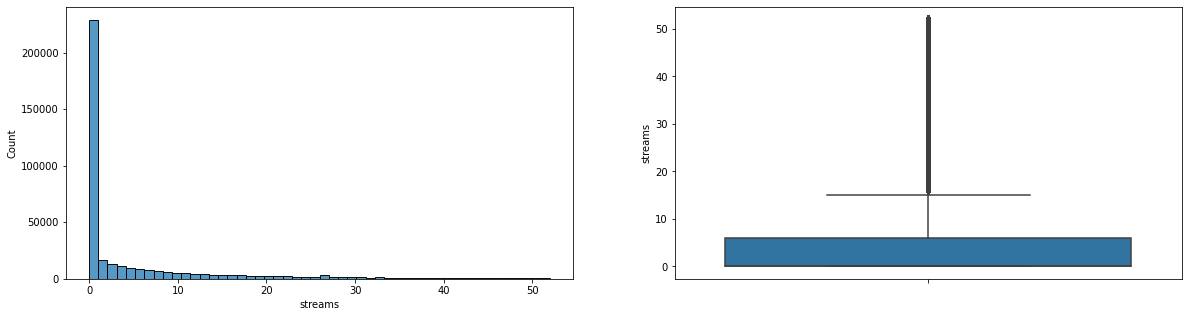

'stream30s'

'# of outliers: 19478'

'% of outliers: 100.0'

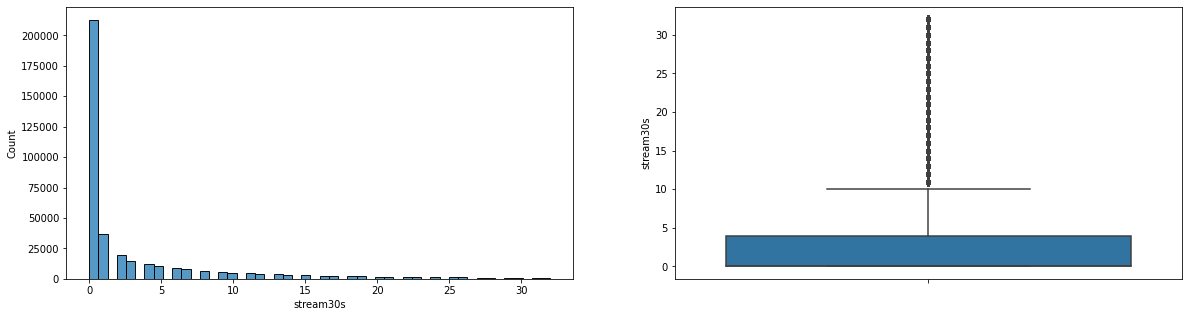

'dau'

'# of outliers: 13568'

'% of outliers: 100.0'

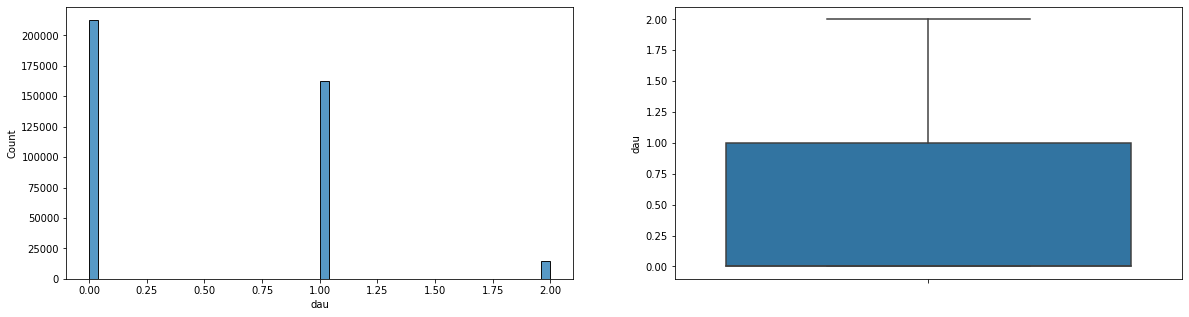

'wau'

'# of outliers: 18582'

'% of outliers: 100.0'

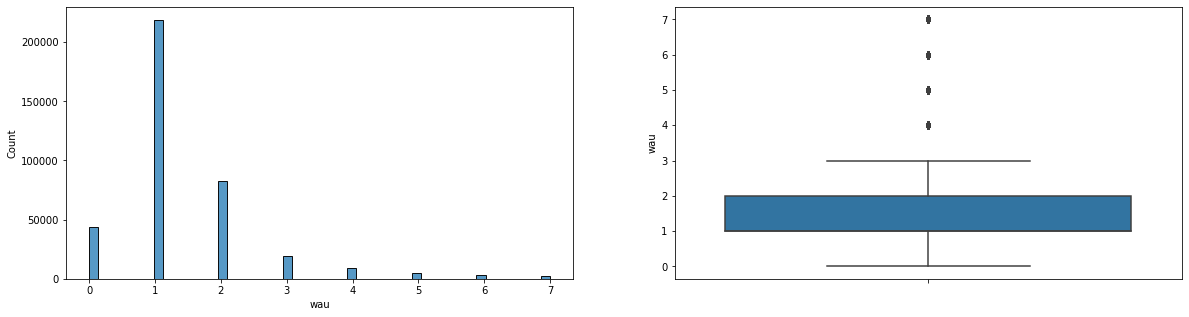

'mau'

'# of outliers: 19999'

'% of outliers: 100.0'

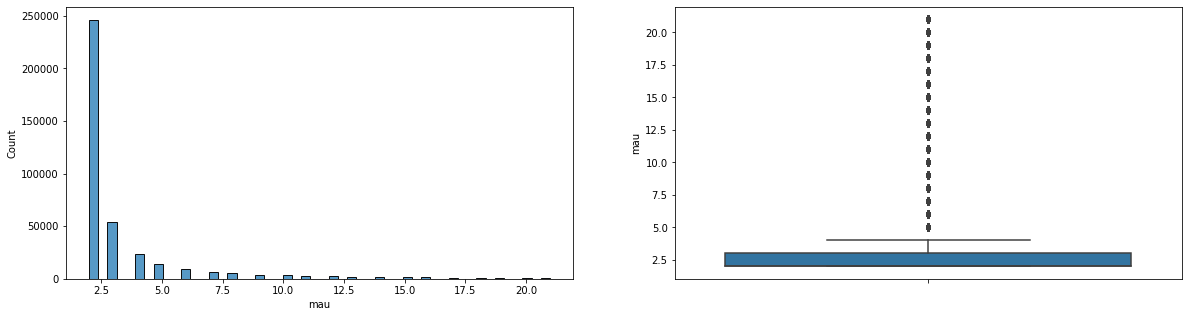

'mau_previous_month'

'# of outliers: 19363'

'% of outliers: 100.0'

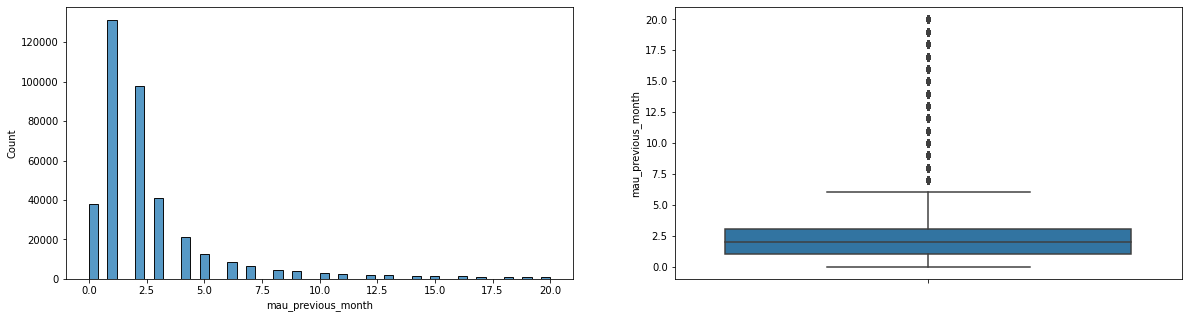

'mau_both_months'

'# of outliers: 19944'

'% of outliers: 100.0'

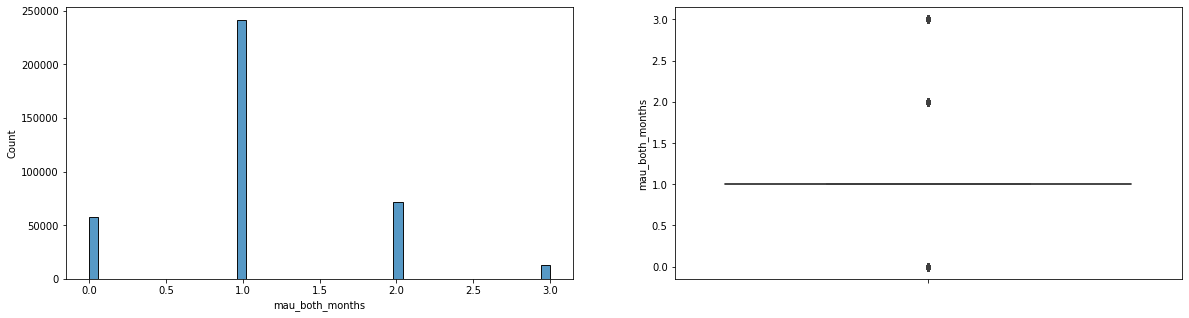

'users'

'# of outliers: 20087'

'% of outliers: 100.0'

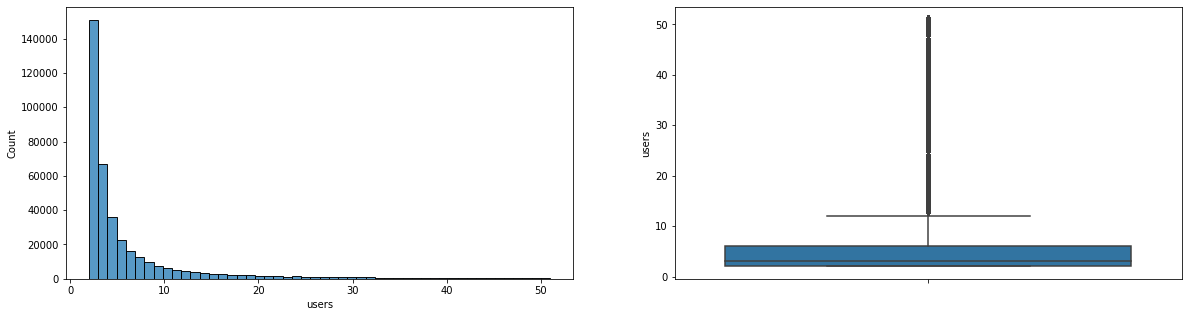

'skippers'

'# of outliers: 16514'

'% of outliers: 100.0'

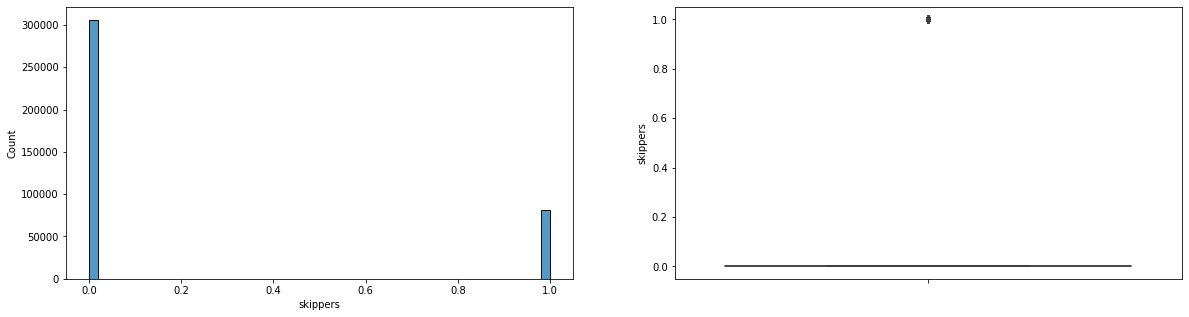

'n_tracks'

'# of outliers: 20149'

'% of outliers: 100.0'

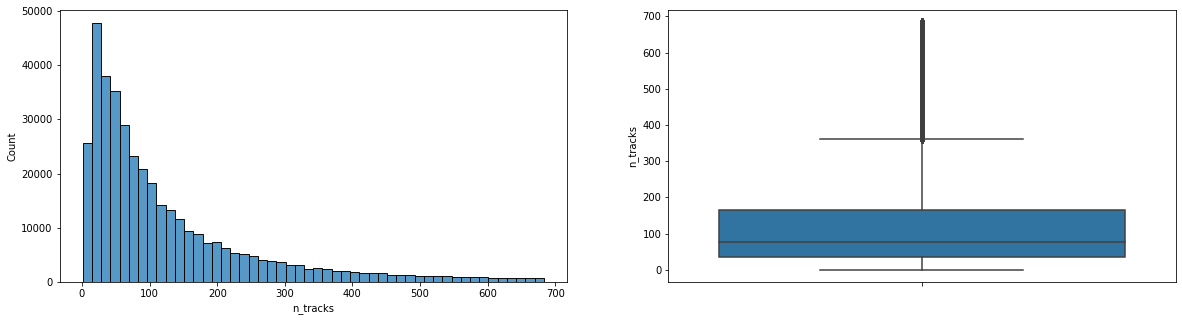

'n_local_tracks'

'# of outliers: 19085'

'% of outliers: 100.0'

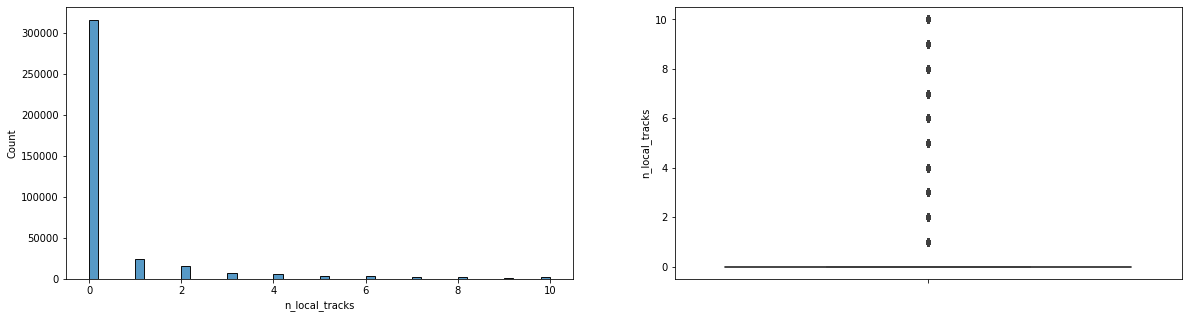

'n_artists'

'# of outliers: 20077'

'% of outliers: 100.0'

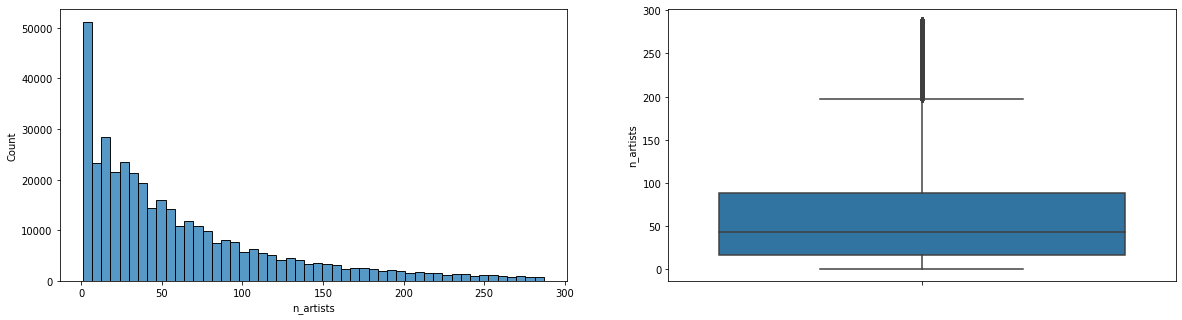

'n_albums'

'# of outliers: 20103'

'% of outliers: 100.0'

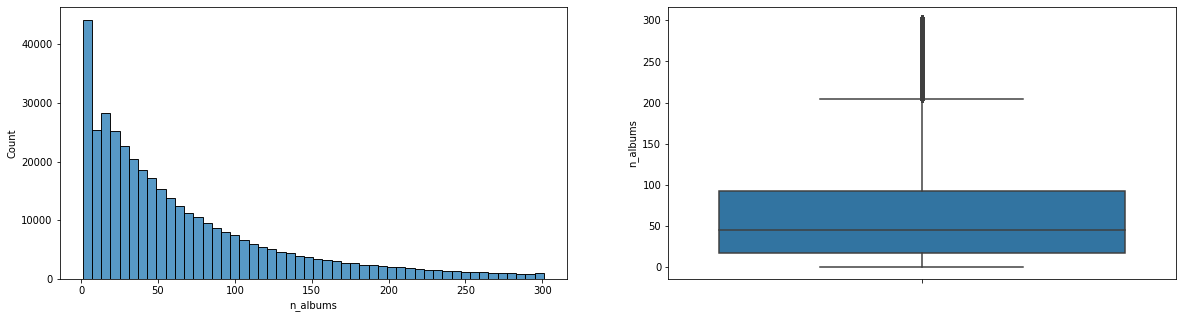

'monthly_stream30s'

'# of outliers: 20144'

'% of outliers: 100.0'

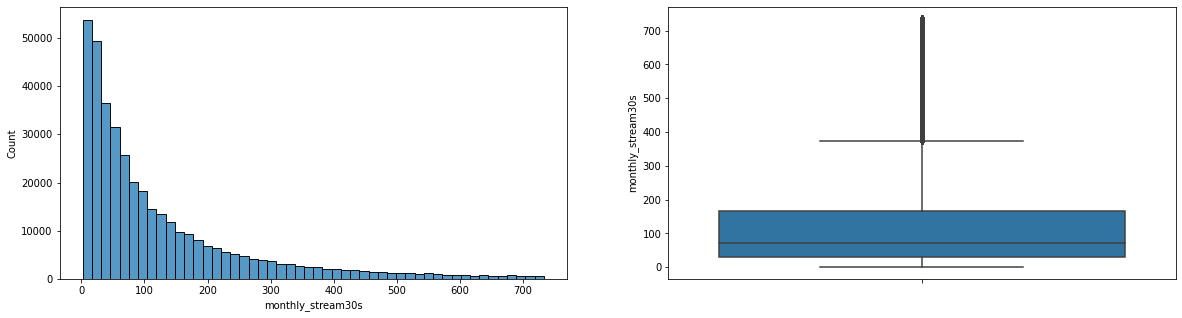

'monthly_owner_stream30s'

'# of outliers: 20125'

'% of outliers: 100.0'

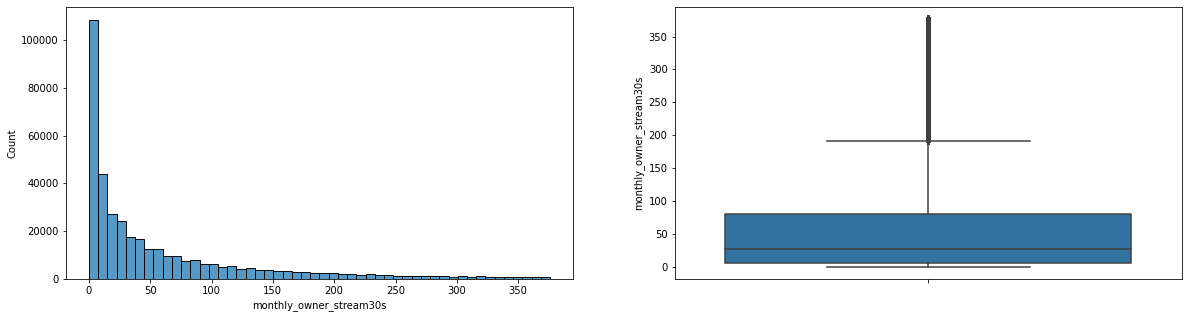

'tracks_per_album'

'# of outliers: 20157'

'% of outliers: 100.0'

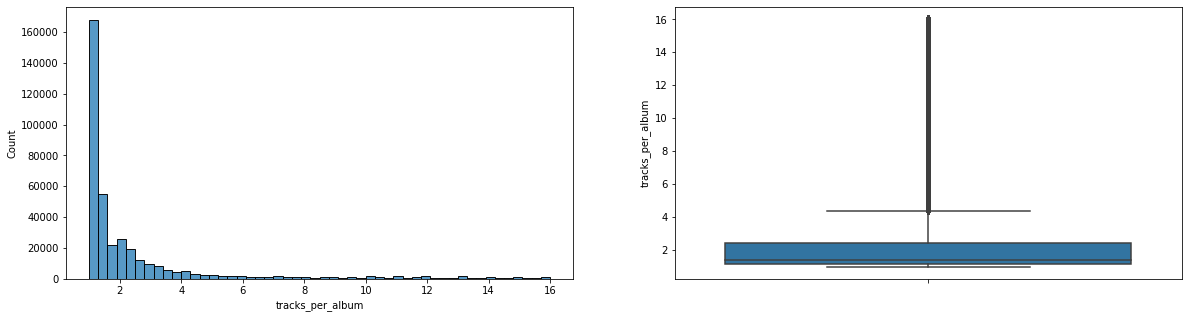

'artists_per_album'

'# of outliers: 20168'

'% of outliers: 100.0'

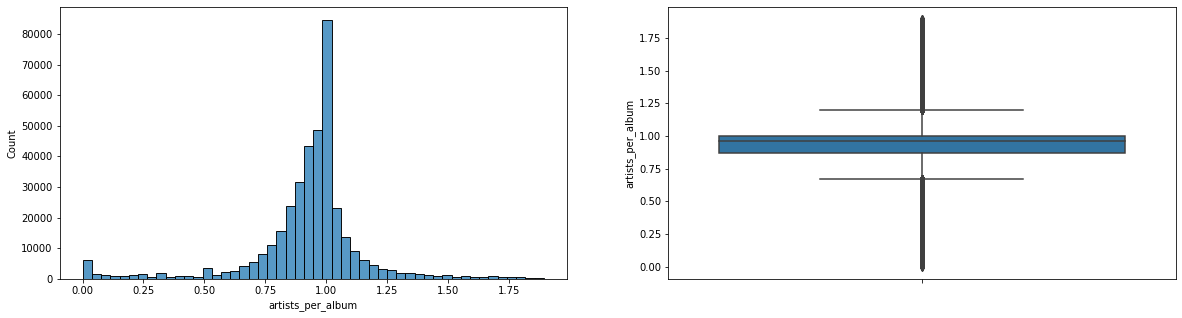

'owner_stream'

'# of outliers: 0'

'% of outliers: 100.0'

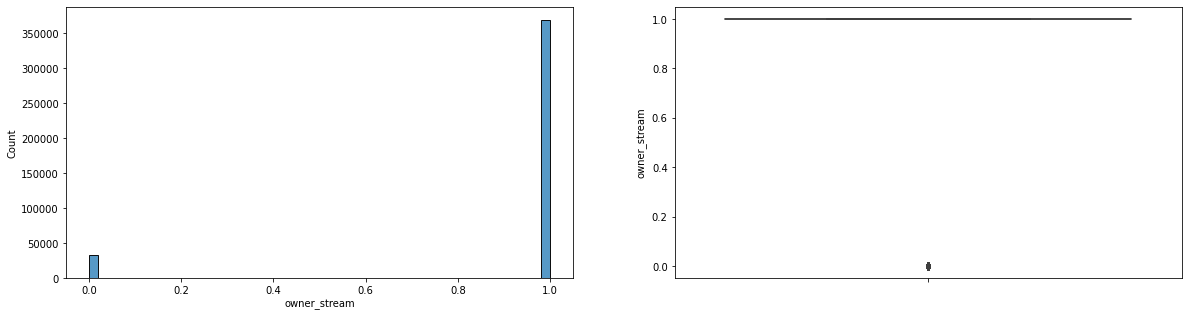

'mau_adjusted'

'# of outliers: 20140'

'% of outliers: 100.0'

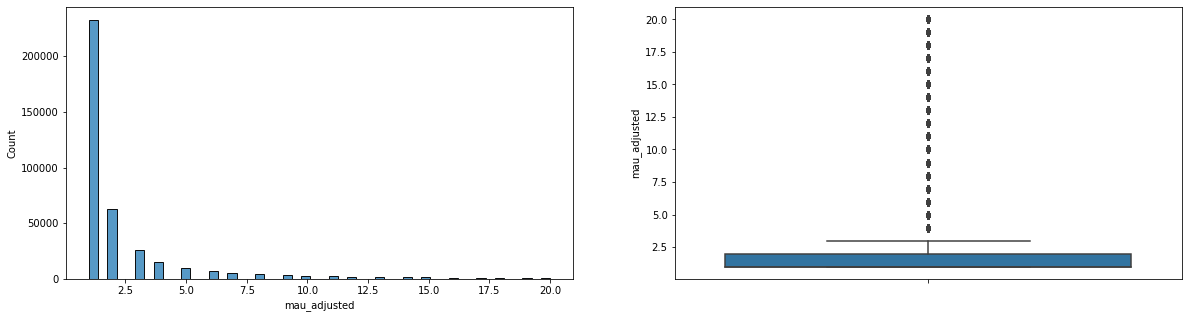

'monhtly_non_owner_stream30s'

'# of outliers: 20169'

'% of outliers: 100.0'

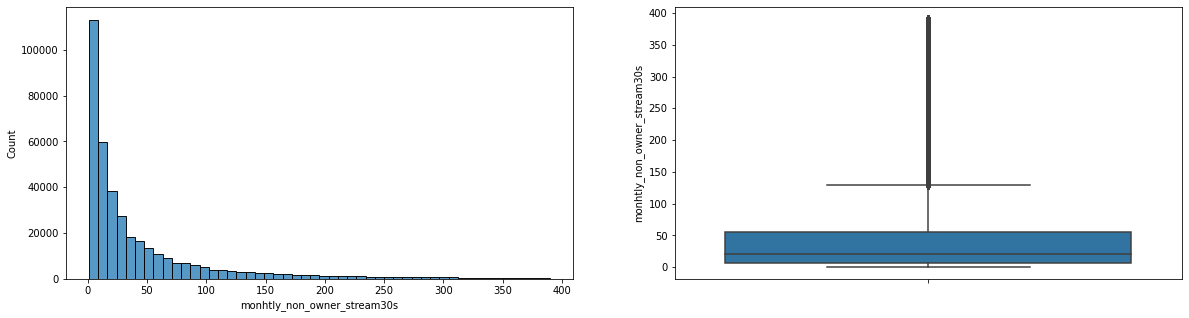

'streaming_ratio_mau'

'# of outliers: 19989'

'% of outliers: 100.0'

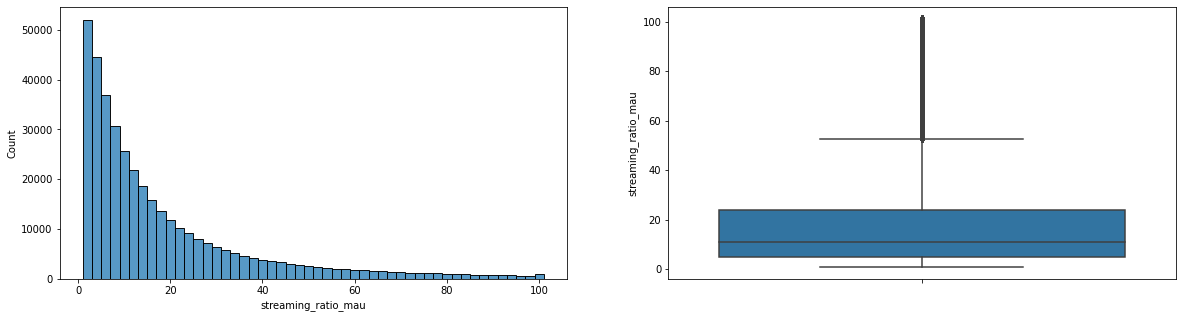

'streaming_ratio_users'

'# of outliers: 20167'

'% of outliers: 100.0'

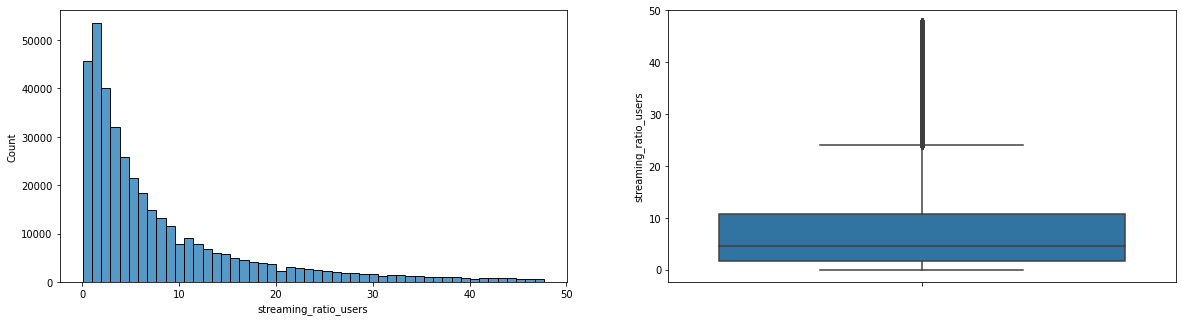

'mau_perc'

'# of outliers: 0'

'% of outliers: 100.0'

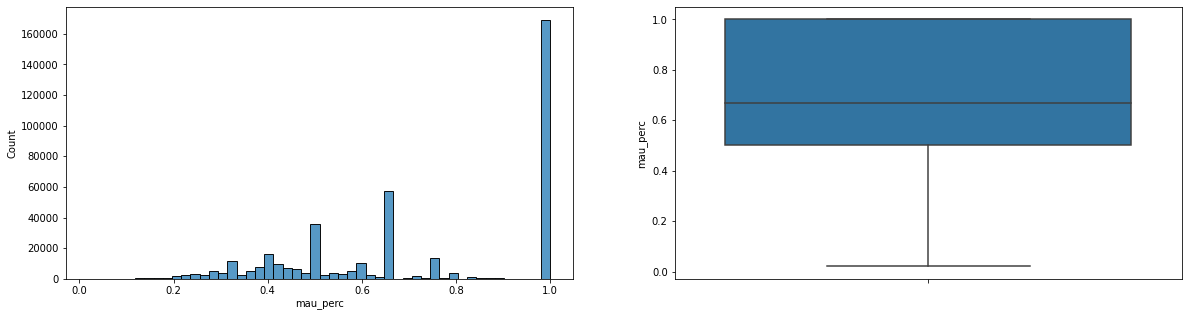

'mau_new'

'# of outliers: 16961'

'% of outliers: 100.0'

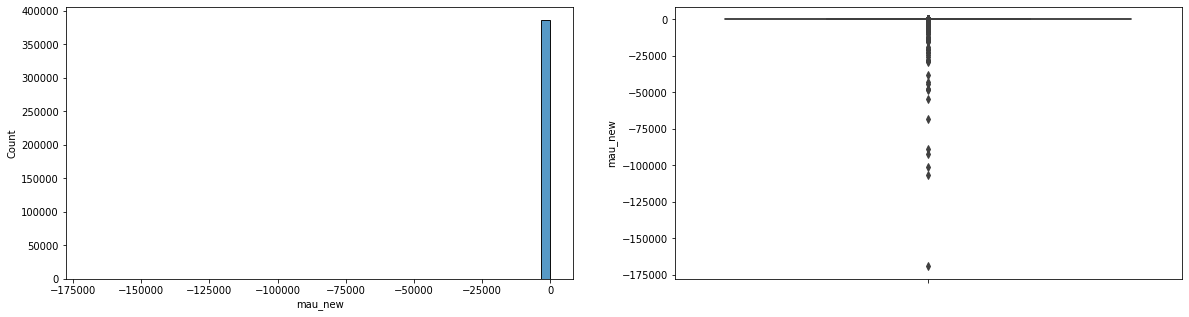

'mau_new_perc'

'# of outliers: 18470'

'% of outliers: 100.0'

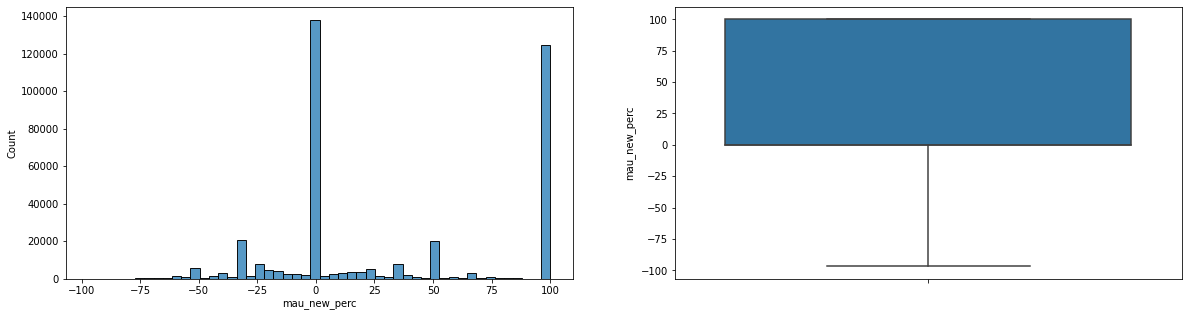

In [11]:
for col in num_cols:
    lower_quantile = 0
    upper_quantile = 0.95

    upper_quantile = feature_frame[col].quantile(upper_quantile)
    lower_quantile = feature_frame[col].quantile(lower_quantile)

    target = (feature_frame
              .loc[lambda f: f[col]<=upper_quantile]
              .loc[lambda f: f[col]>=lower_quantile])

    num_outliers = len(feature_frame) - len(target)
    perc_outliers = round(len(feature_frame) / (len(feature_frame)),3) * 100
    
    display(col)
    display(f'# of outliers: {num_outliers}')
    display(f'% of outliers: {perc_outliers}')
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    sns.histplot(x=col, data=target, bins=50, ax=ax[0])
    sns.boxplot(y=col, data=target, ax=ax[1])
    plt.show()
    
  
 

## Categorical Fetaure Profiling

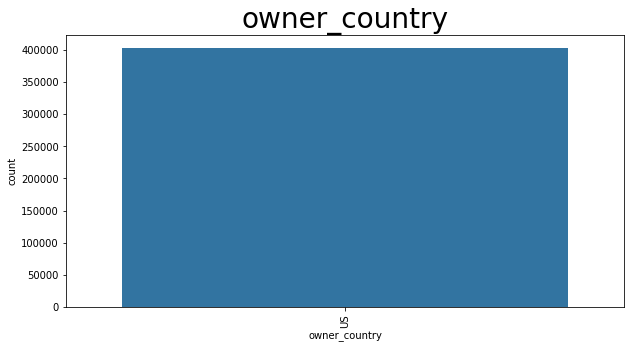

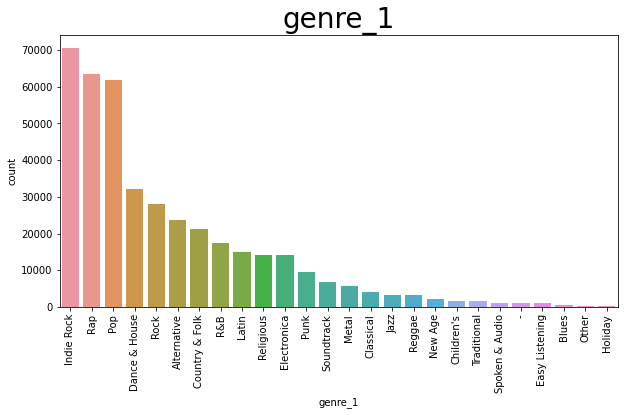

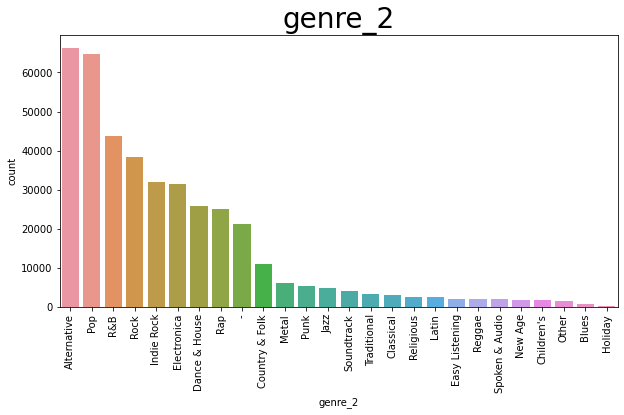

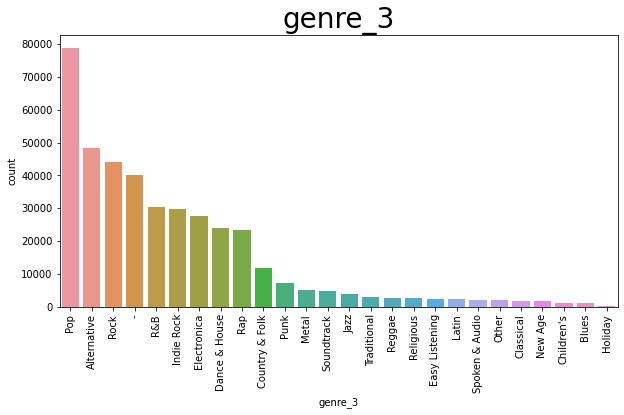

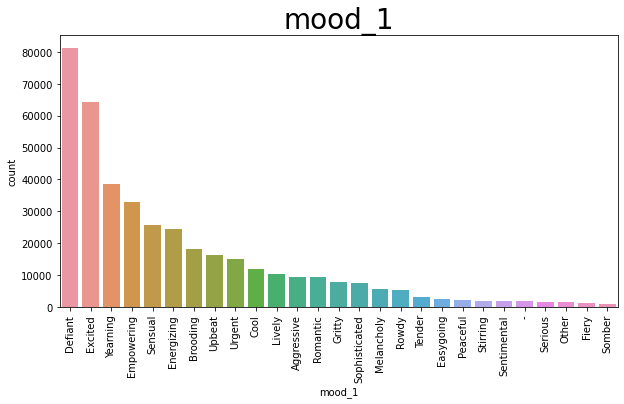

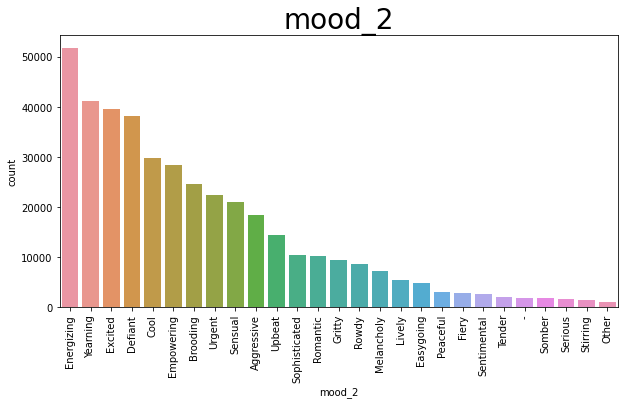

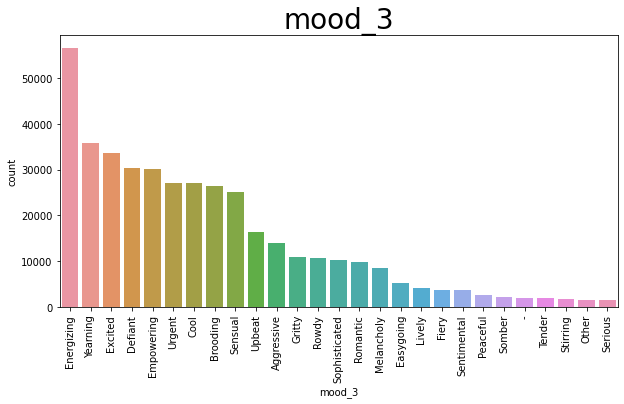

In [12]:
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.countplot(x=col, data=feature_frame, order=feature_frame[col].value_counts().index)
    plt.title(col, size=28)
    plt.xticks(rotation=90)
    plt.show()

## Bivariate Analysis 

'streams'

'# of outliers: 19815'

'% of outliers: 4.9'

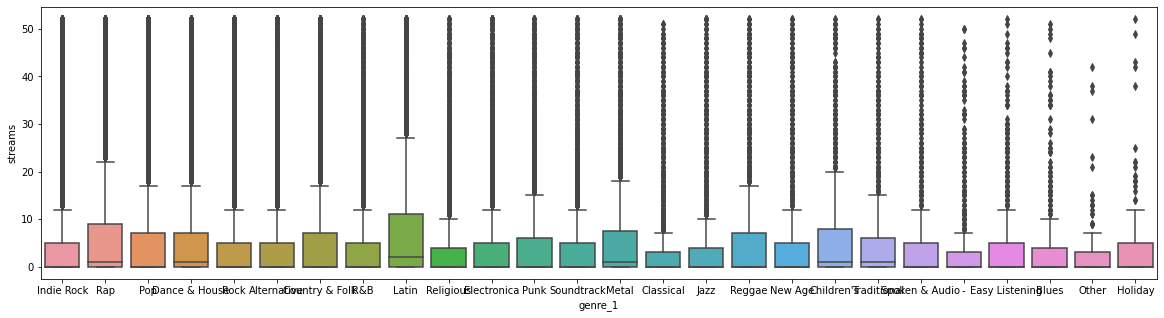

'stream30s'

'# of outliers: 19478'

'% of outliers: 4.8'

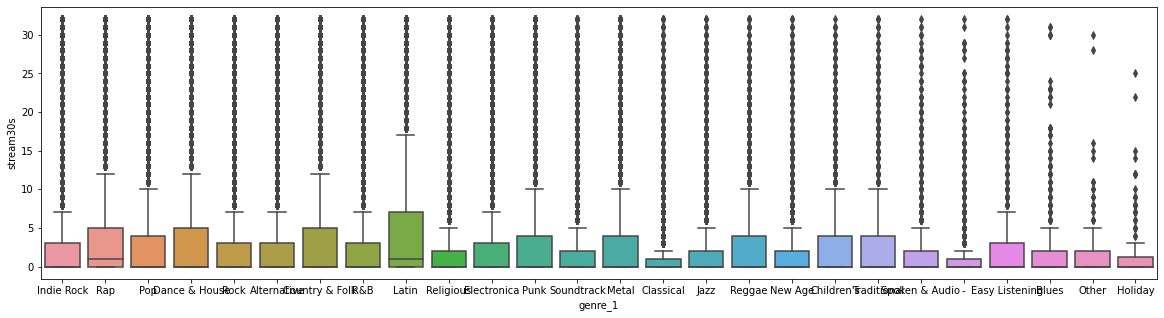

'dau'

'# of outliers: 13568'

'% of outliers: 3.4000000000000004'

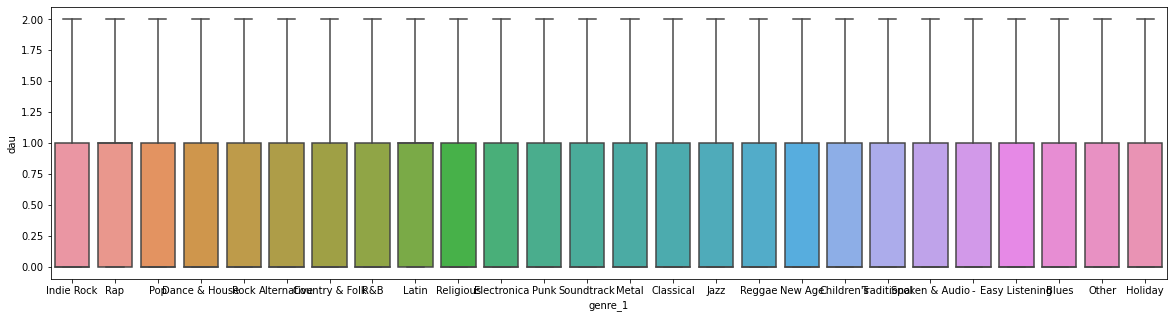

'wau'

'# of outliers: 18582'

'% of outliers: 4.6'

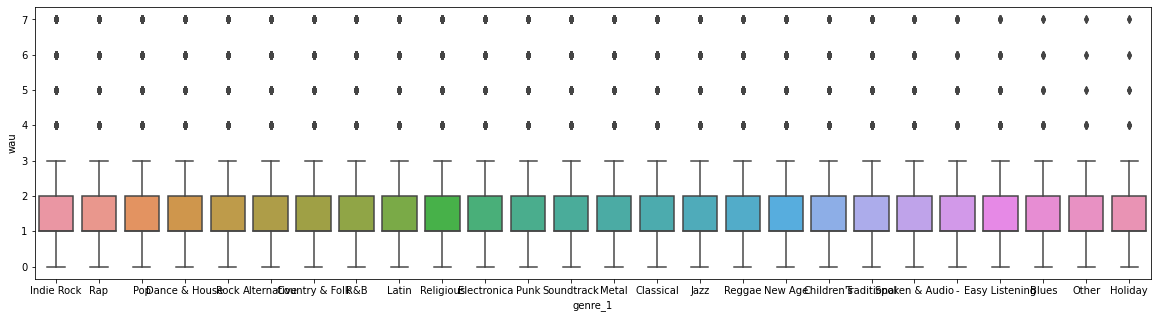

'mau'

'# of outliers: 19999'

'% of outliers: 5.0'

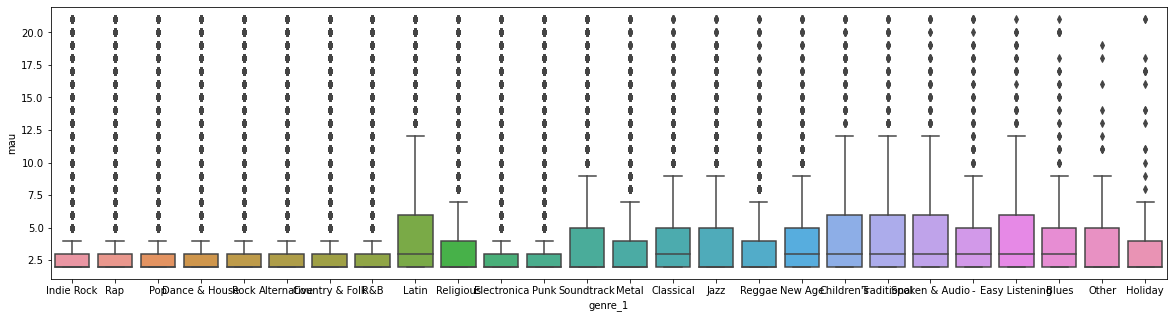

'mau_previous_month'

'# of outliers: 19363'

'% of outliers: 4.8'

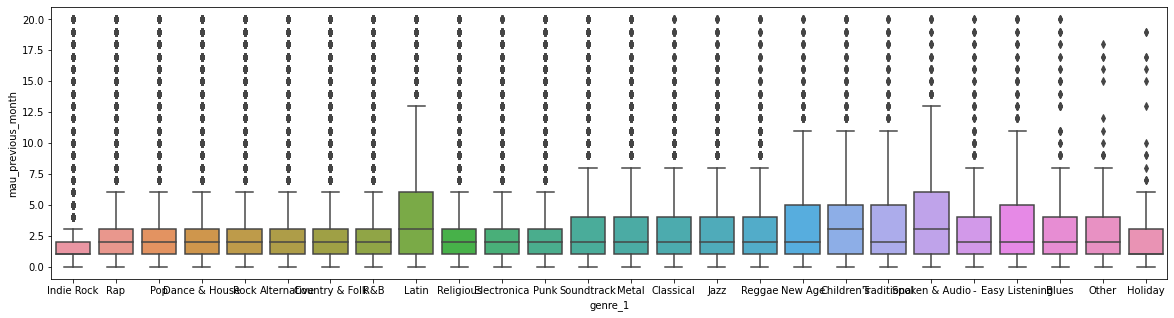

'mau_both_months'

'# of outliers: 19944'

'% of outliers: 4.9'

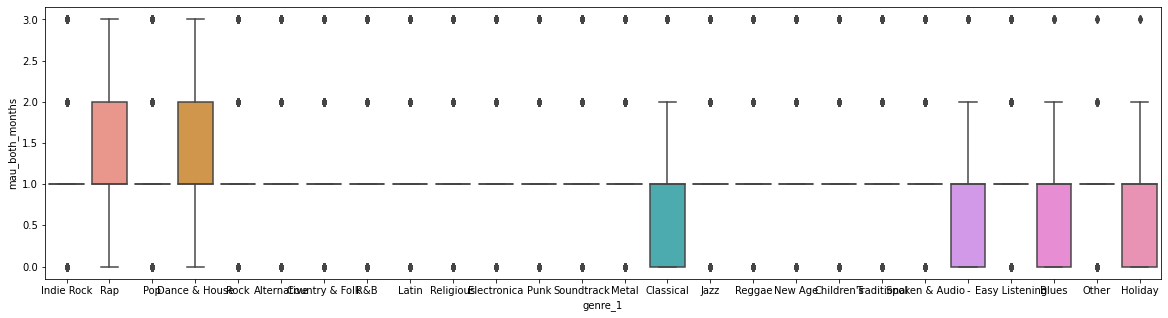

'users'

'# of outliers: 20087'

'% of outliers: 5.0'

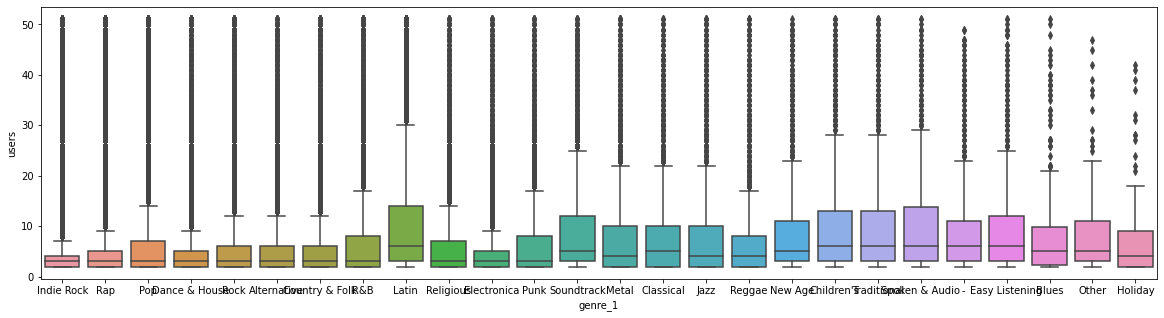

'skippers'

'# of outliers: 16514'

'% of outliers: 4.1000000000000005'

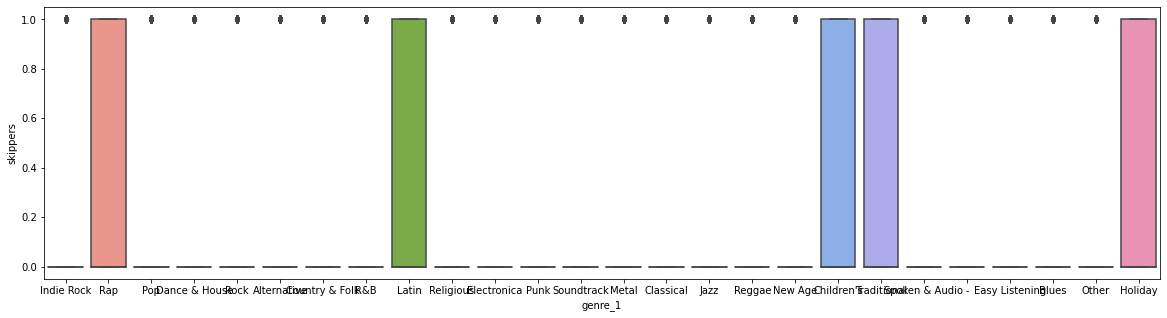

'n_tracks'

'# of outliers: 20149'

'% of outliers: 5.0'

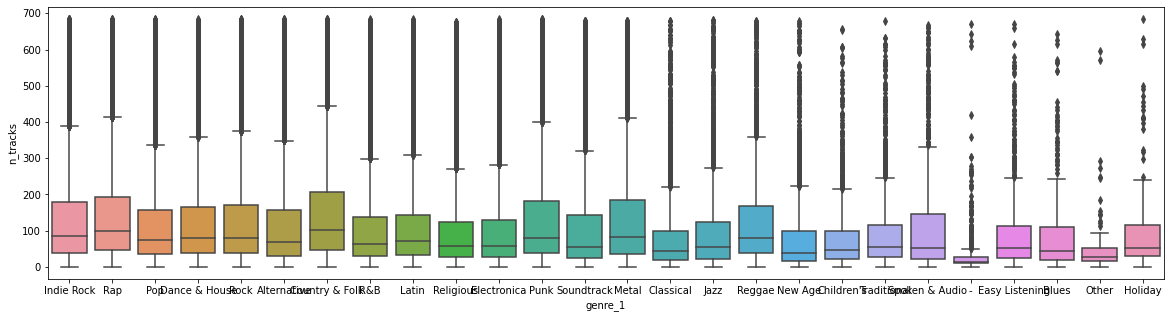

'n_local_tracks'

'# of outliers: 19085'

'% of outliers: 4.7'

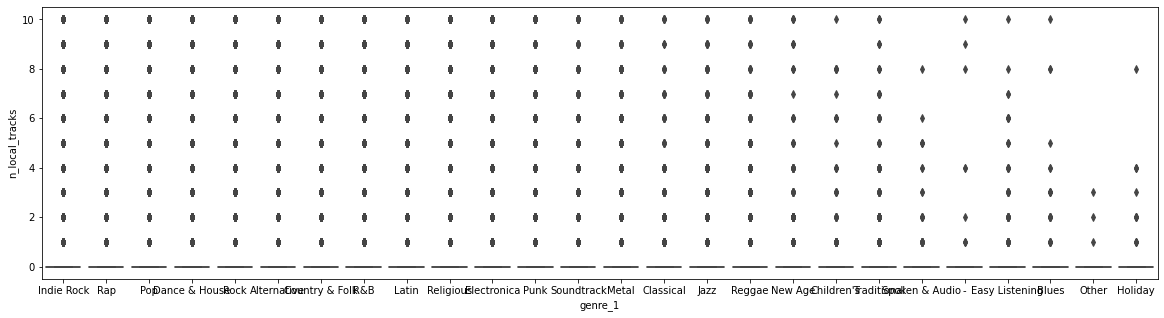

'n_artists'

'# of outliers: 20077'

'% of outliers: 5.0'

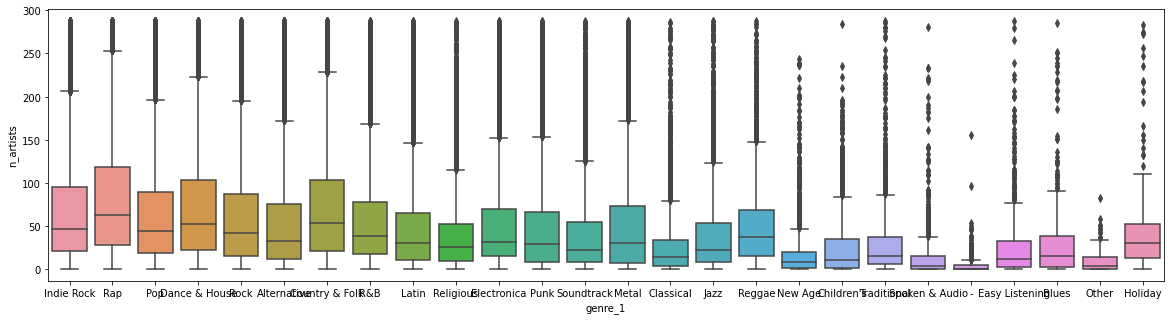

'n_albums'

'# of outliers: 20103'

'% of outliers: 5.0'

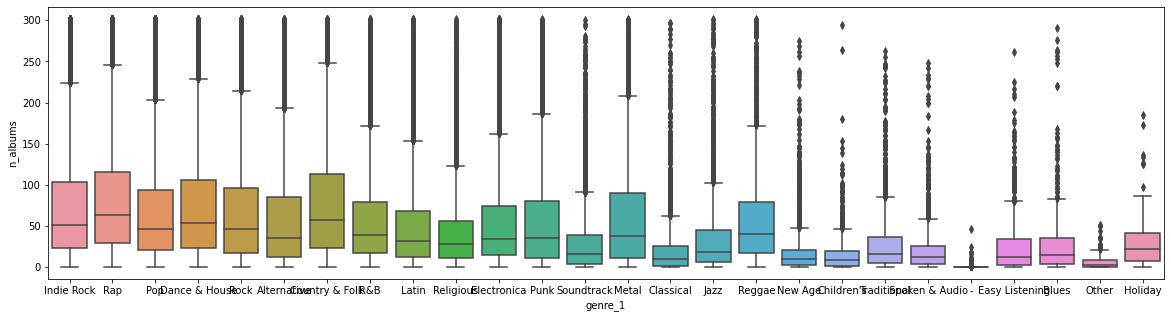

'monthly_stream30s'

'# of outliers: 20144'

'% of outliers: 5.0'

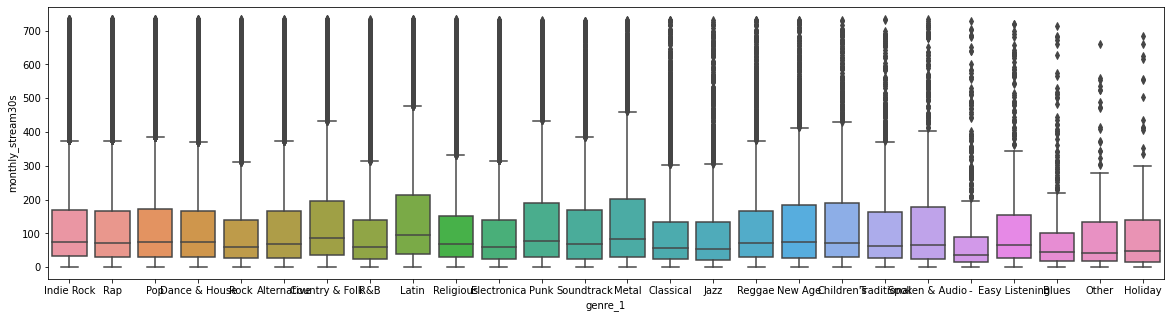

'monthly_owner_stream30s'

'# of outliers: 20125'

'% of outliers: 5.0'

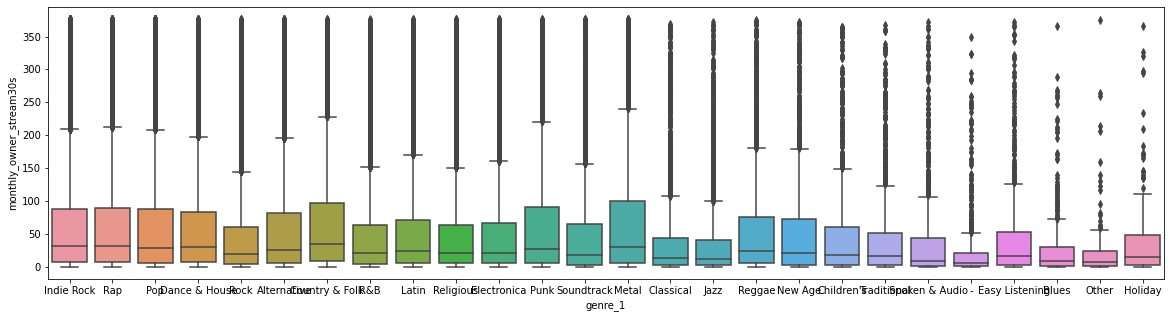

'tracks_per_album'

'# of outliers: 20157'

'% of outliers: 5.0'

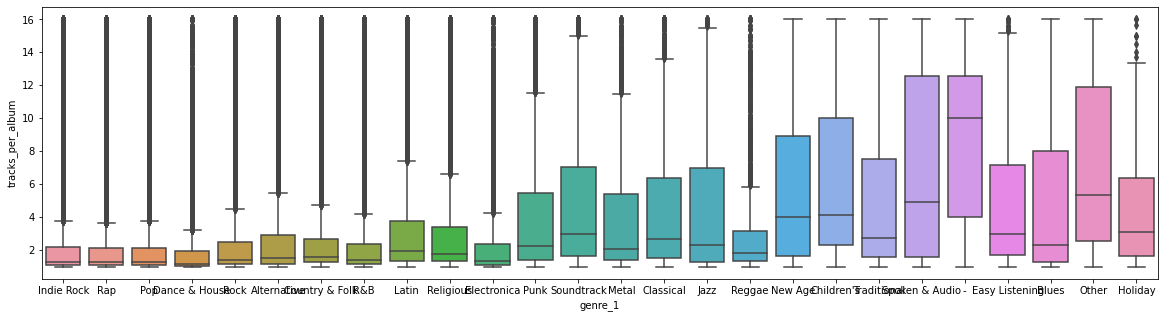

'artists_per_album'

'# of outliers: 20168'

'% of outliers: 5.0'

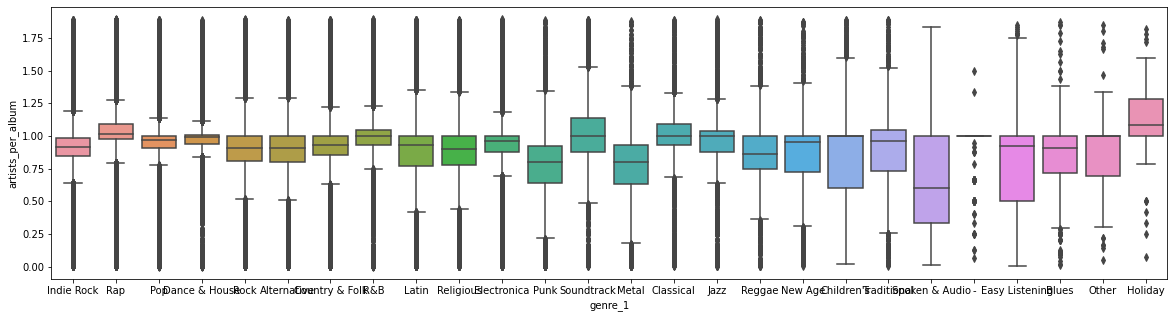

'owner_stream'

'# of outliers: 0'

'% of outliers: 0.0'

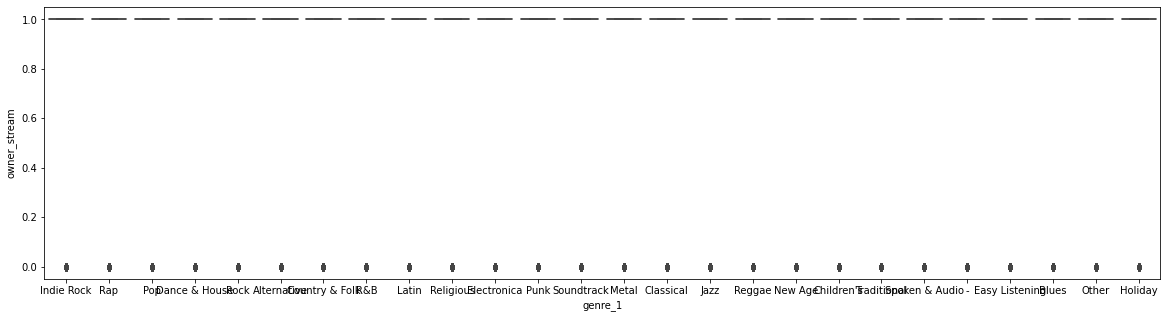

'mau_adjusted'

'# of outliers: 20140'

'% of outliers: 5.0'

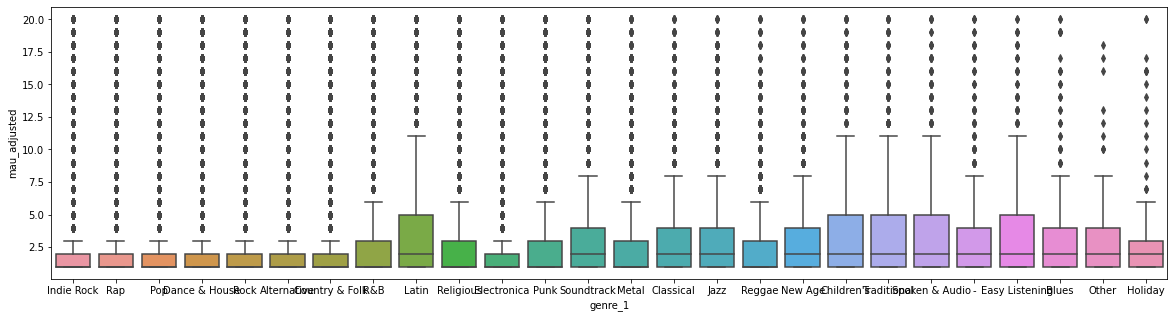

'monhtly_non_owner_stream30s'

'# of outliers: 20169'

'% of outliers: 5.0'

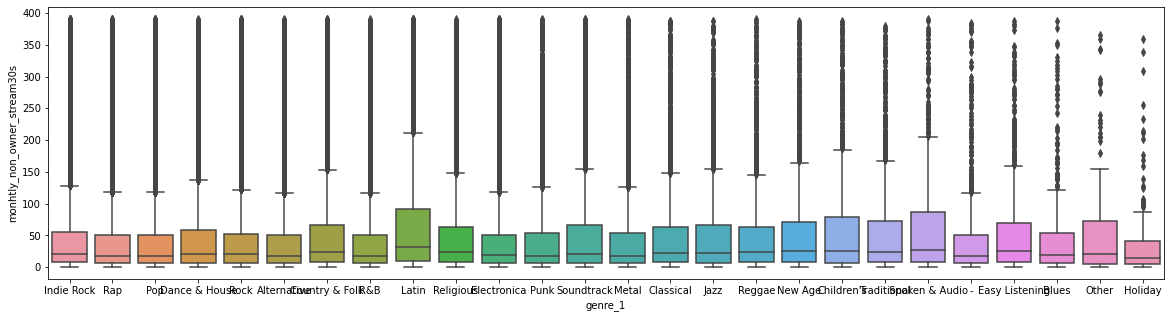

'streaming_ratio_mau'

'# of outliers: 19989'

'% of outliers: 5.0'

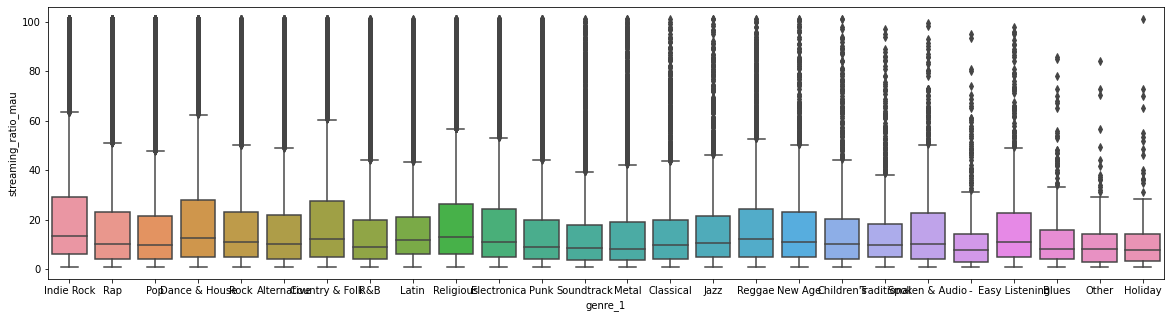

'streaming_ratio_users'

'# of outliers: 20167'

'% of outliers: 5.0'

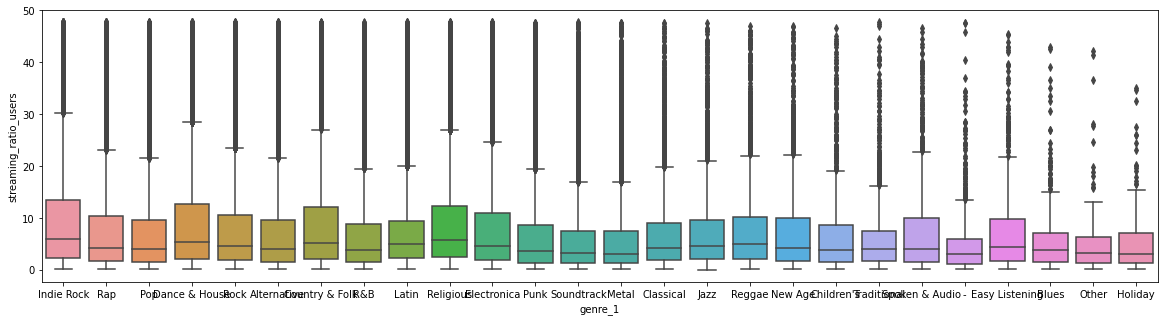

'mau_perc'

'# of outliers: 0'

'% of outliers: 0.0'

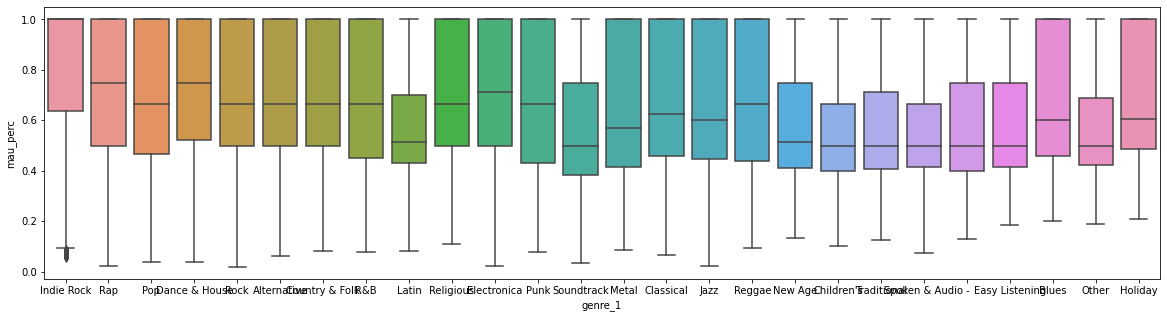

'mau_new'

'# of outliers: 16961'

'% of outliers: 4.2'

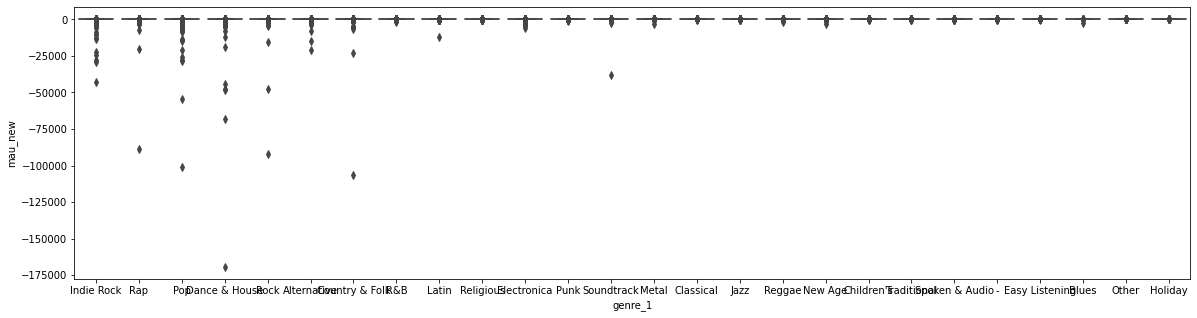

'mau_new_perc'

'# of outliers: 18470'

'% of outliers: 4.6'

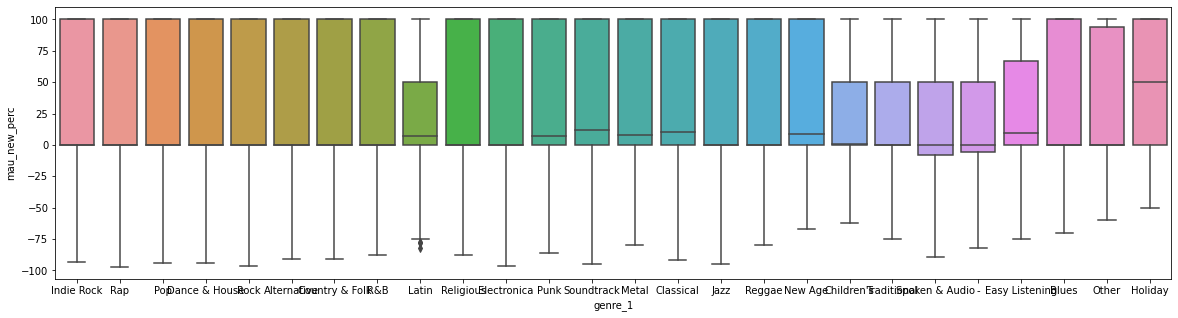

In [13]:
for col in num_cols:
    lower_quantile = 0
    upper_quantile = 0.95

    upper_quantile = feature_frame[col].quantile(upper_quantile)
    lower_quantile = feature_frame[col].quantile(lower_quantile)

    target = (feature_frame
              .loc[lambda f: f[col]<=upper_quantile]
              .loc[lambda f: f[col]>=lower_quantile])

    num_outliers = len(feature_frame) - len(target)
    perc_outliers = round(num_outliers / (len(feature_frame)),3) * 100
    
    display(col)
    display(f'# of outliers: {num_outliers}')
    display(f'% of outliers: {perc_outliers}')
    
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.boxplot(x="genre_1", y=col, data=target, order=feature_frame["genre_1"].value_counts().index)
    plt.show()

# Defining Success

In [15]:
feature_frame["users"].quantile(0.50)

3.0

In [16]:
# mau_threshold = 4
# target_frame = feature_frame.loc[lambda f: f["mau_adjusted"]>mau_threshold]

# display(len(target_frame))
# display(len(feature_frame))
# display(len(target_frame) / len(feature_frame))

In [111]:
users_threshold = 10
target_frame = feature_frame.loc[lambda f: f["users_adjusted"]>users_threshold]

display(len(target_frame))
display(len(feature_frame))
display(len(target_frame) / len(feature_frame))

70399

403366

0.17452883981297382

In [57]:
target_frame.users.min()

10

In [18]:
target_frame.groupby("genre_1").quantile(q=0.50)

streams  stream30s  dau  wau   mau  mau_previous_month  \
genre_1                                                                  
-                   4.0        3.0  1.0  3.0  10.0                 9.0   
Alternative         5.0        3.0  1.0  3.0   9.0                 8.0   
Blues               7.0        5.0  1.0  3.0  10.0                 9.0   
Children's          9.0        5.0  1.0  4.0  12.0                10.0   
Classical           3.0        2.0  1.0  3.0  10.0                 8.0   
Country & Folk      6.0        4.0  1.0  3.0   9.0                 9.0   
Dance & House       8.0        4.0  1.0  3.0   9.0                 8.0   
Easy Listening      6.0        4.0  1.0  3.0   9.0                 9.0   
Electronica         6.0        3.0  1.0  3.0   9.0                 8.0   
Holiday            14.0        7.0  1.0  6.0  17.0                 7.0   
Indie Rock          6.0        3.0  1.0  3.0   8.0                 8.0   
Jazz                5.0        3.0  1.0  3.0  11.0                 9.0   
Latin              12.0        7.0  1.0  4.0  14.0                12.0   
Metal               6.0        3.0  1.0  3.0   9.0                 8.0   
New Age             5.0        3.0  1.0  3.0   9.0                 8.0   
Other               4.0        2.0  1.0  3.0   8.0                 7.0   
Pop                 6.0        3.0  1.0  3.0   9.0                 9.0   
Punk                4.0        2.0  1.0  3.0   8.0                 7.0   
R&B                 5.0        2.0  1.0  3.0   9.0                 9.0   
Rap                 9.0        4.0  1.0  3.0   9.0                 8.0   
Reggae              8.0        4.0  1.0  3.0   9.0                 9.0   
Religious           5.0        3.0  1.0  3.0  10.0                 9.0   
Rock                5.0        3.0  1.0  3.0   9.0                 9.0   
Soundtrack          6.0        2.0  1.0  3.0  10.0                 9.0   
Spoken & Audio      4.0        2.0  1.0  3.0  11.0                10.0   
Traditional         6.0        4.0  1.0  4.0  12.0                11.0   

                mau_both_months  users  skippers  n_tracks  ...  owner_stream  \
genre_1                                                     ...                 
-                           1.0   22.0       0.0      15.0  ...           1.0   
Alternative                 1.0   21.5       1.0      72.0  ...           1.0   
Blues                       1.0   21.5       0.0      65.0  ...           1.0   
Children's                  2.0   28.0       1.0      52.0  ...           1.0   
Classical                   1.0   21.0       1.0      48.0  ...           1.0   
Country & Folk              1.0   21.0       1.0      94.0  ...           1.0   
Dance & House               2.0   21.0       1.0      94.0  ...           1.0   
Easy Listening              1.0   21.0       1.0      58.0  ...           1.0   
Electronica                 2.0   22.0       1.0      67.0  ...           1.0   
Holiday                     1.0   32.0       1.0      50.0  ...           1.0   
Indie Rock                  2.0   19.0       1.0      96.0  ...           1.0   
Jazz                        1.0   23.0       1.0      76.0  ...           1.0   
Latin                       2.0   30.0       1.0      71.0  ...           1.0   
Metal                       1.0   21.0       1.0      91.0  ...           1.0   
New Age                     1.0   21.0       1.0      47.0  ...           1.0   
Other                       1.0   18.0       0.0      27.0  ...           1.0   
Pop                         1.0   23.0       1.0      74.0  ...           1.0   
Punk                        1.0   20.0       1.0      86.0  ...           1.0   
R&B                         1.0   23.0       1.0      74.0  ...           1.0   
Rap                         2.0   22.0       1.0      97.0  ...           1.0   
Reggae                      2.0   21.0       1.0      84.0  ...           1.0   
Religious                   2.0   21.0       0.0      66.0  ...           1.0   

In [19]:
plays_success_threshold = 0.75
threshold_frame_plays = target_frame.groupby("genre_1").quantile(q=plays_success_threshold)[["streaming_ratio_mau", "streaming_ratio_users"]]
threshold_frame_plays.columns = [str(col) + '_thresh' for col in threshold_frame_plays.columns]
display(threshold_frame_plays)

streaming_ratio_mau_thresh  streaming_ratio_users_thresh
genre_1                                                                 
-                                16.433777                      7.004132
Alternative                      16.980674                      7.170455
Blues                            16.693257                      7.705707
Children's                       20.244598                      8.704318
Classical                        19.333333                      8.937500
Country & Folk                   20.688317                      8.931794
Dance & House                    21.236111                      9.543561
Easy Listening                   24.428571                     11.195489
Electronica                      20.083333                      8.555556
Holiday                          15.000000                      8.791667
Indie Rock                       22.000000                      9.777778
Jazz                             22.520023                     10.315818
Latin                            19.000000                      8.933120
Metal                            17.370536                      7.116594
New Age                          28.500000                     11.666667
Other                            14.458333                      6.652644
Pop                              16.166667                      6.713075
Punk                             16.779549                      7.097727
R&B                              15.444444                      6.552419
Rap                              15.250000                      6.399002
Reggae                           19.900000                      8.437500
Religious                        23.225490                     11.254477
Rock                             18.050633                      7.897436
Soundtrack                       15.691371                      6.333333
Spoken & Audio                   22.641807                     10.751177
Traditional                      17.843750                      7.679288

In [22]:
skips_success_threshold = 0.25
threshold_frame_skips = target_frame.loc[lambda f: f['skip_ratio_users']>0].groupby("genre_1").quantile(q=skips_success_threshold)[["skip_ratio_users"]]
threshold_frame_skips.columns = [str(col) + '_thresh' for col in threshold_frame_skips.columns]
display(threshold_frame_skips)

skip_ratio_users_thresh
genre_1                                
-                              1.311953
Alternative                    1.714286
Blues                          1.382753
Children's                     1.363636
Classical                      1.250000
Country & Folk                 1.764706
Dance & House                  2.307692
Easy Listening                 1.455392
Electronica                    1.714286
Holiday                        1.552397
Indie Rock                     1.777778
Jazz                           1.272085
Latin                          1.650000
Metal                          1.875000
New Age                        1.085995
Other                          1.818182
Pop                            1.836735
Punk                           1.666667
R&B                            1.764706
Rap                            2.368421
Reggae                         1.875000
Religious                      1.428571
Rock                           1.621622
Soundtrack                     1.556762
Spoken & Audio                 1.157034
Traditional                    1.369623

In [23]:
threshold_frame_plays

streaming_ratio_mau_thresh  streaming_ratio_users_thresh
genre_1                                                                 
-                                16.433777                      7.004132
Alternative                      16.980674                      7.170455
Blues                            16.693257                      7.705707
Children's                       20.244598                      8.704318
Classical                        19.333333                      8.937500
Country & Folk                   20.688317                      8.931794
Dance & House                    21.236111                      9.543561
Easy Listening                   24.428571                     11.195489
Electronica                      20.083333                      8.555556
Holiday                          15.000000                      8.791667
Indie Rock                       22.000000                      9.777778
Jazz                             22.520023                     10.315818
Latin                            19.000000                      8.933120
Metal                            17.370536                      7.116594
New Age                          28.500000                     11.666667
Other                            14.458333                      6.652644
Pop                              16.166667                      6.713075
Punk                             16.779549                      7.097727
R&B                              15.444444                      6.552419
Rap                              15.250000                      6.399002
Reggae                           19.900000                      8.437500
Religious                        23.225490                     11.254477
Rock                             18.050633                      7.897436
Soundtrack                       15.691371                      6.333333
Spoken & Audio                   22.641807                     10.751177
Traditional                      17.843750                      7.679288

In [24]:
success_frame = (target_frame
                 .merge(threshold_frame_plays.reset_index()[["genre_1", "streaming_ratio_mau_thresh", "streaming_ratio_users_thresh"]], on="genre_1", how='left')
                 .merge(threshold_frame_skips.reset_index()[["genre_1", "skip_ratio_users_thresh"]], on="genre_1", how='left')
                 .assign(success_skip_ratio = lambda f: np.where(f["skip_ratio_users"] <= f['skip_ratio_users_thresh'], 1, 0))
                 .assign(success_streaming_ratio_mau = lambda f: np.where(f["streaming_ratio_mau"] >= f['streaming_ratio_mau_thresh'], 1, 0))
                 .assign(success_streaming_ratio_users = lambda f: np.where(f["streaming_ratio_users"] >= f['streaming_ratio_users_thresh'], 1, 0))
                 .assign(success_all = lambda f: np.where((f["success_skip_ratio"]==1) & (f["streaming_ratio_users_thresh"]==1), 1, 0))
                )

In [25]:
display(success_frame["success_skip_ratio"].value_counts())
display(success_frame["success_streaming_ratio_mau"].value_counts())
display(success_frame["success_streaming_ratio_users"].value_counts())
display(success_frame["success_all"].value_counts())

1    42372
0    38780
Name: success_skip_ratio, dtype: int64

0    60829
1    20323
Name: success_streaming_ratio_mau, dtype: int64

0    60850
1    20302
Name: success_streaming_ratio_users, dtype: int64

0    81152
Name: success_all, dtype: int64

In [26]:
success_frame

playlist_uri  \
0      spotify:user:6b7fbed9edd6418ddd3b555bba441536:...   
1      spotify:user:580b98725077a94c3c8d01d07390426b:...   
2      spotify:user:f7eae3b747d71612726316e5fbae7bab:...   
3      spotify:user:d2663dd02ba0b23da58f0e3c20a9e29f:...   
4      spotify:user:e94f26e753c60c77af42865c3abb795e:...   
...                                                  ...   
81147  spotify:user:6c37a662e07e9d48c612ddb36fa5a6a7:...   
81148  spotify:user:0174304c8028f06c87c2ca0a4ada3bb1:...   
81149  spotify:user:ea9e2bdbac3bea7a5b4733eb9537fb53:...   
81150  spotify:user:055d33003af0de47c79559c56ba6ee5b:...   
81151  spotify:user:4672952d42bdd93b9215ce9a40394ea6:...   

                                  owner  streams  stream30s  dau  wau  mau  \
0      6b7fbed9edd6418ddd3b555bba441536        4          2    1    1    7   
1      580b98725077a94c3c8d01d07390426b       12         12    1    1    4   
2      f7eae3b747d71612726316e5fbae7bab       25         12    2    9   32   
3      d2663dd02ba0b23da58f0e3c20a9e29f       59         51    2   10   17   
4      e94f26e753c60c77af42865c3abb795e        5          2    1    3    5   
...                                 ...      ...        ...  ...  ...  ...   
81147  6c37a662e07e9d48c612ddb36fa5a6a7       27         25    1    6   17   
81148  0174304c8028f06c87c2ca0a4ada3bb1        0          0    0    1    6   
81149  ea9e2bdbac3bea7a5b4733eb9537fb53        0          0    0    1    2   
81150  055d33003af0de47c79559c56ba6ee5b        0          0    0    2    4   
81151  4672952d42bdd93b9215ce9a40394ea6       18          6    2    6   13   

       mau_previous_month  mau_both_months  users  ...  mau_perc mau_new  \
0                       5                0     15  ...  0.466667       2   
1                       6                1     10  ...  0.400000      -2   
2                      26                1     71  ...  0.450704       6   
3                      12                5     29  ...  0.586207       5   
4                       9                1     18  ...  0.277778      -4   
...                   ...              ...    ...  ...       ...     ...   
81147                  14                5     30  ...  0.566667       3   
81148                   4                0     13  ...  0.461538       2   
81149                   7                1     10  ...  0.200000      -5   
81150                   4                1     15  ...  0.266667       0   
81151                  12                8     20  ...  0.650000       1   

       mau_new_perc  streaming_ratio_mau_thresh  streaming_ratio_users_thresh  \
0         40.000000                   19.000000                      8.933120   
1        -33.333333                   21.236111                      9.543561   
2         23.076923                   15.250000                      6.399002   
3         41.666667                   15.691371                      6.333333   
4        -44.444444                   15.250000                      6.399002   
...             ...                         ...                           ...   
81147     21.428571                   23.225490                     11.254477   
81148     50.000000                   18.050633                      7.897436   
81149    -71.428571                   20.083333                      8.555556   
81150      0.000000                   16.980674                      7.170455   
81151      8.333333                   22.000000                      9.777778   

       skip_ratio_users_thresh  success_skip_ratio  \
0                     1.650000                   0   
1                     2.307692                   1   
2                     2.368421                   0   
3                     1.556762                   0   
4                     2.368421                   0   
...                        ...                 ...   
81147                 1.428571                   0   
81148                 1.621622                   1   
81149         

# Analyzing Success

##  Numerical feature analysis

In [27]:
analyze_num_cols = ["n_tracks", "n_artists", "n_albums", "tracks_per_album", "artists_per_album"]

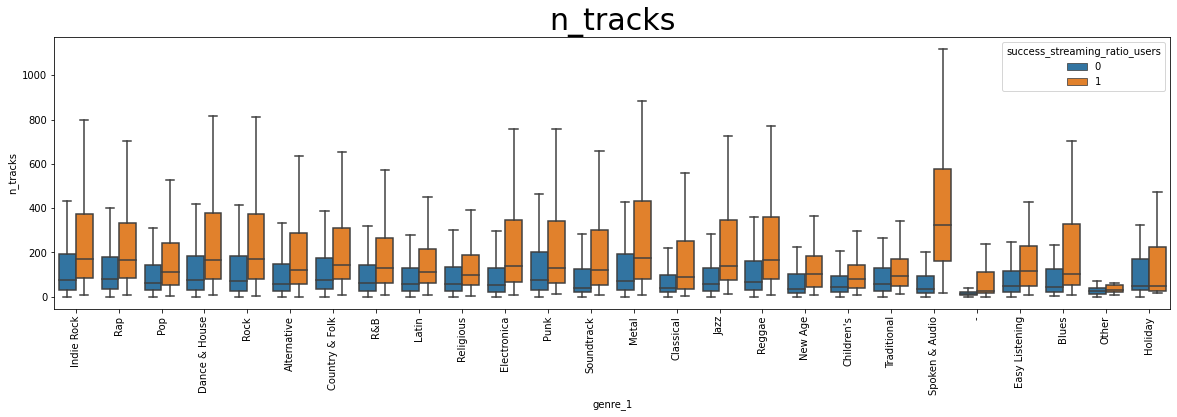

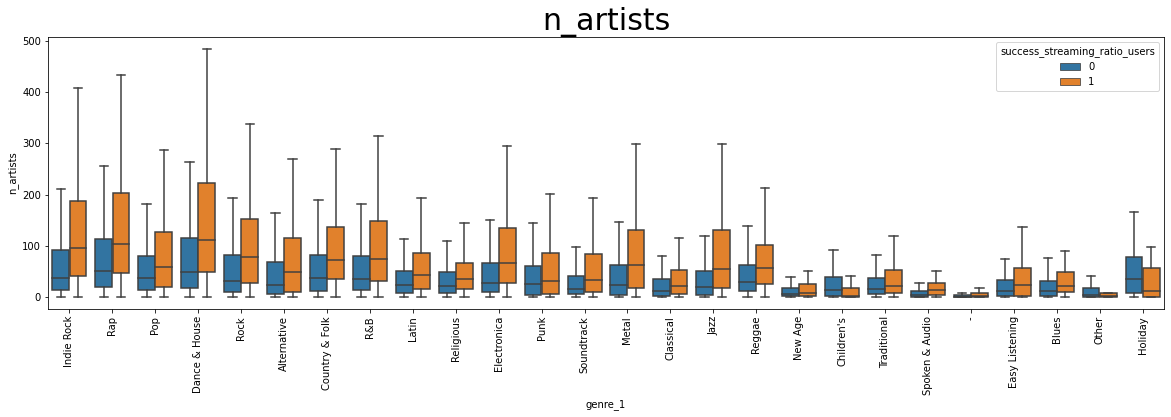

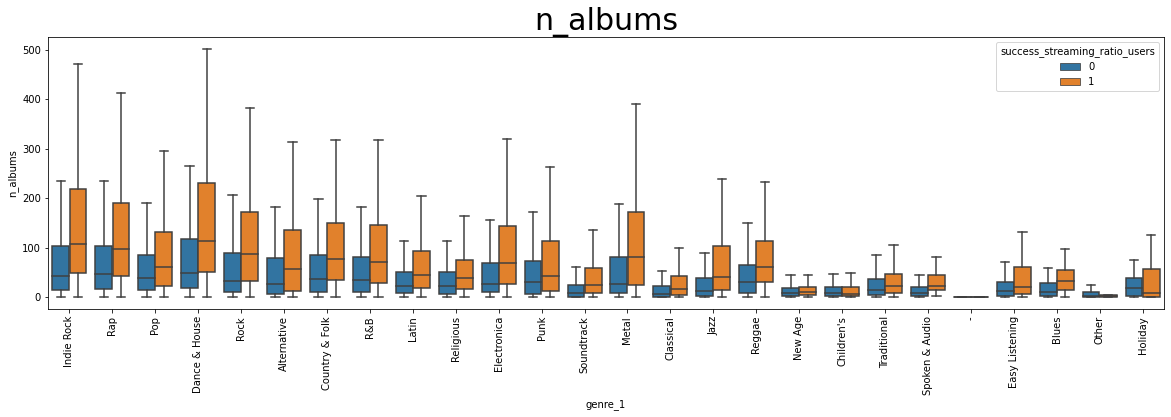

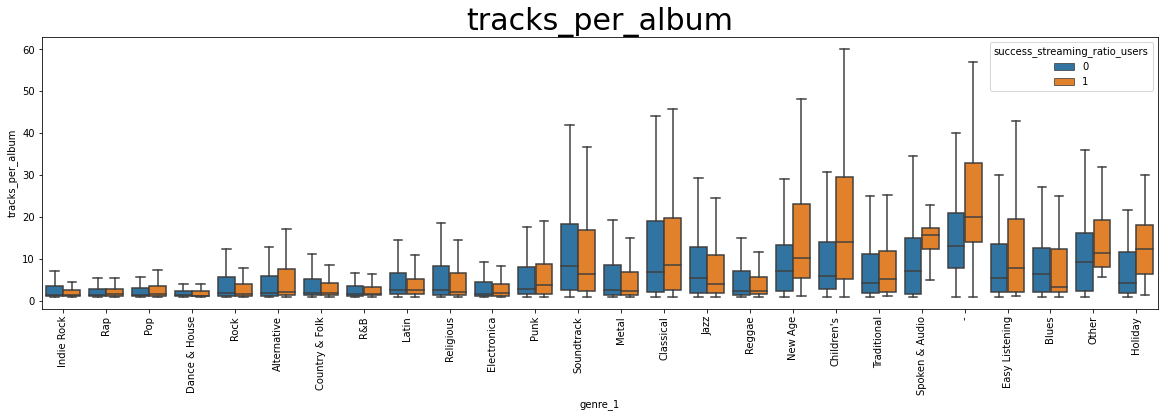

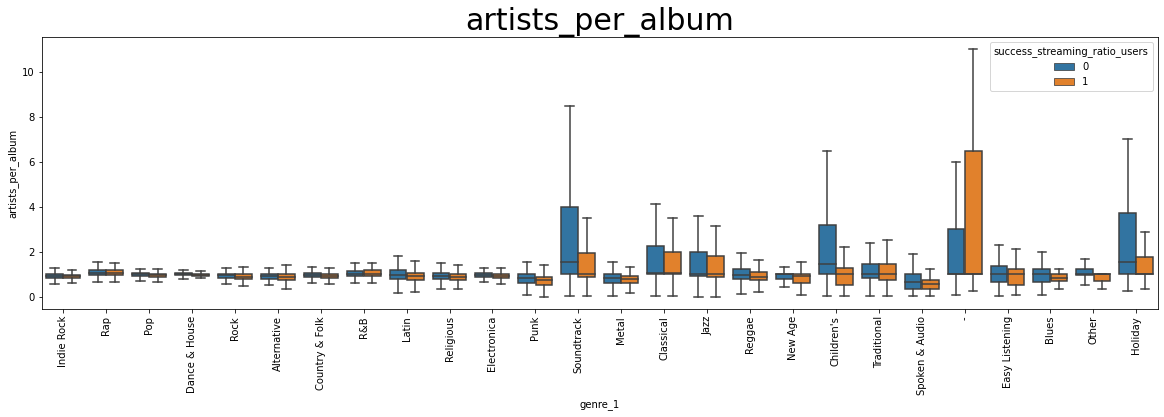

In [33]:
for col in analyze_num_cols:
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.boxplot(x="genre_1", y=col, data=success_frame, order=feature_frame["genre_1"].value_counts().index, hue="success_streaming_ratio_users", showfliers=False)
    plt.title(col, size=30)
    plt.xticks(rotation=90)
    plt.show()
    

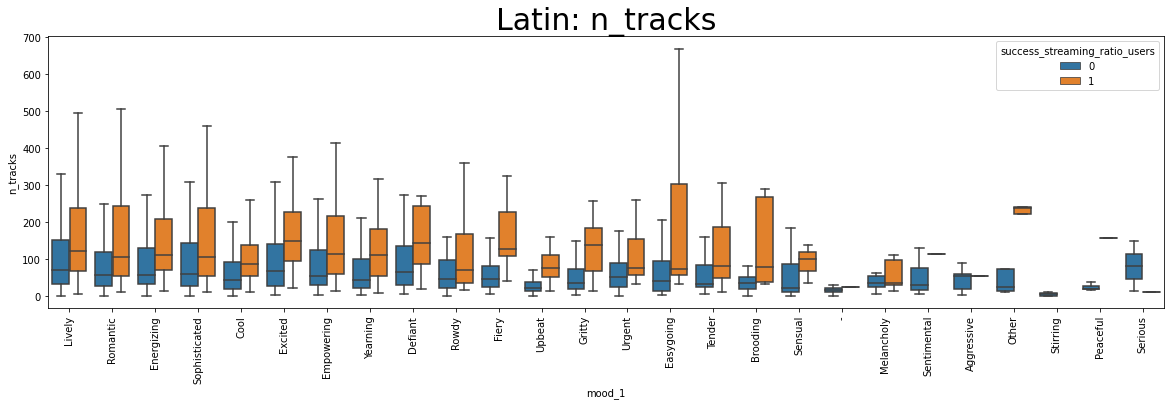

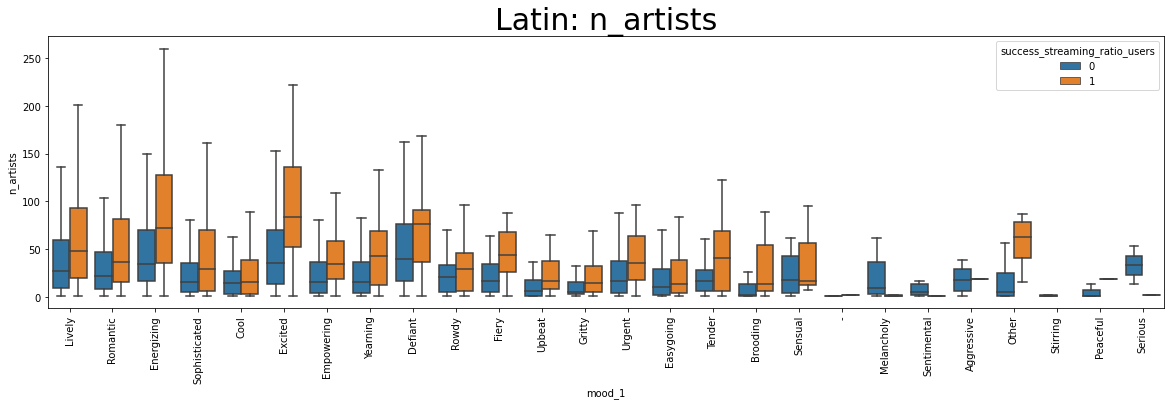

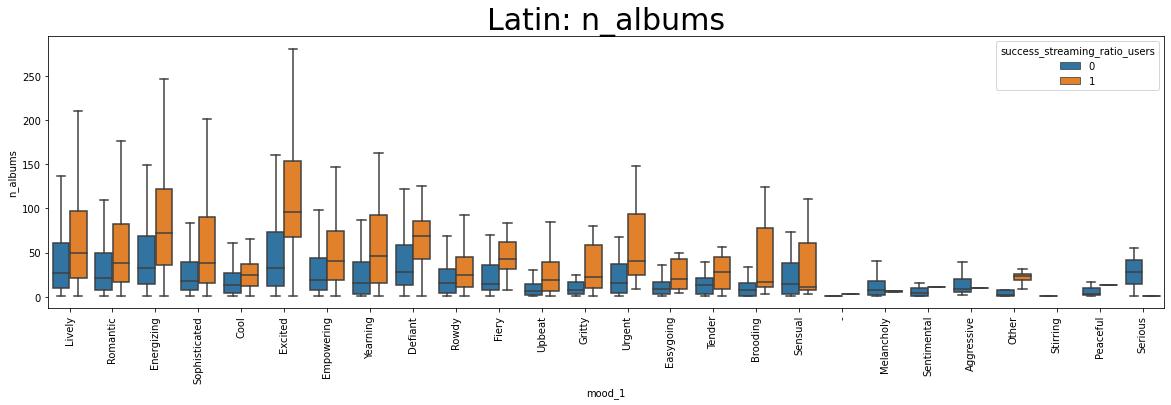

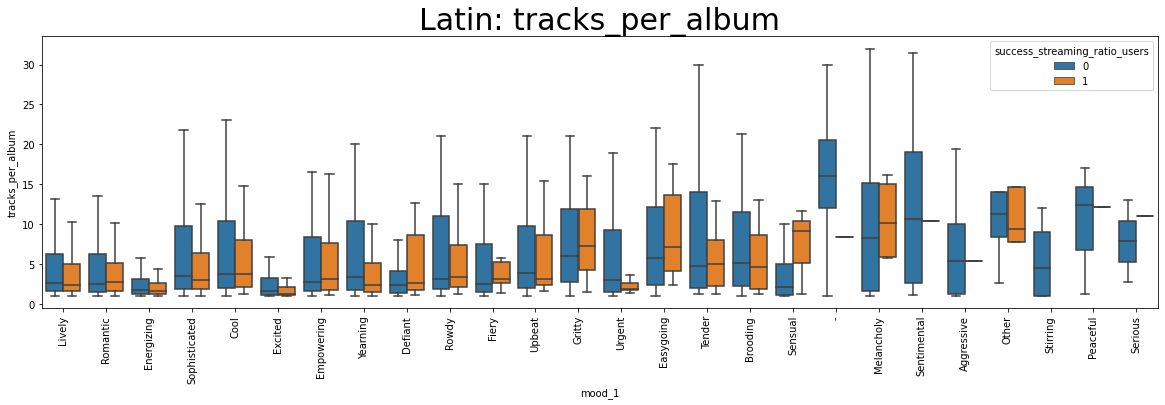

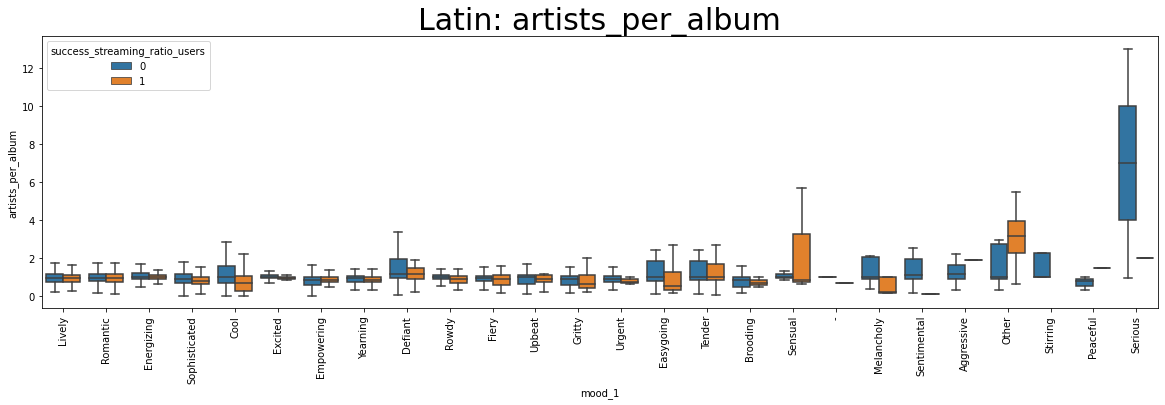

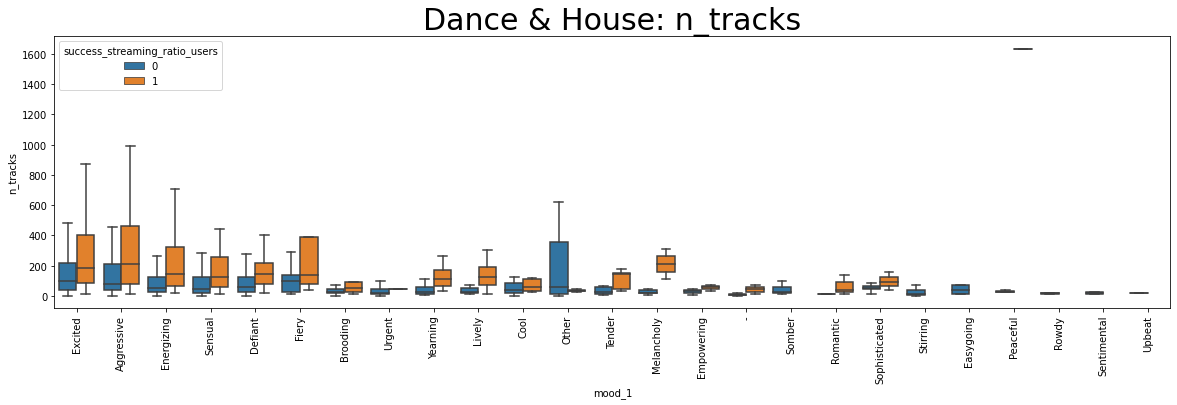

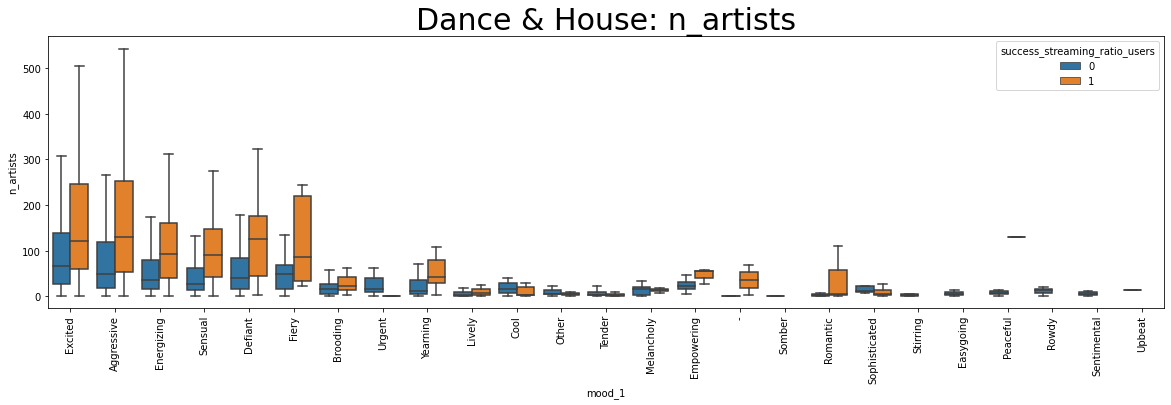

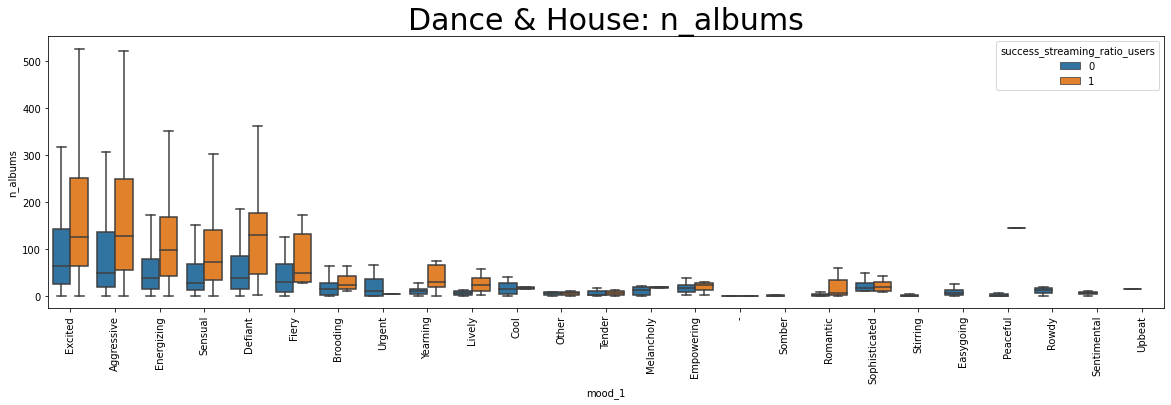

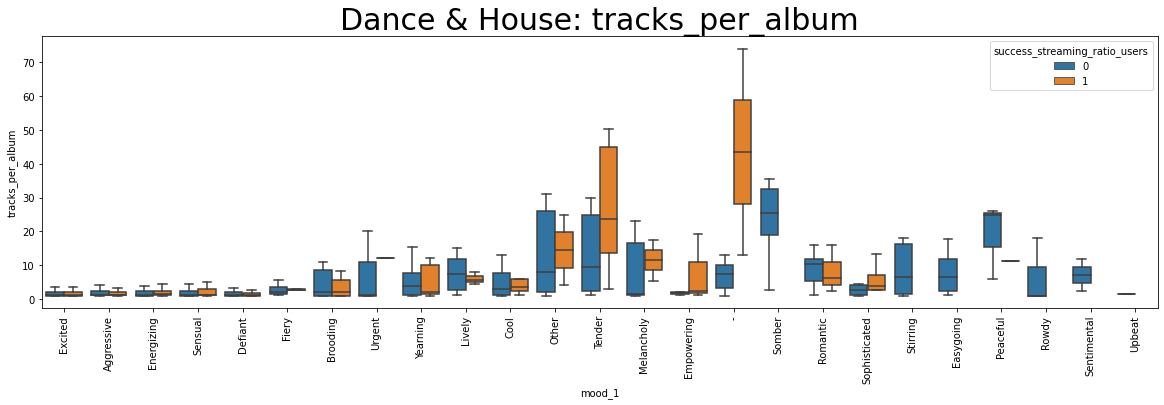

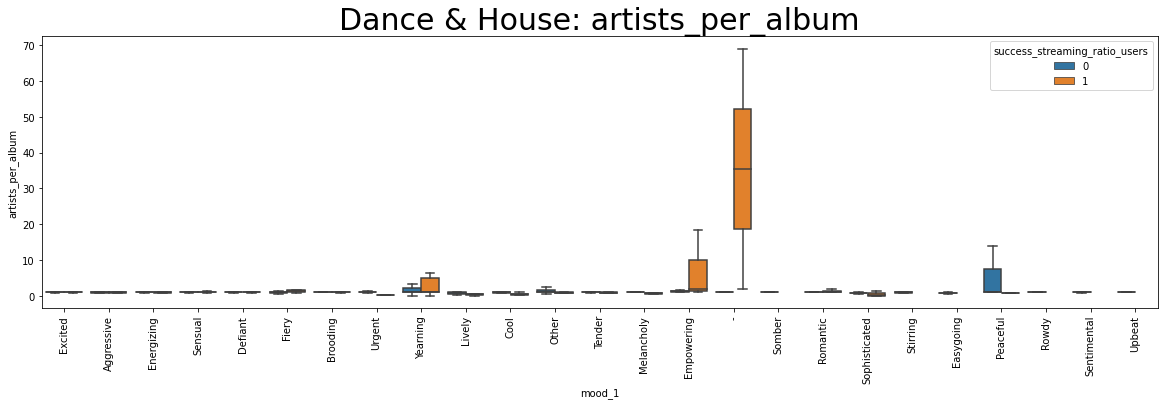

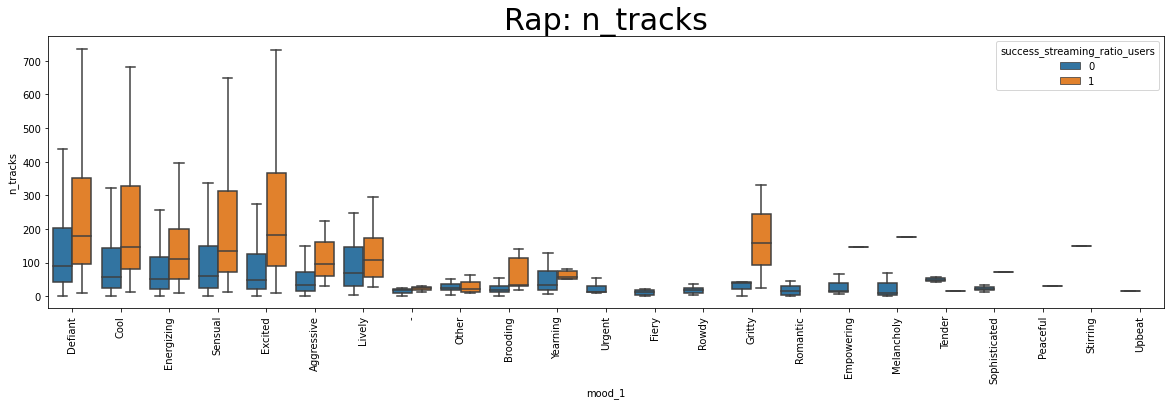

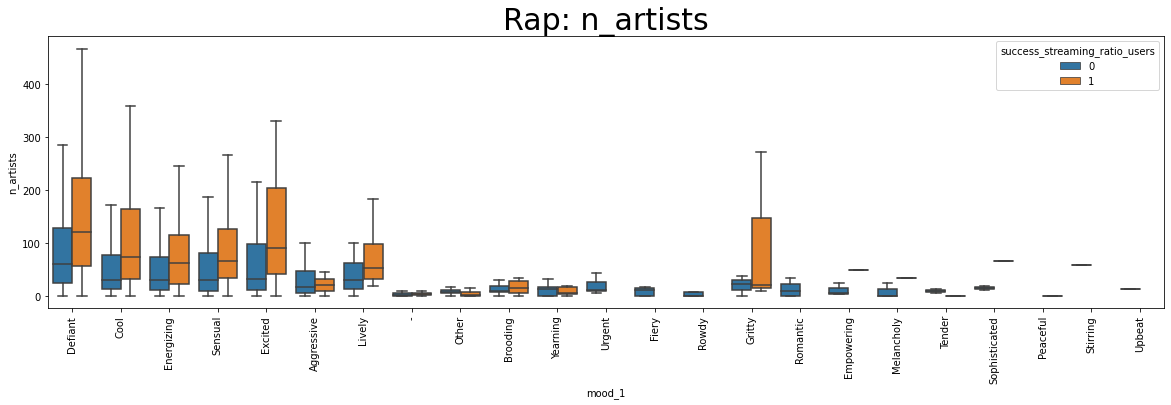

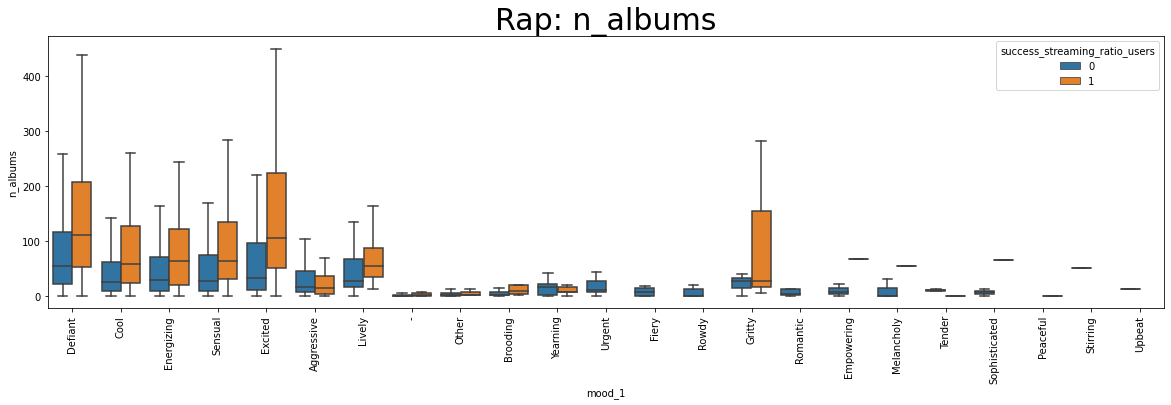

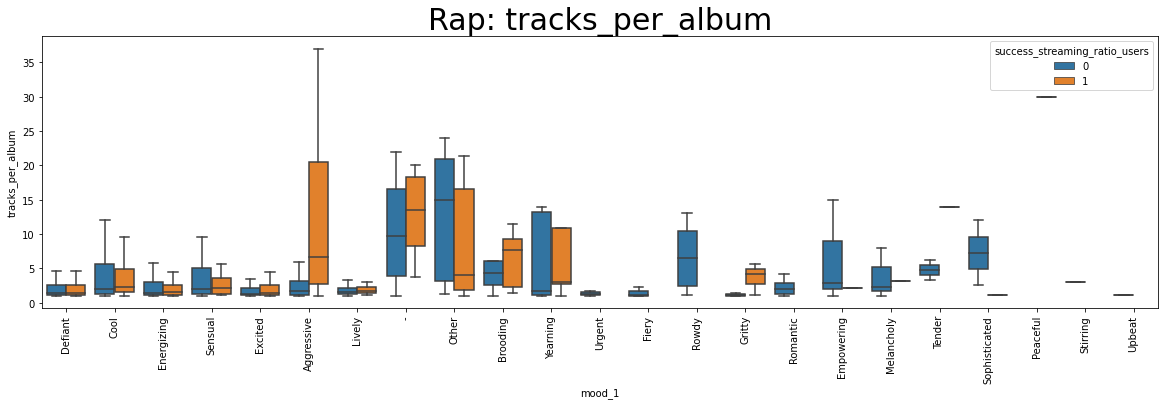

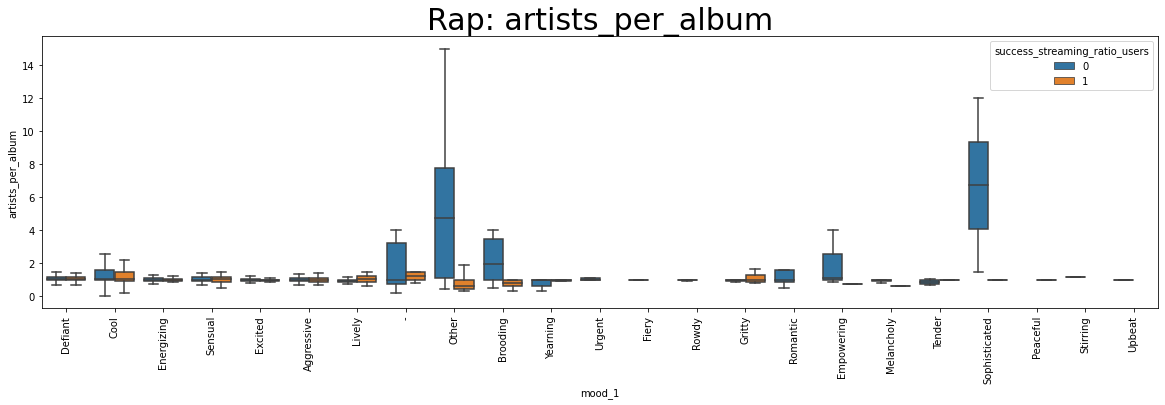

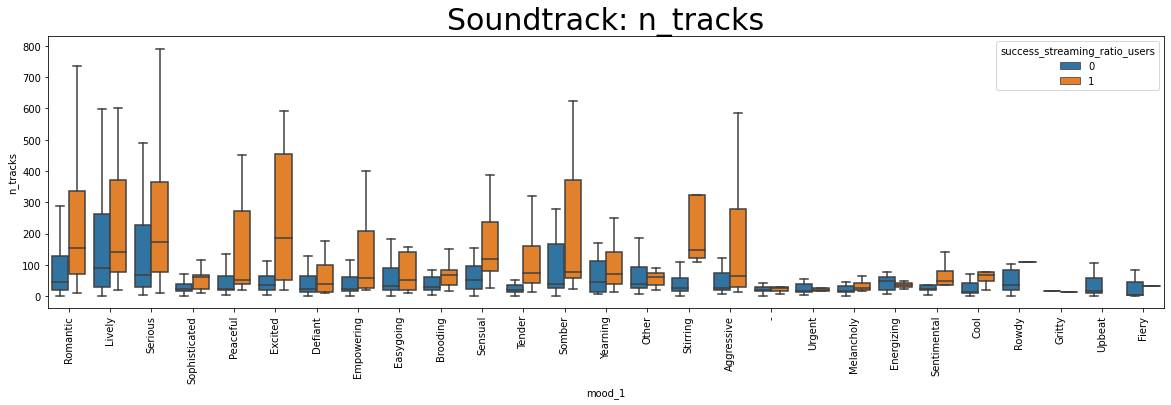

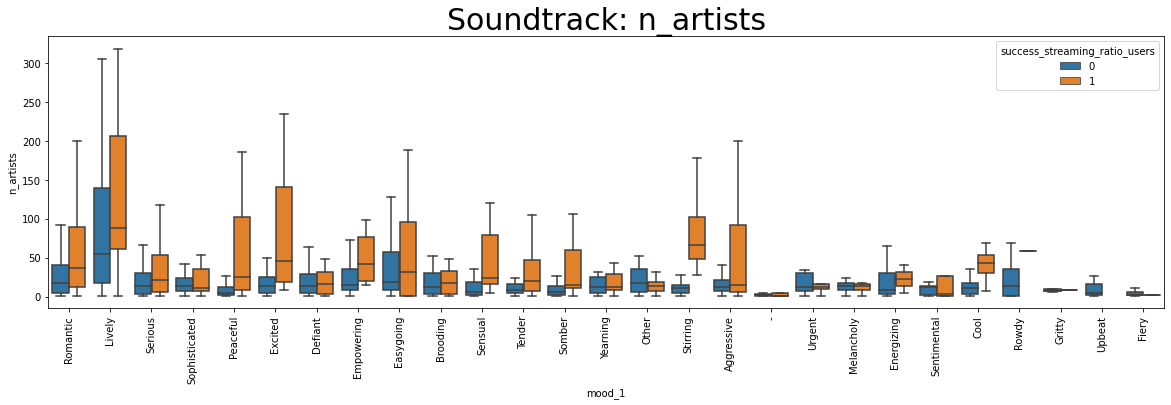

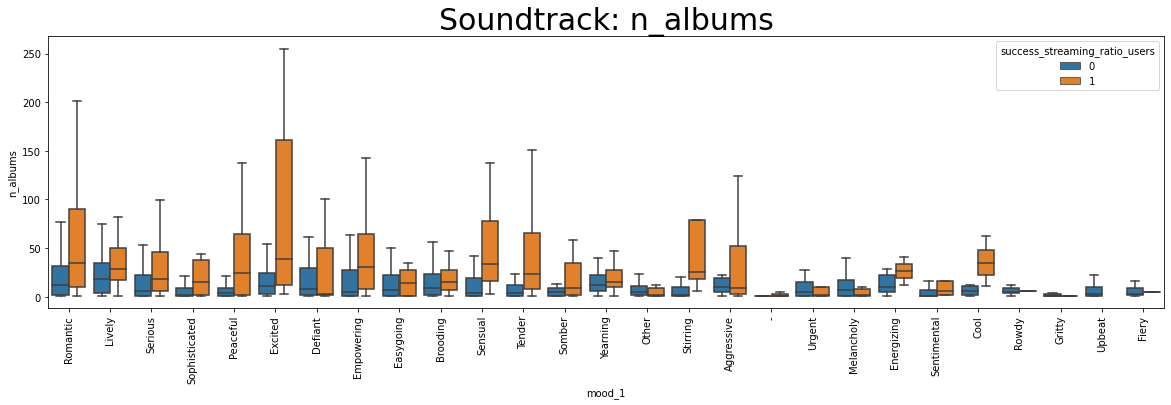

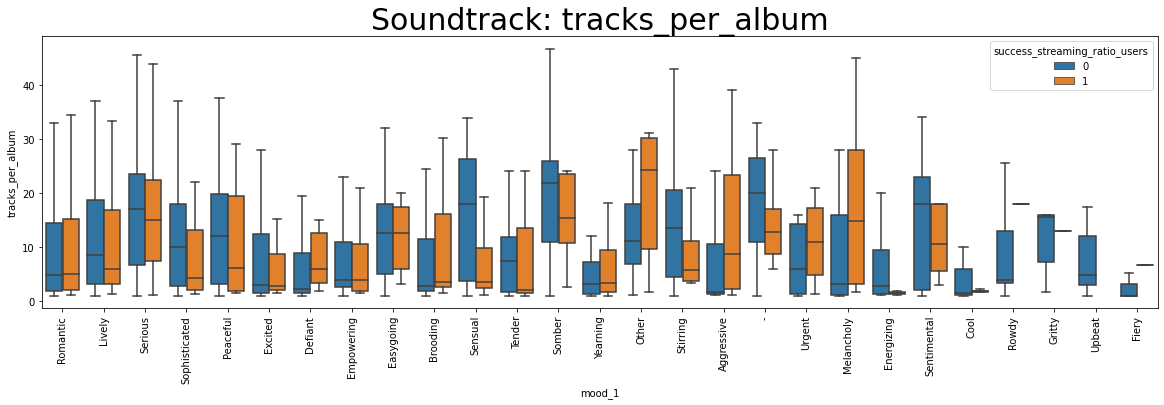

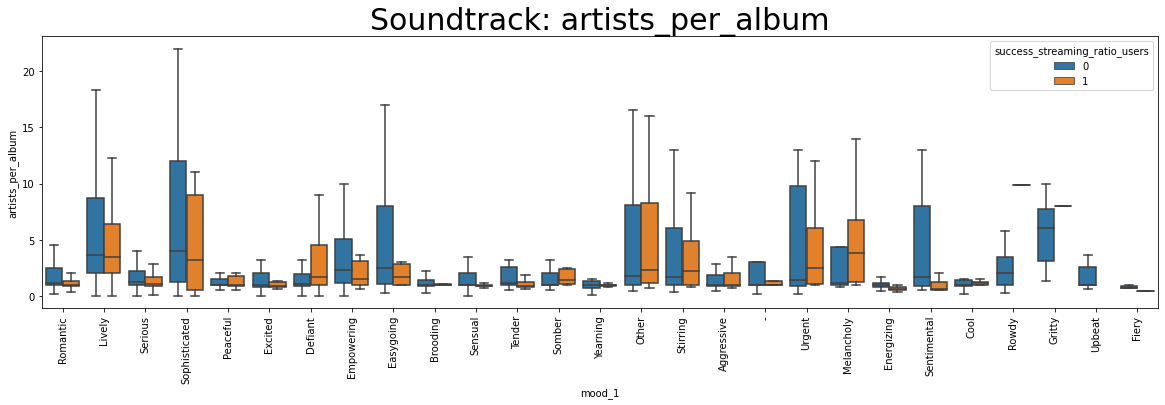

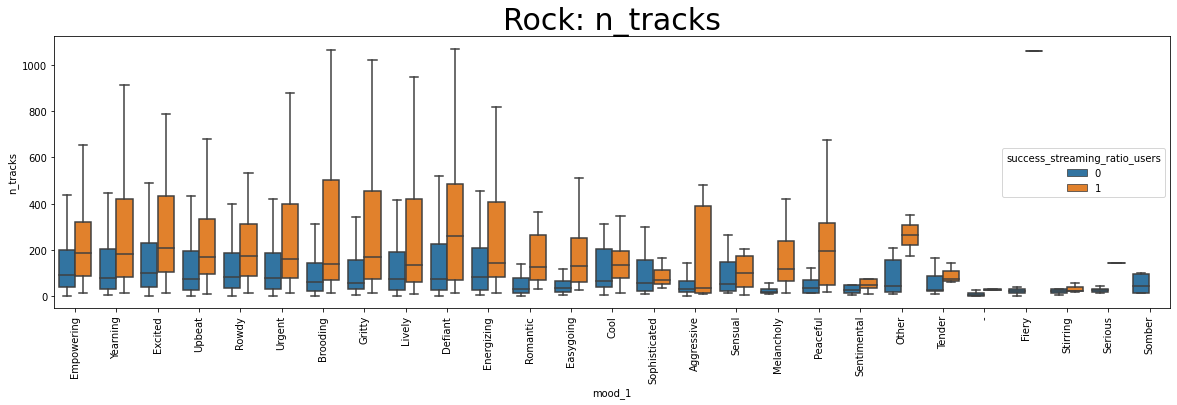

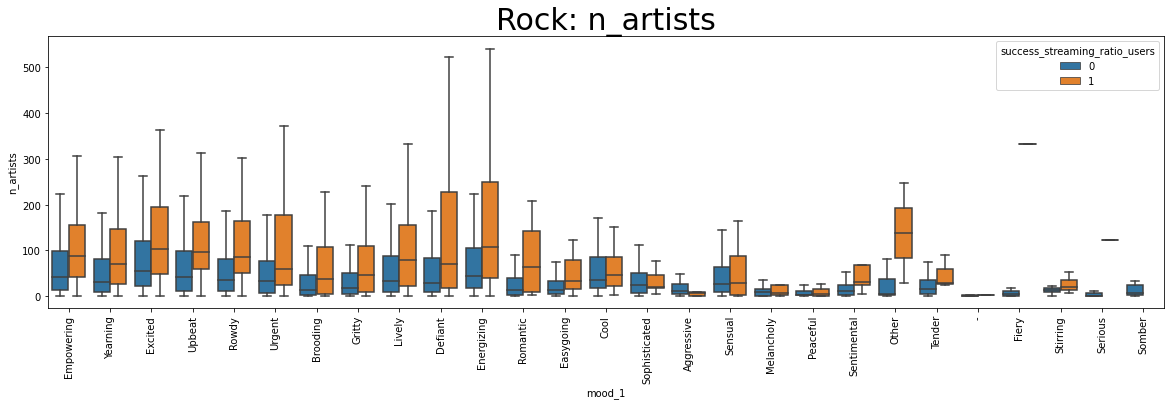

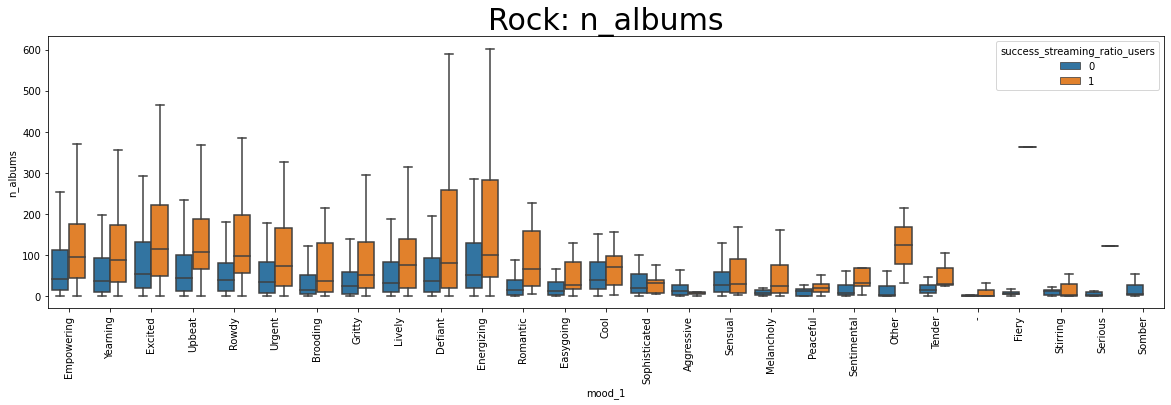

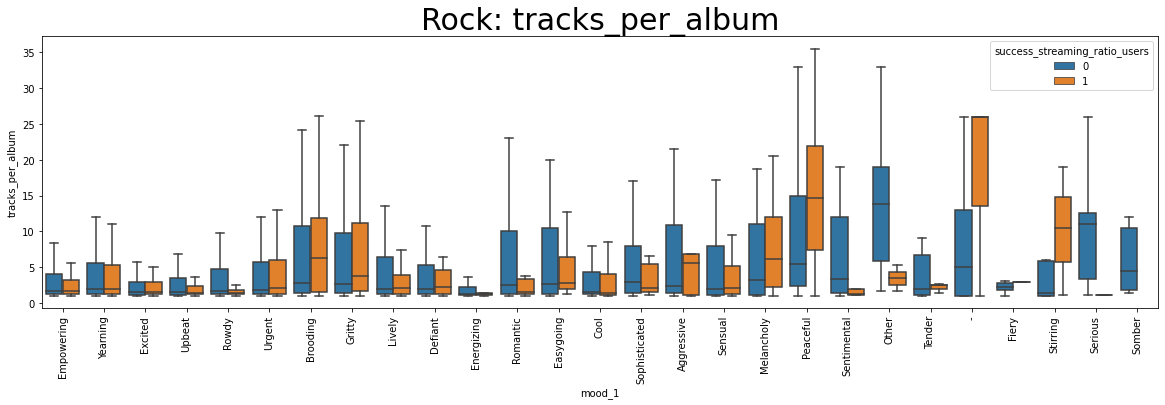

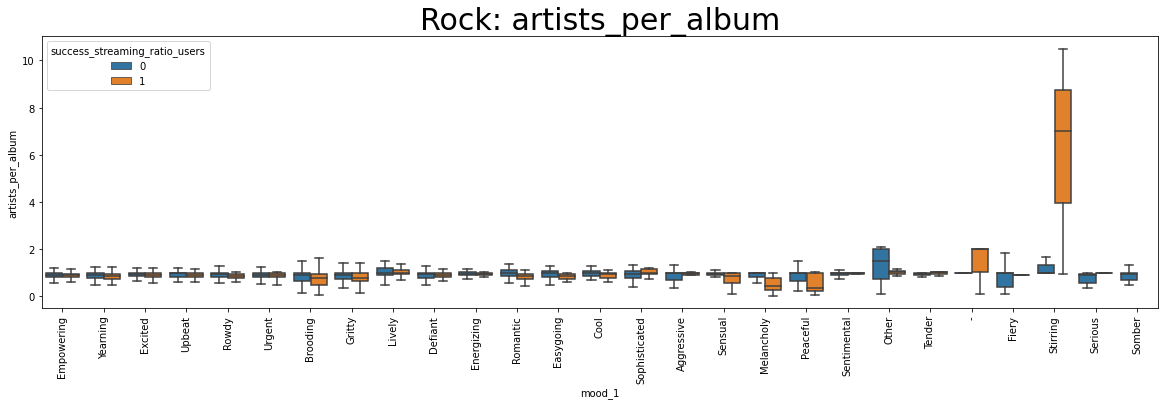

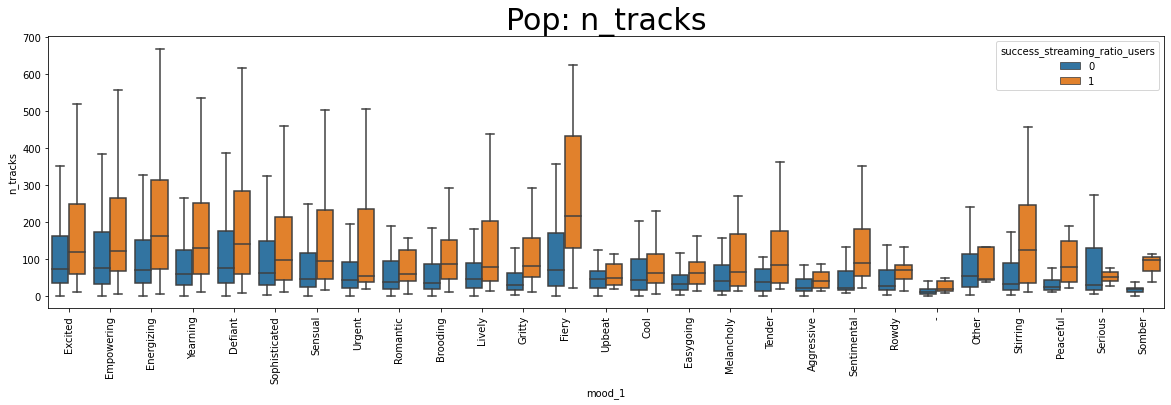

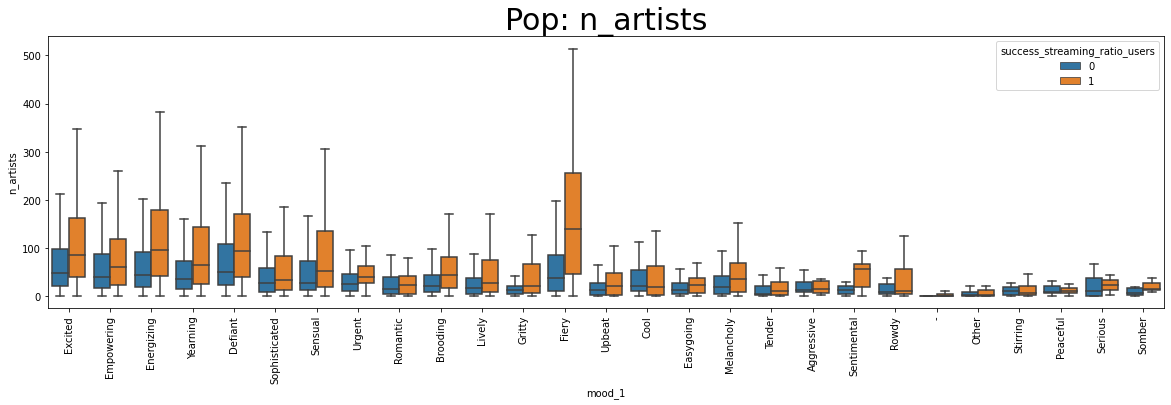

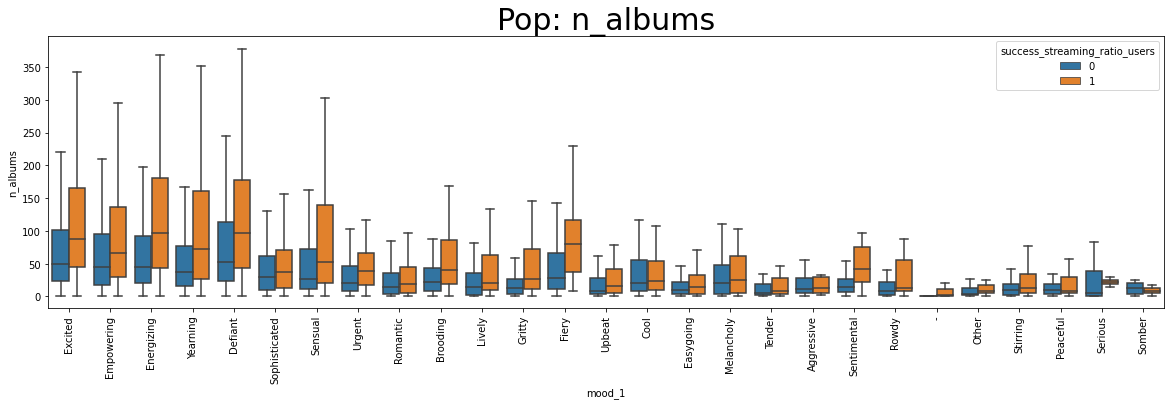

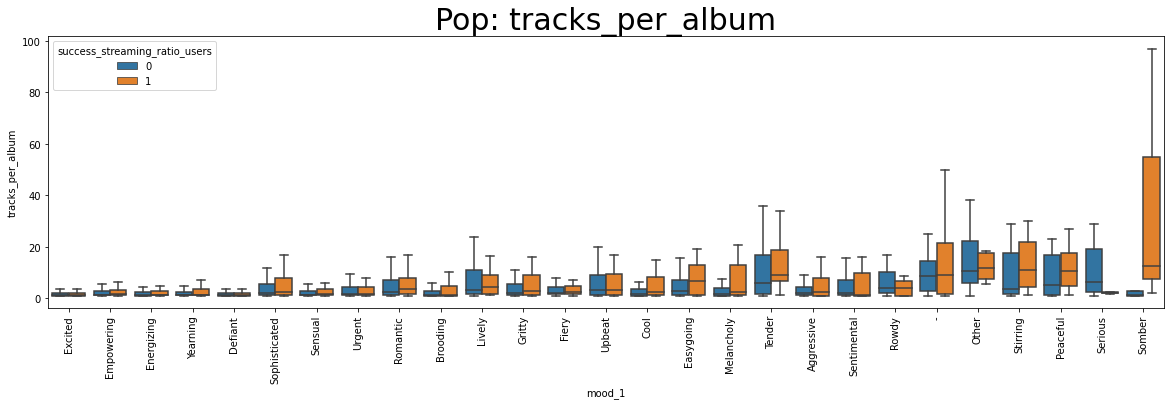

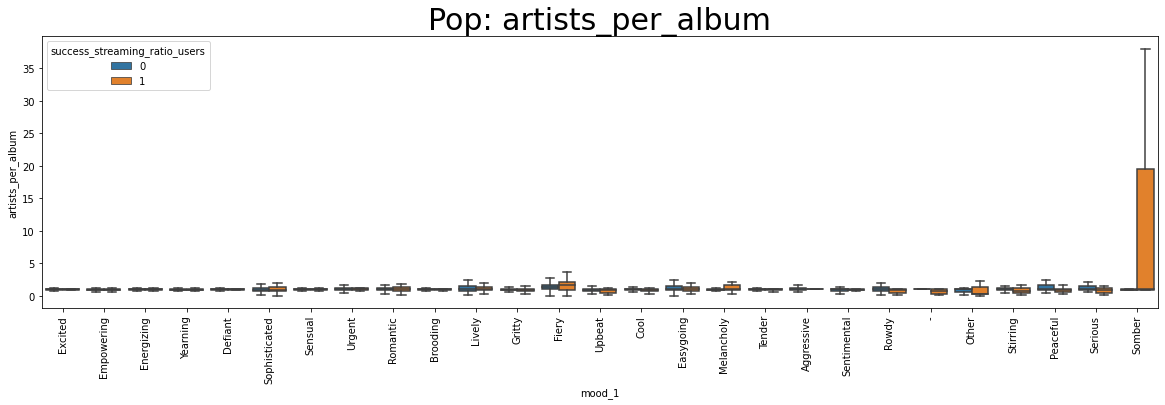

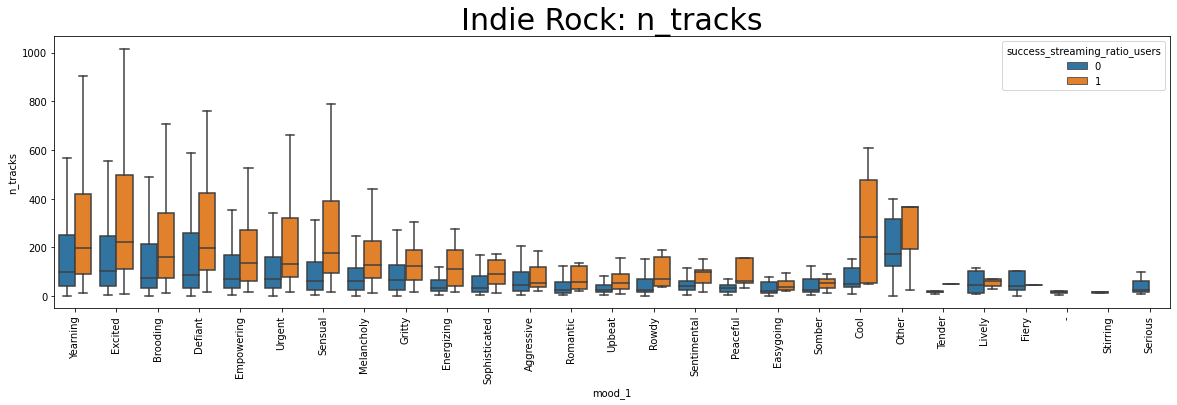

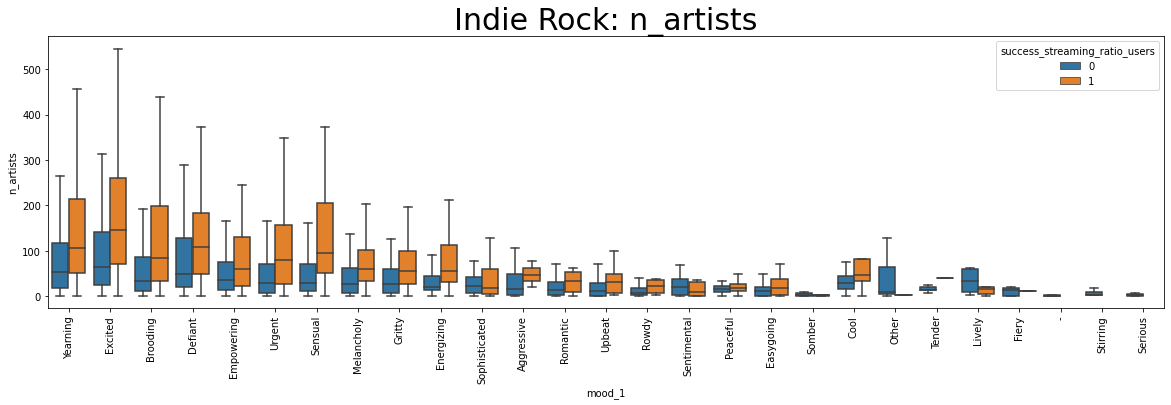

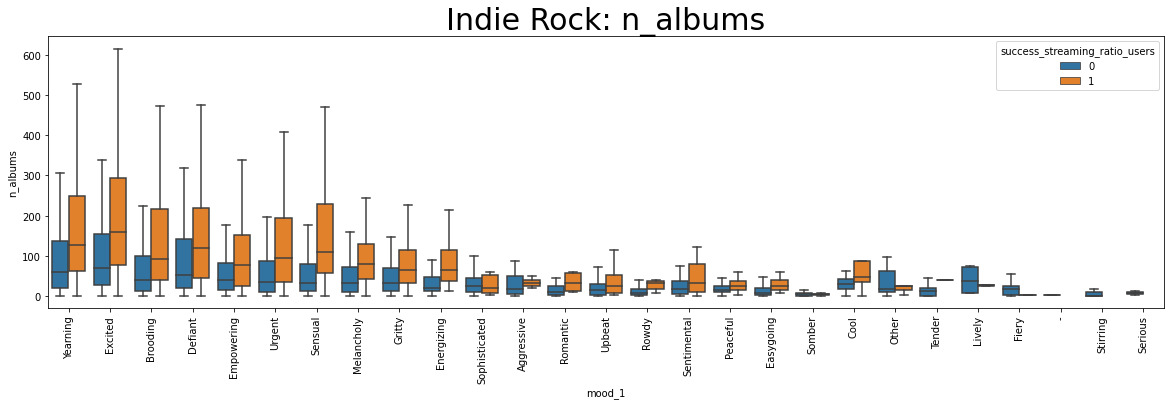

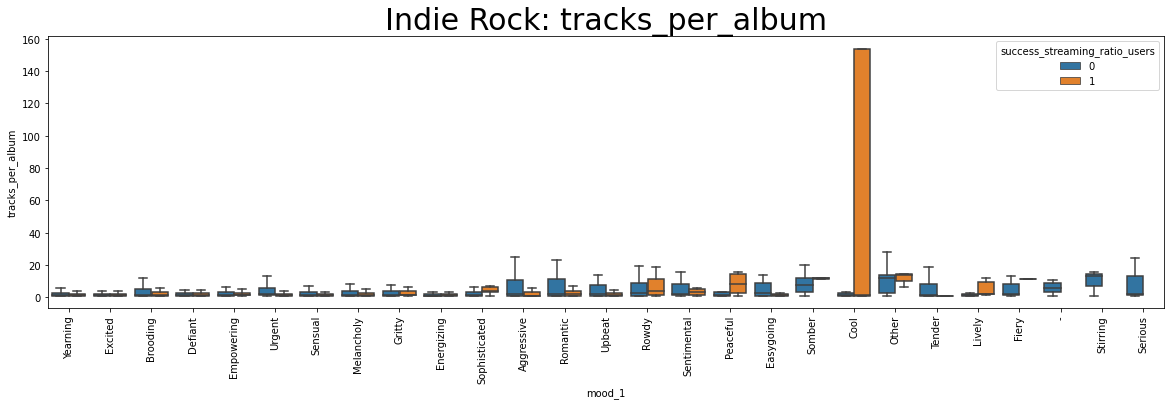

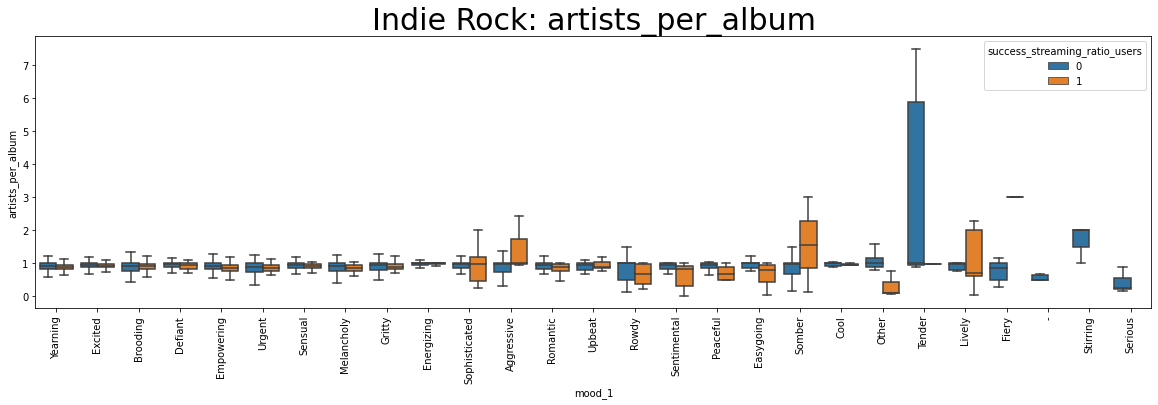

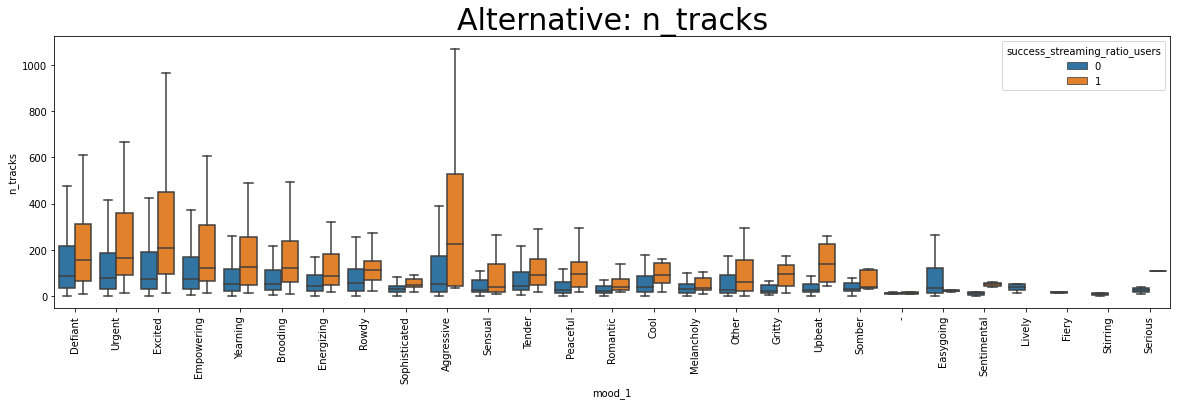

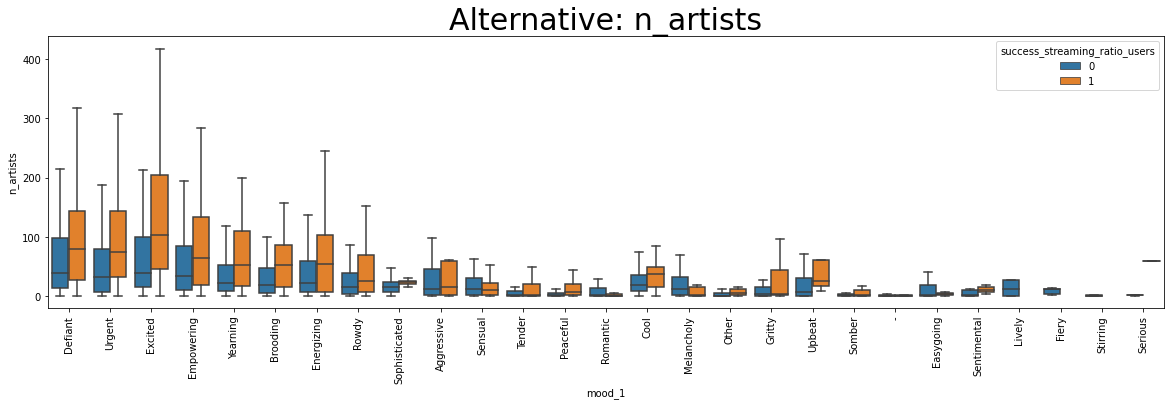

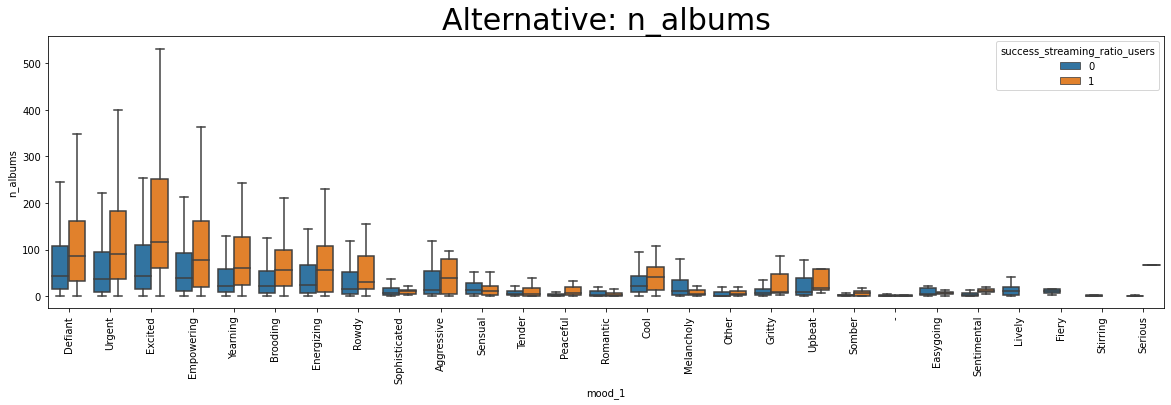

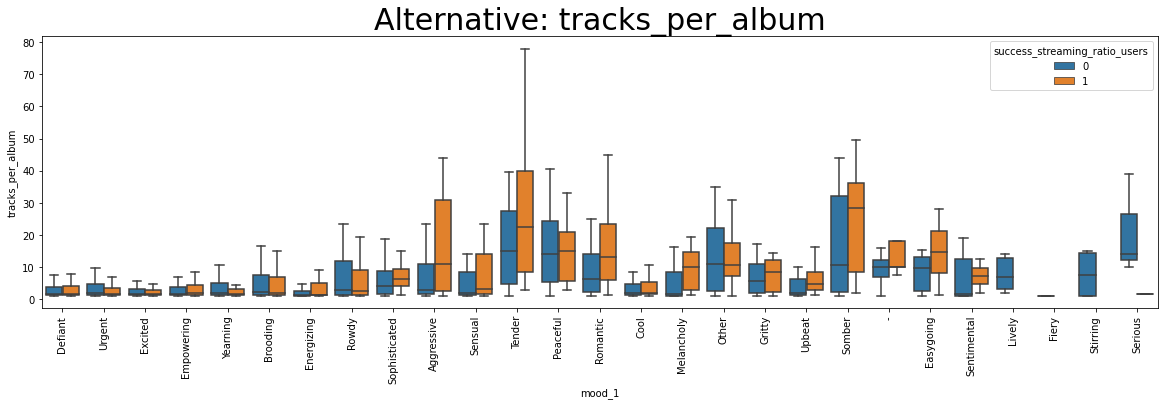

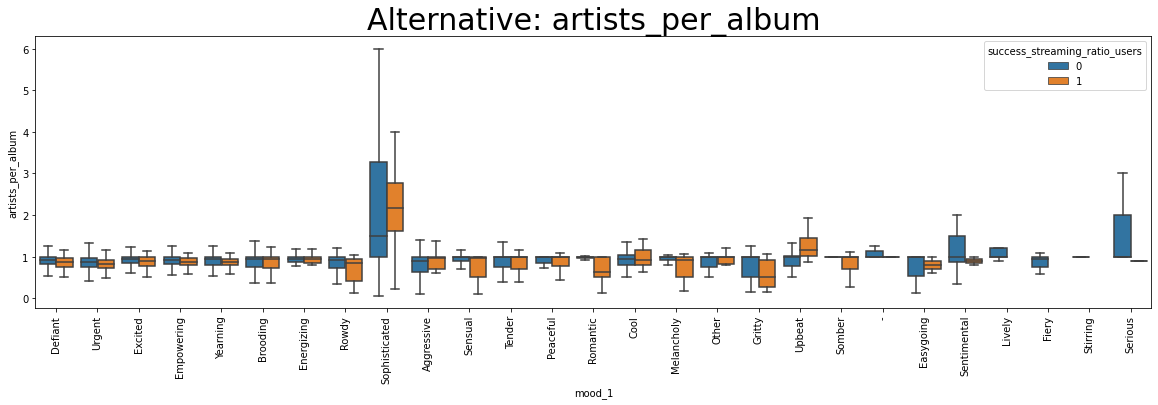

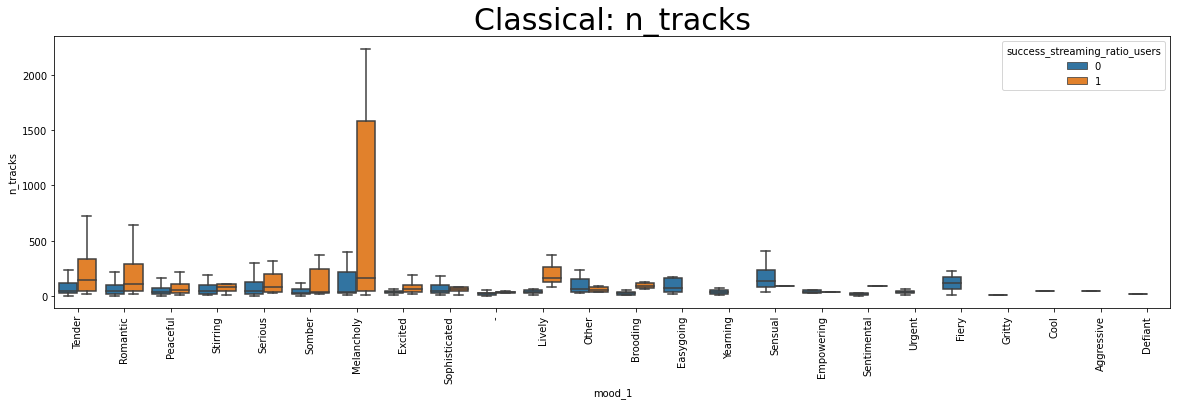

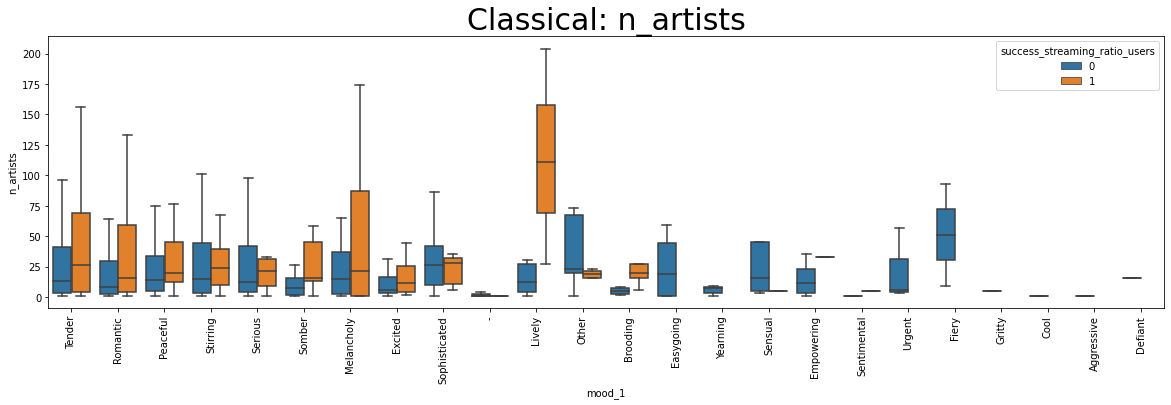

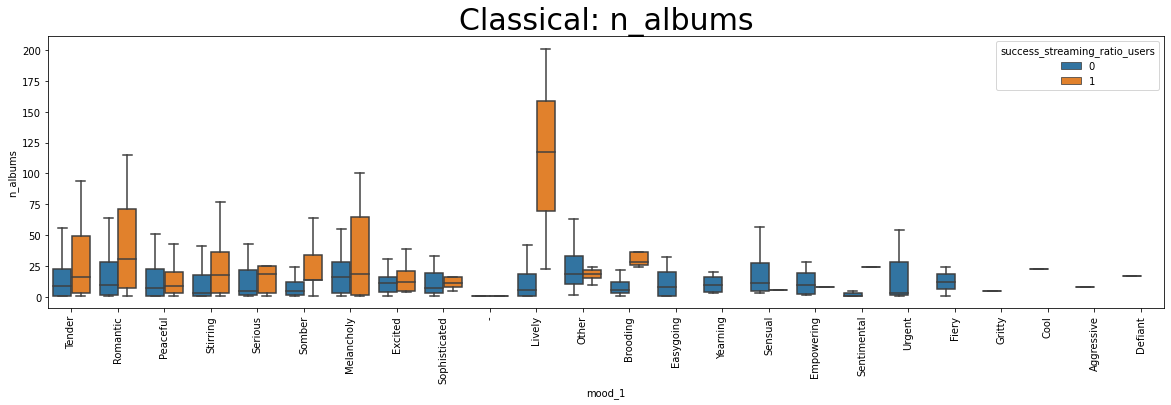

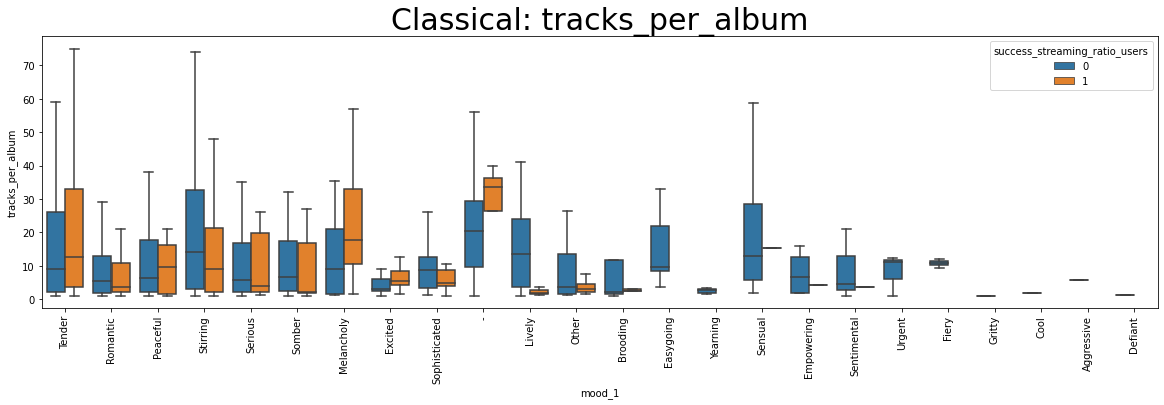

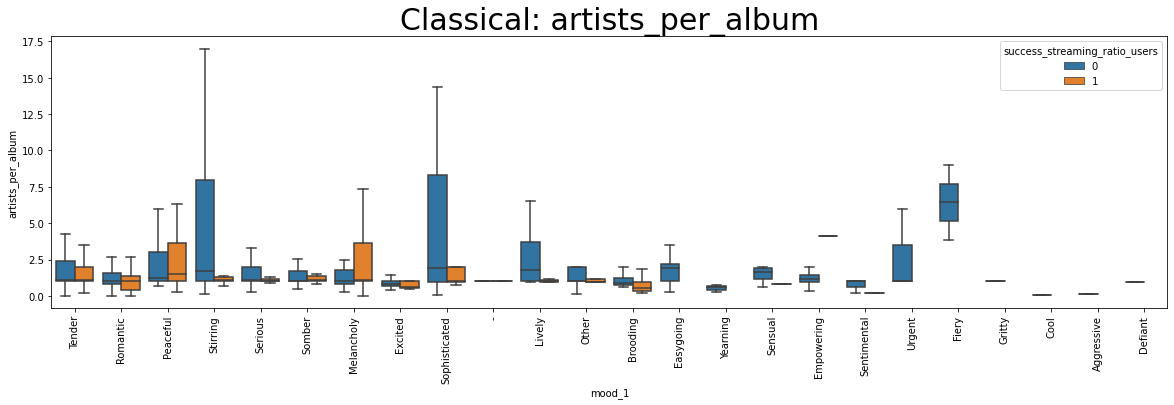

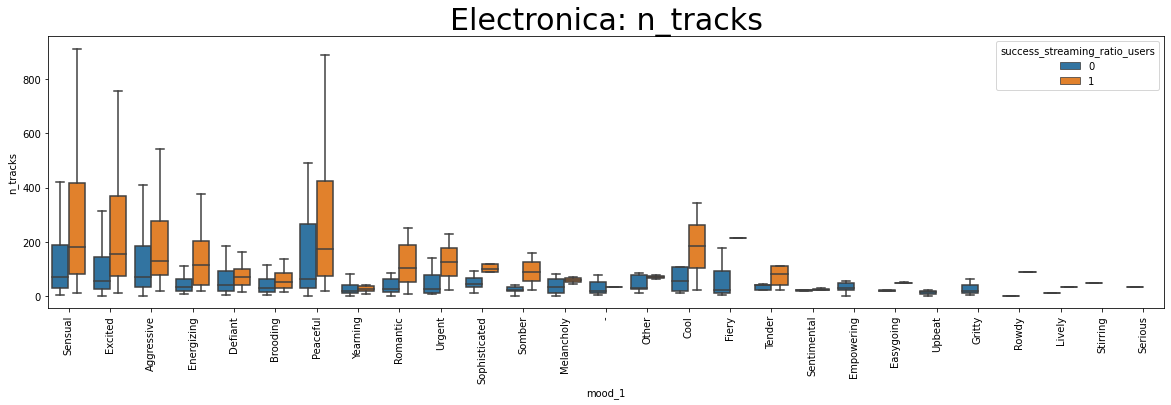

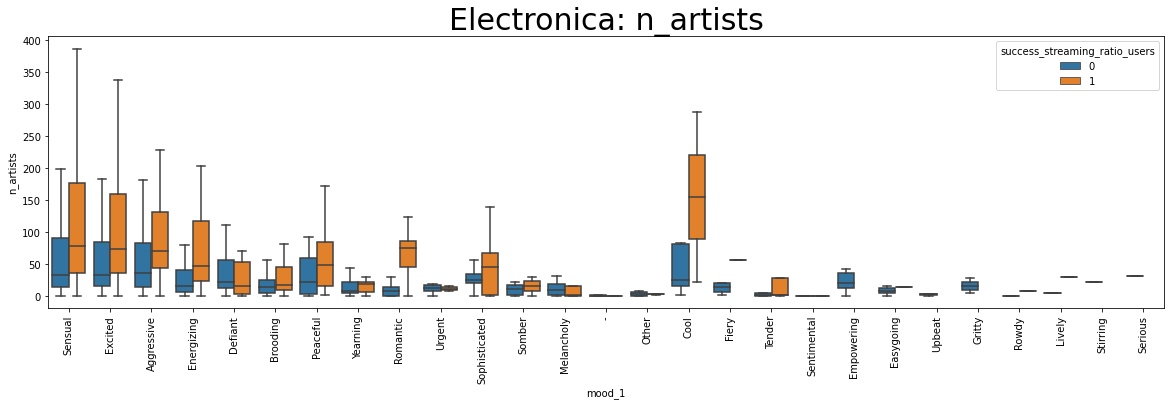

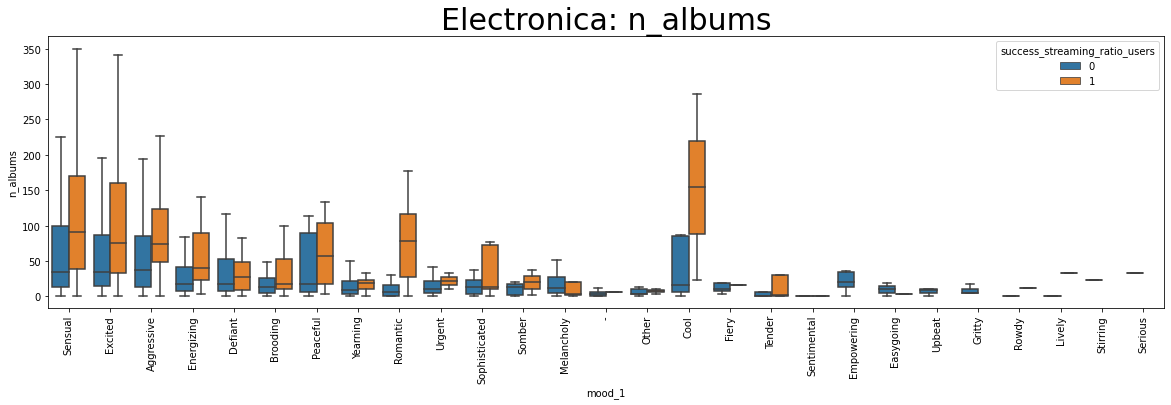

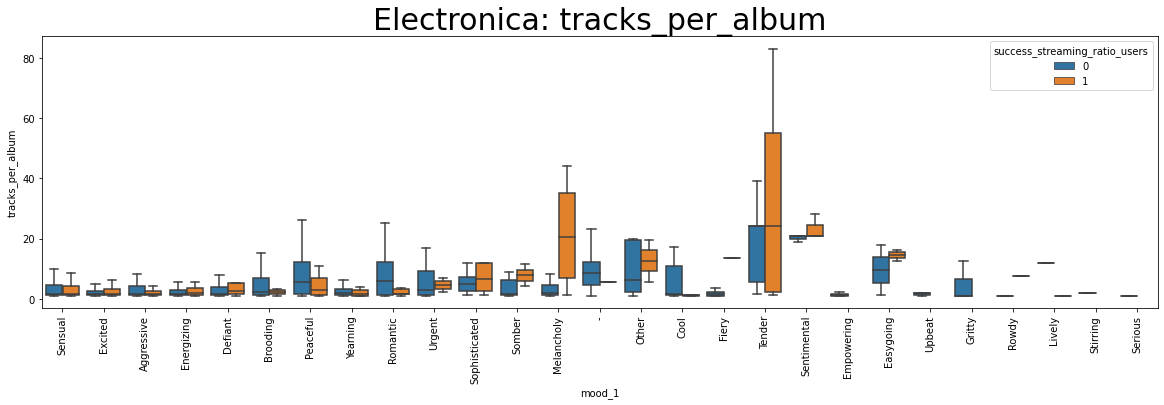

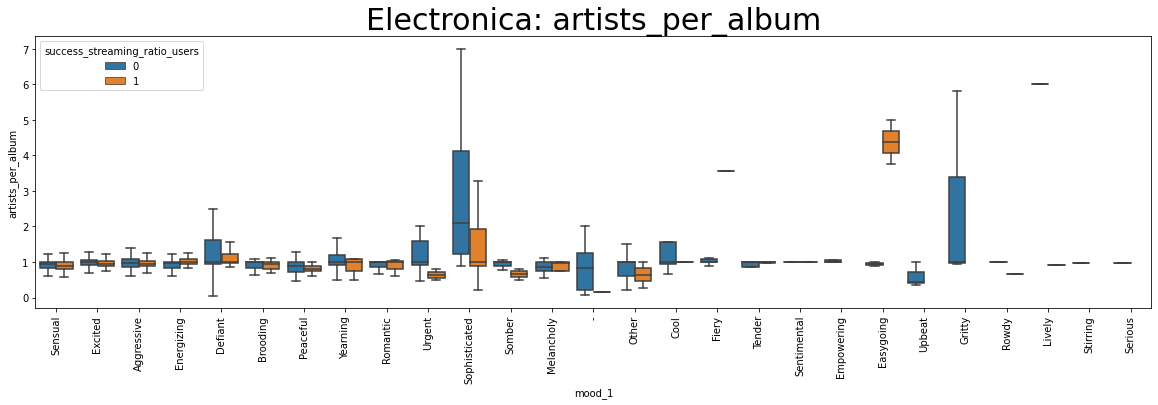

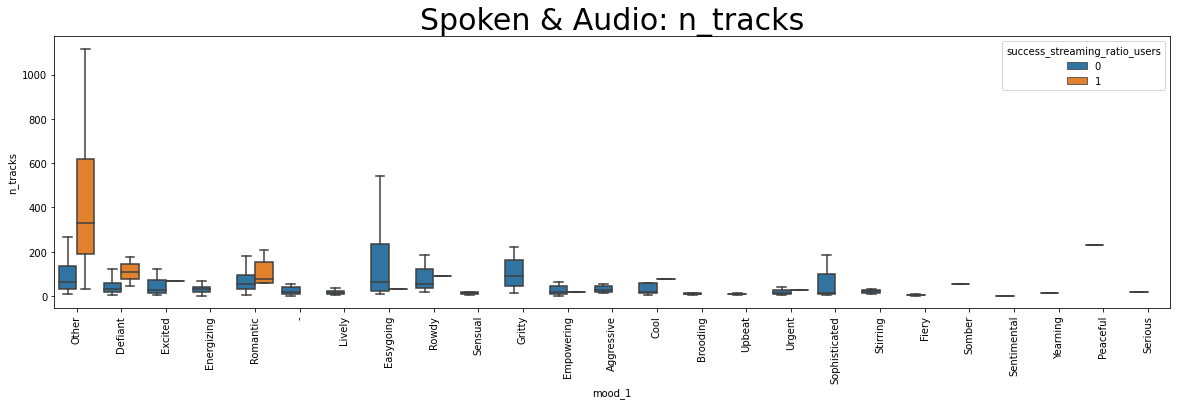

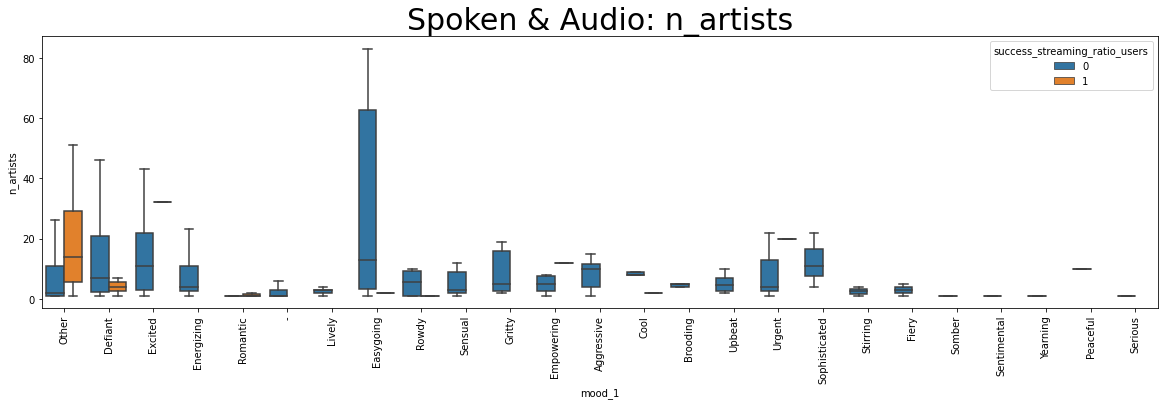

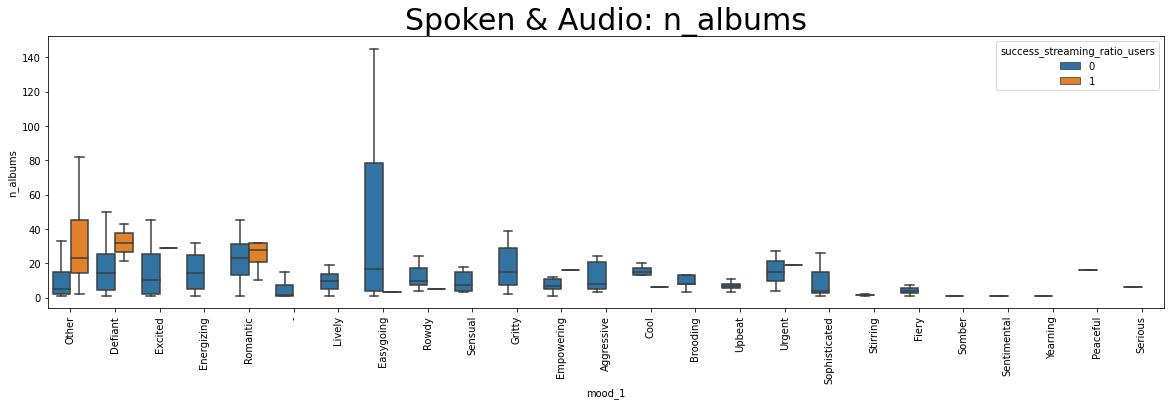

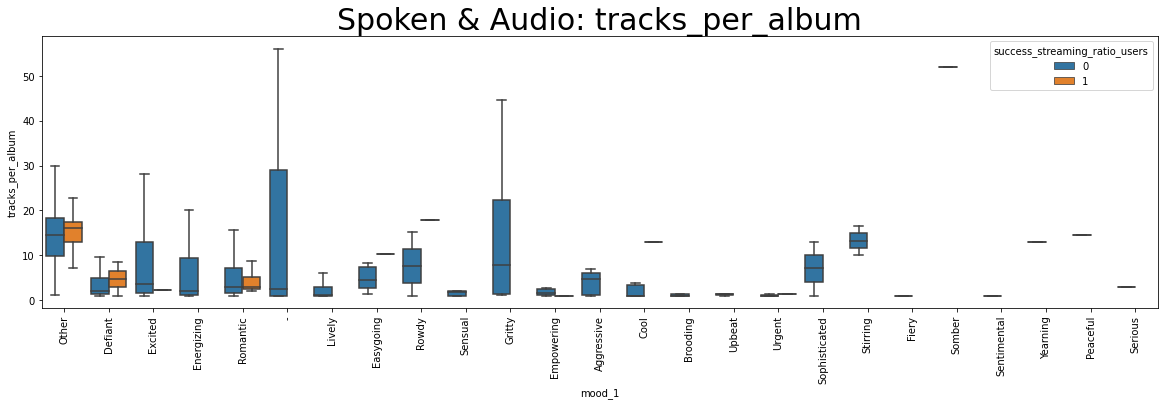

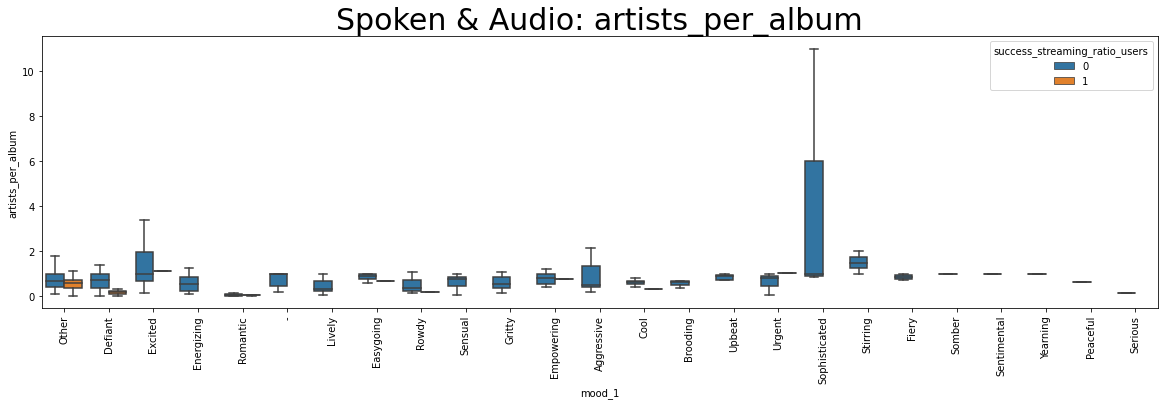

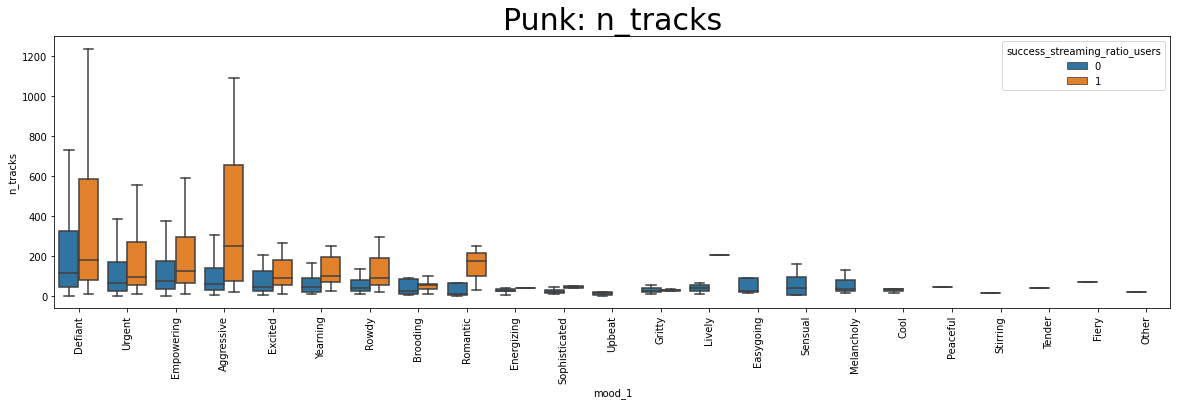

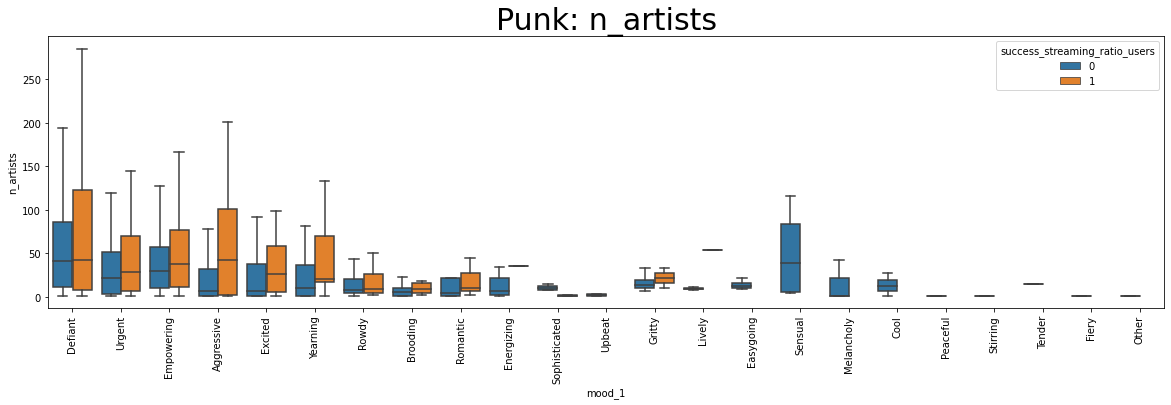

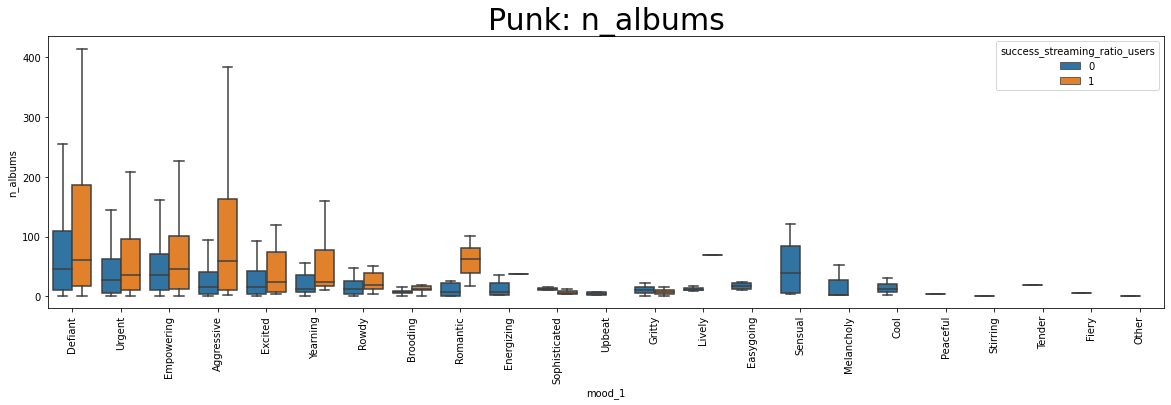

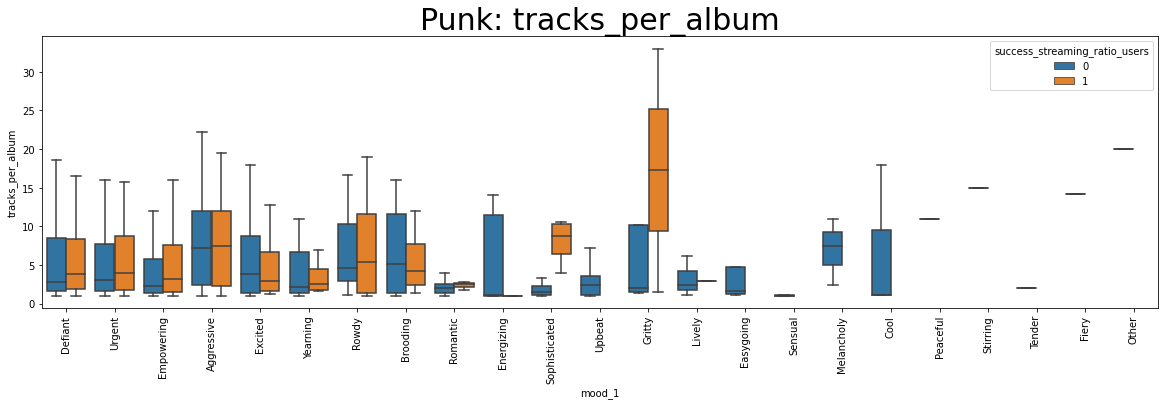

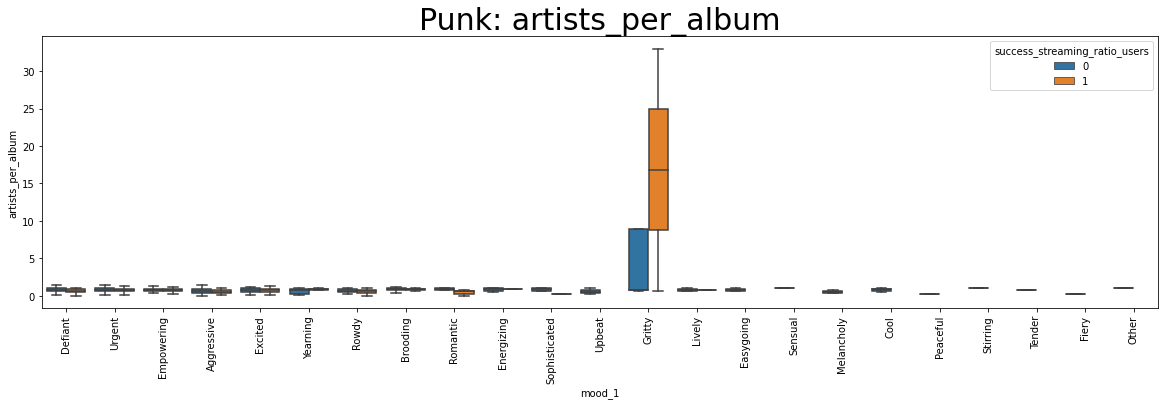

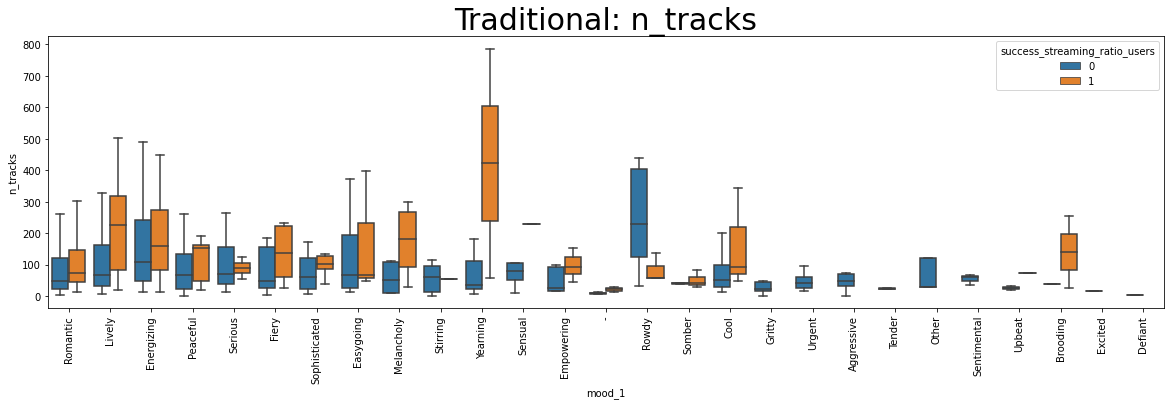

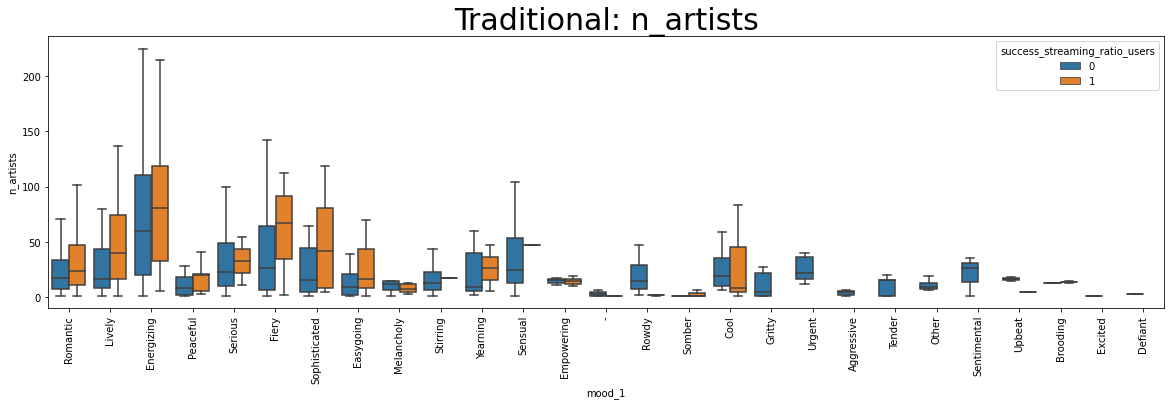

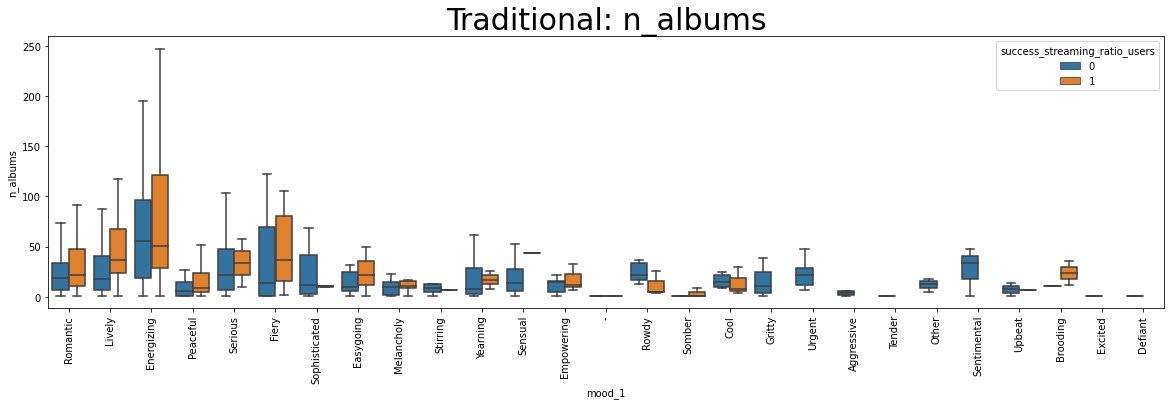

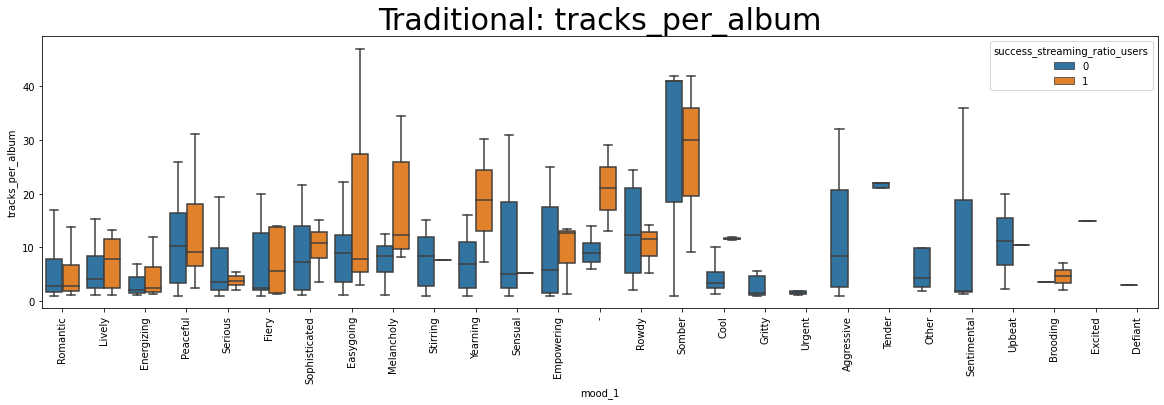

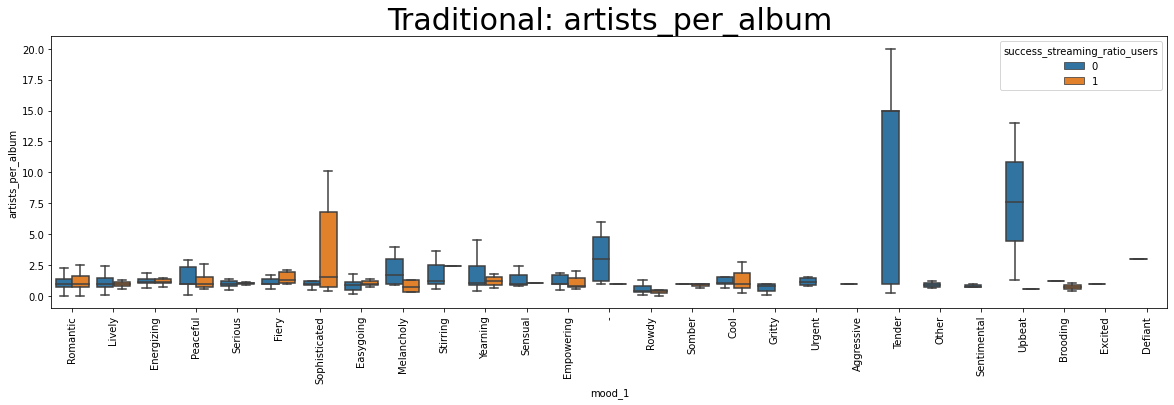

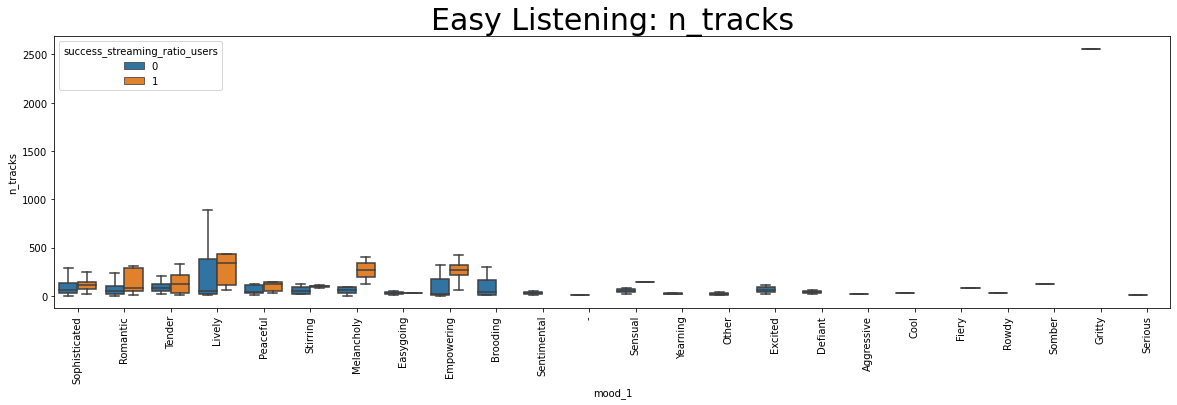

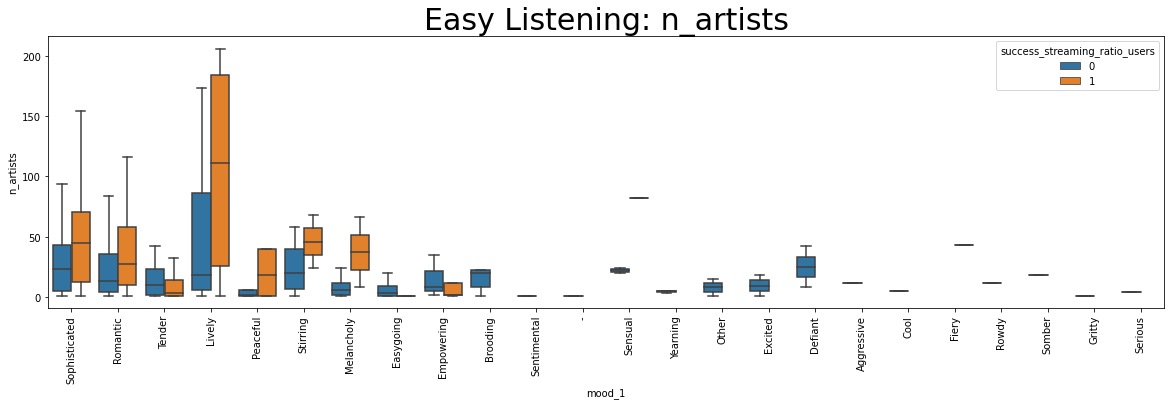

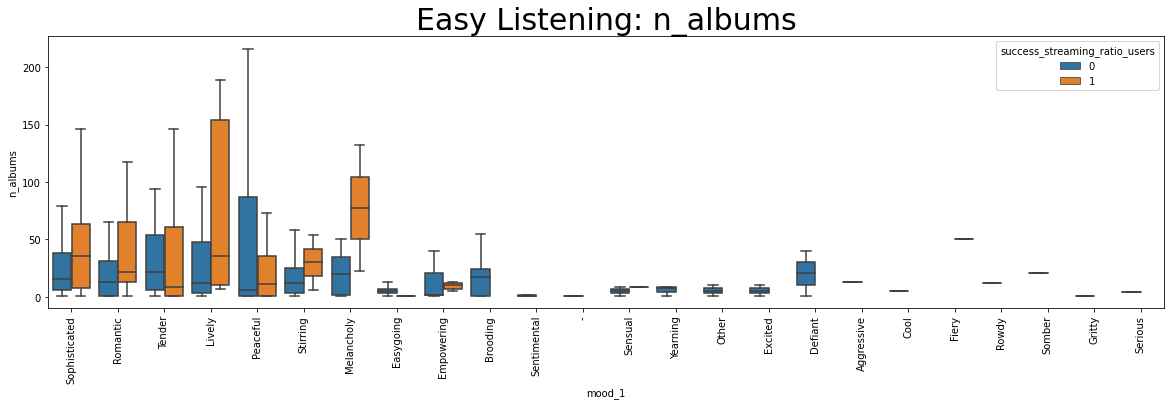

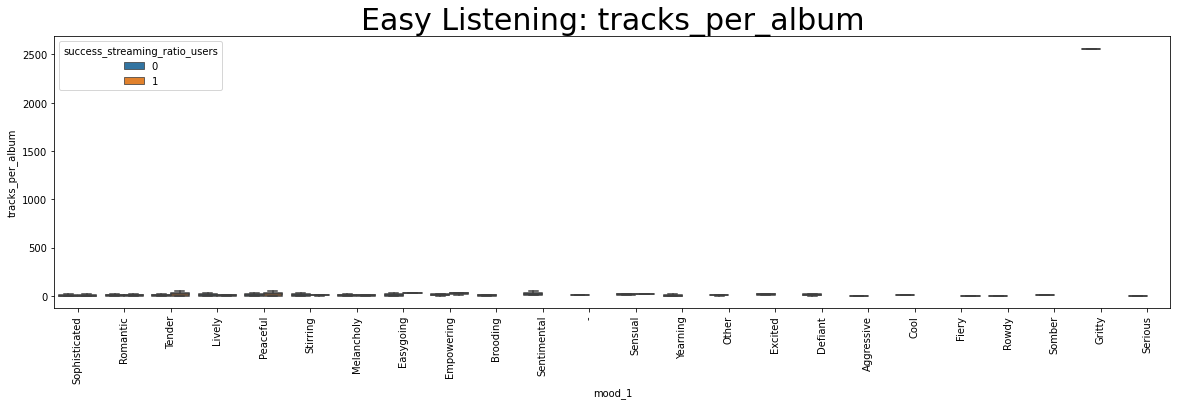

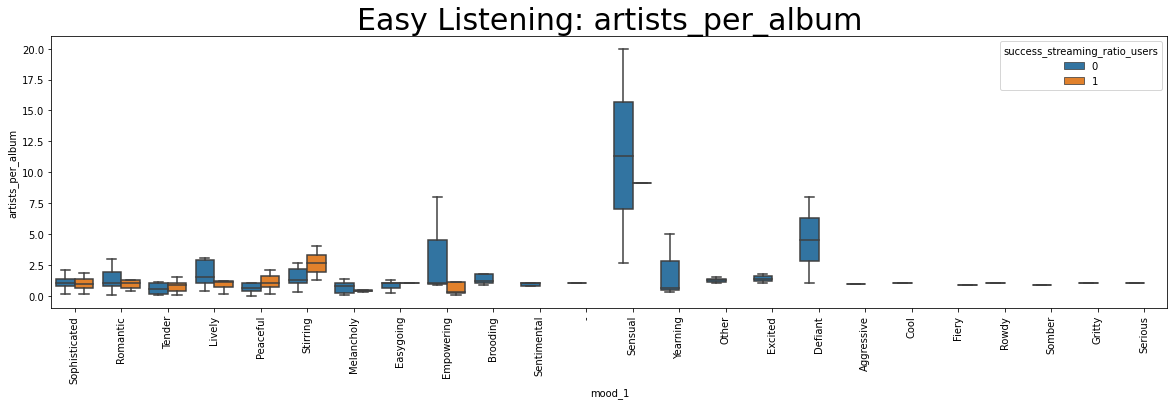

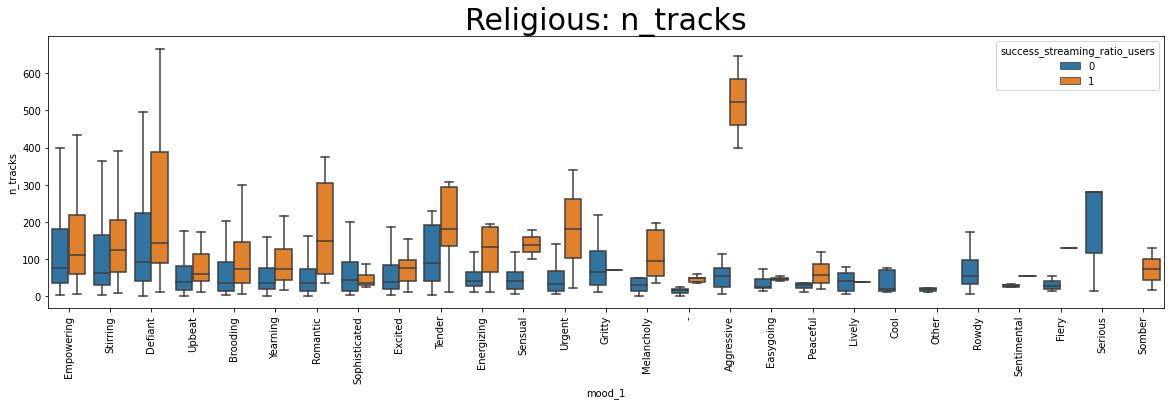

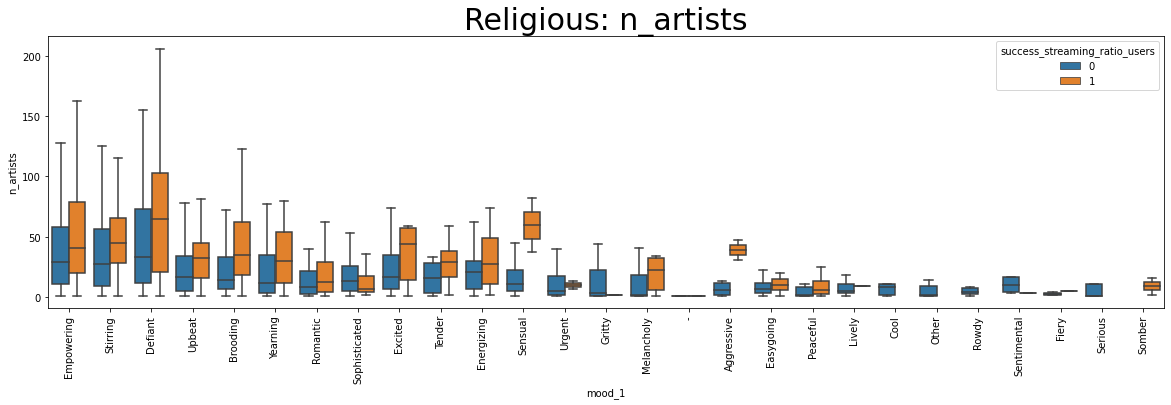

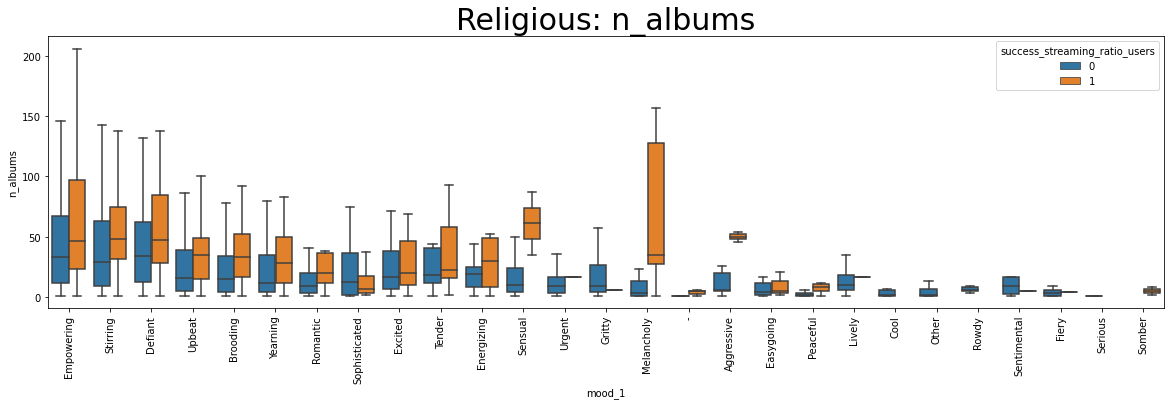

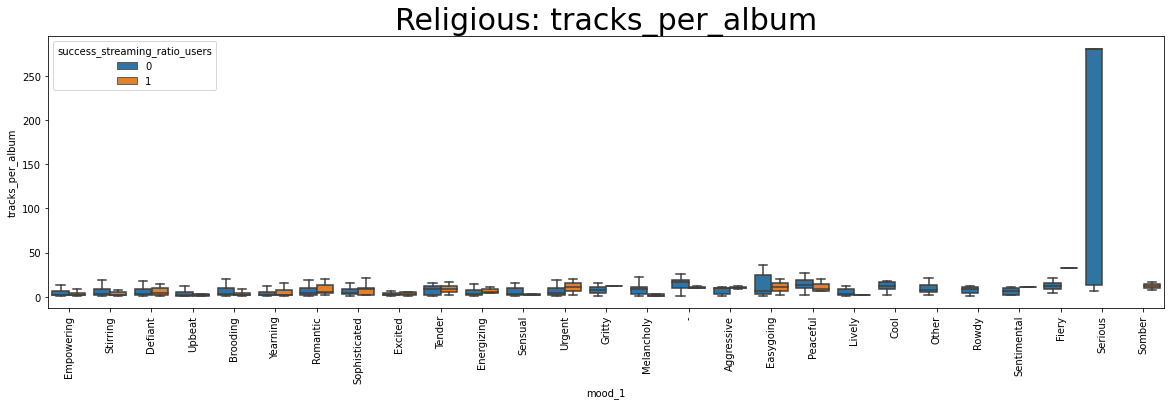

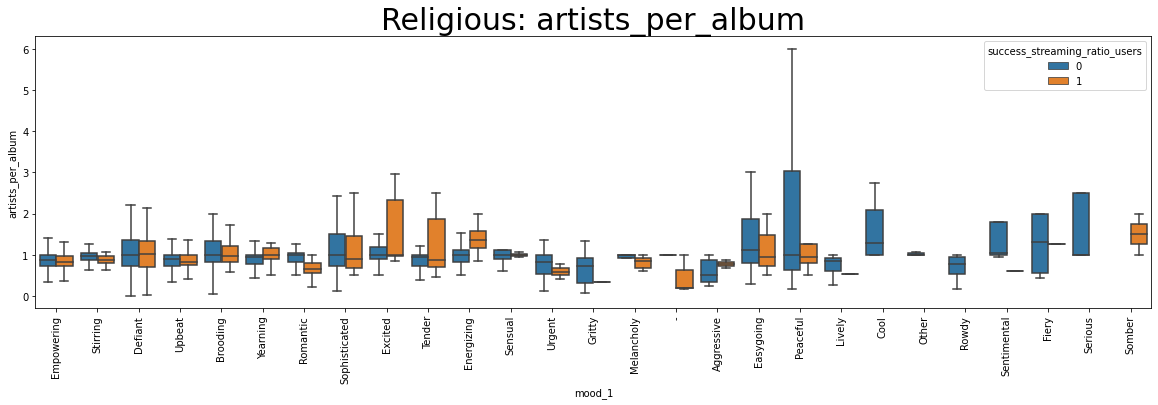

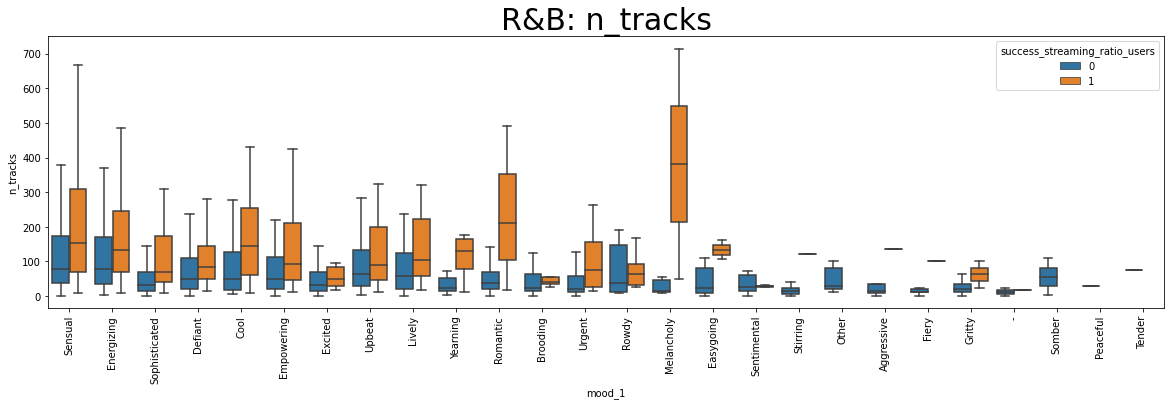

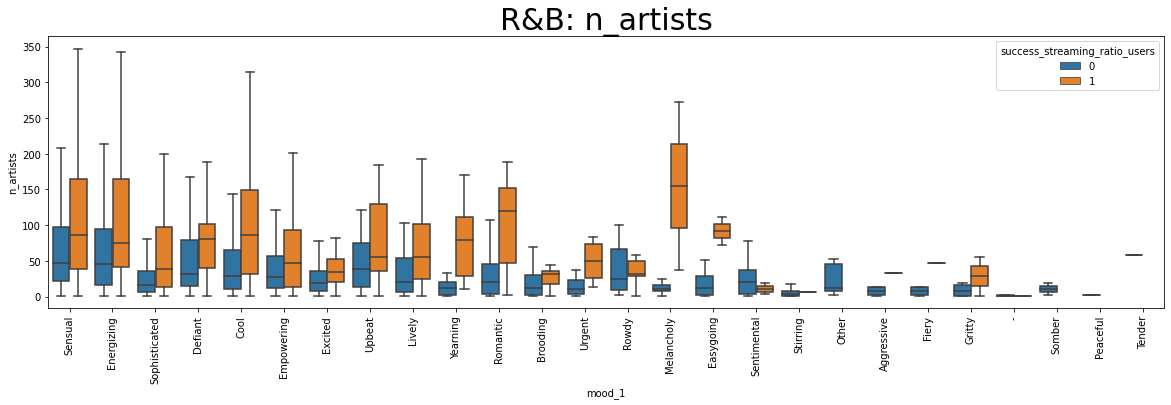

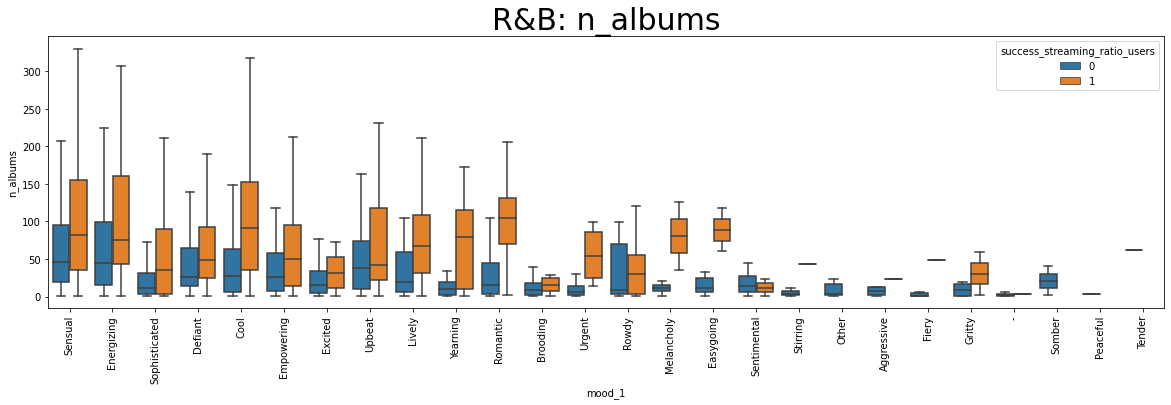

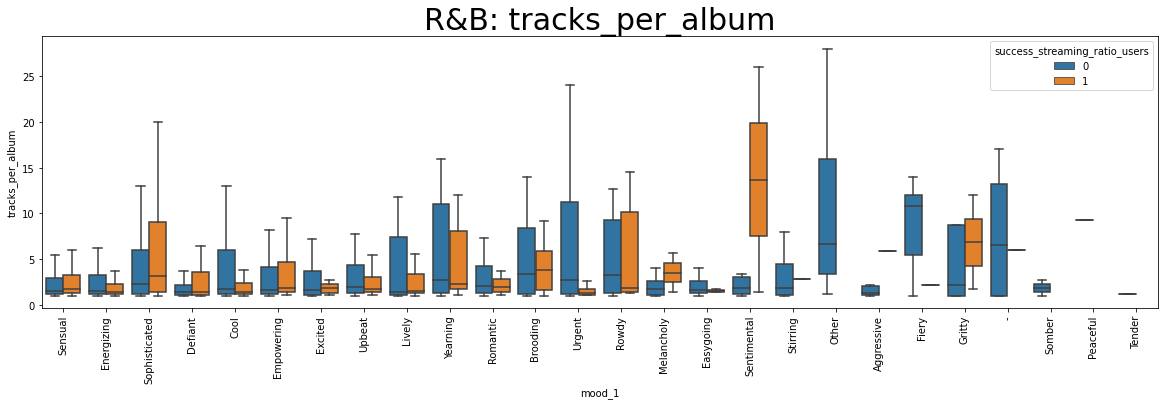

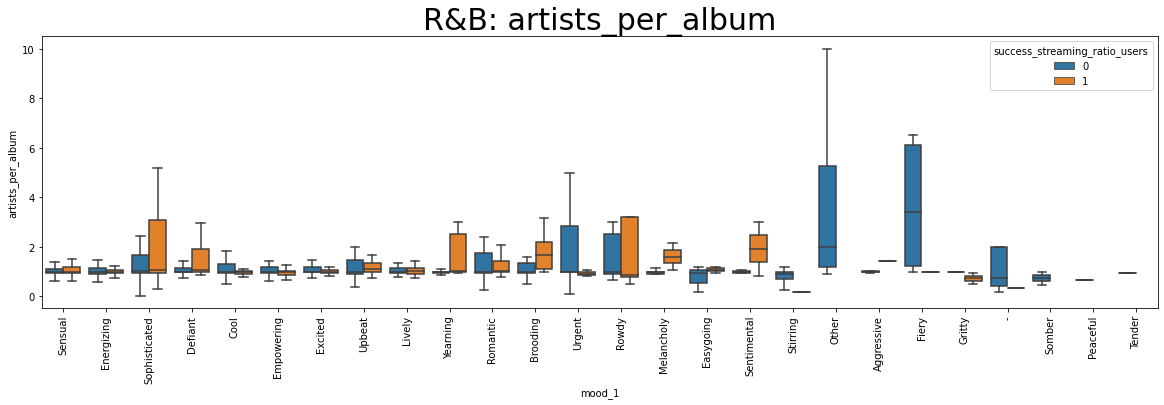

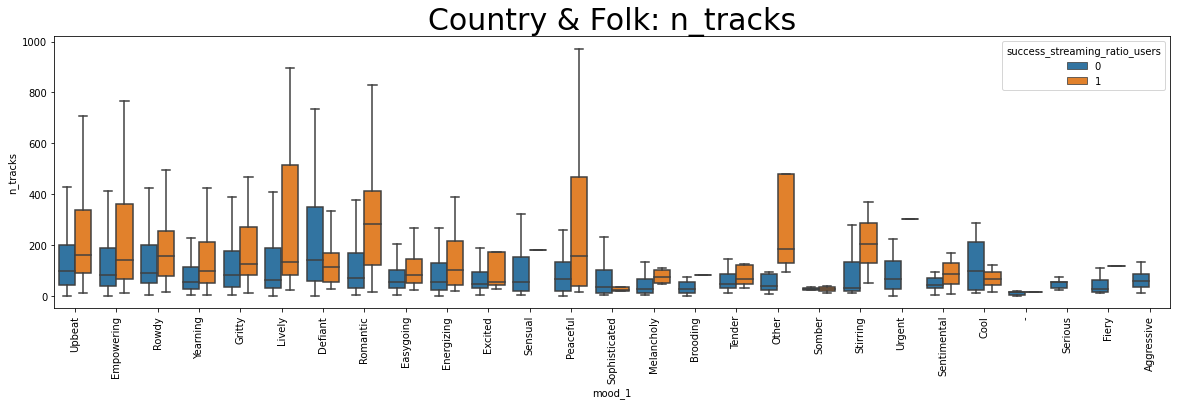

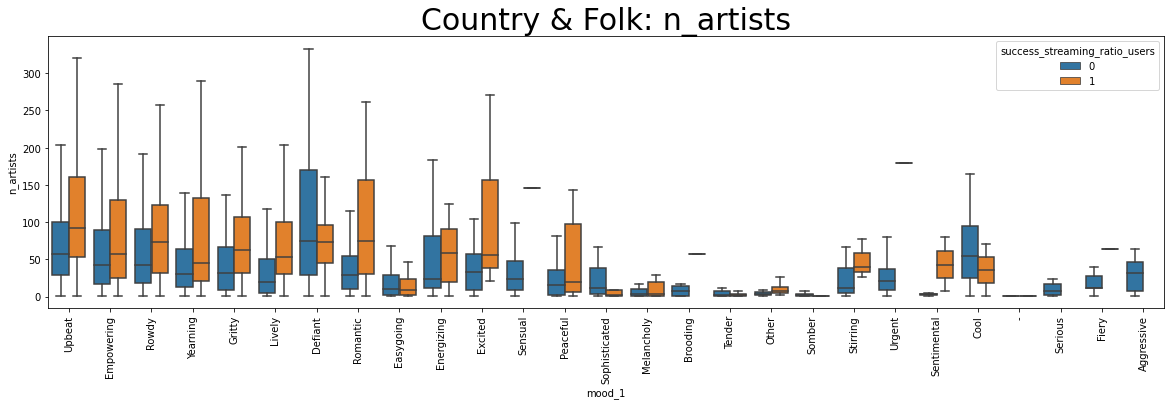

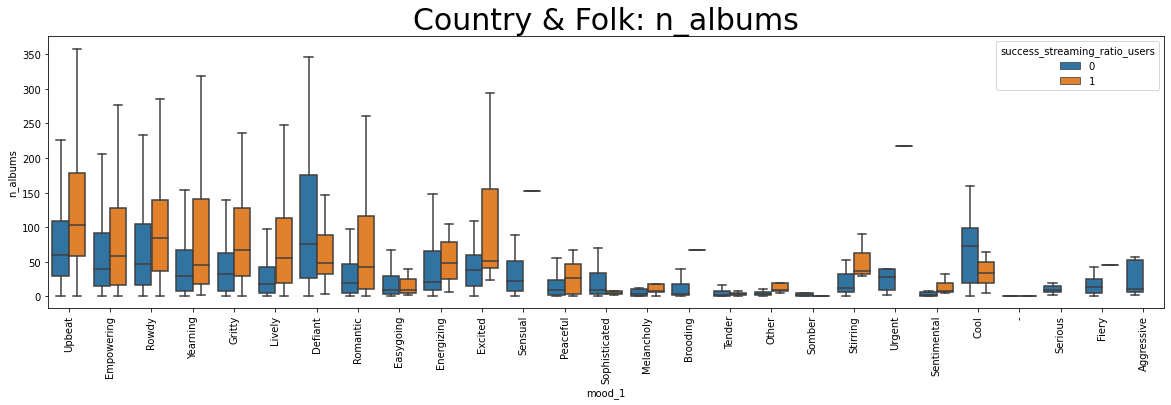

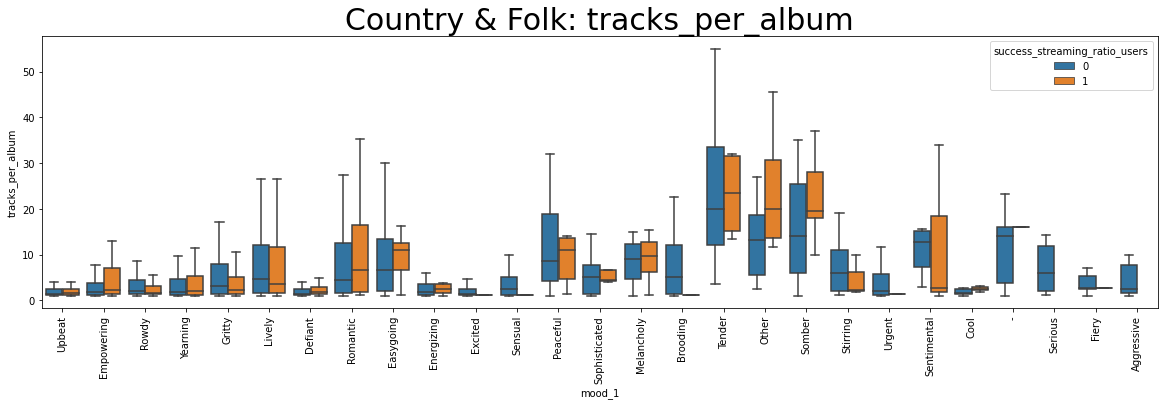

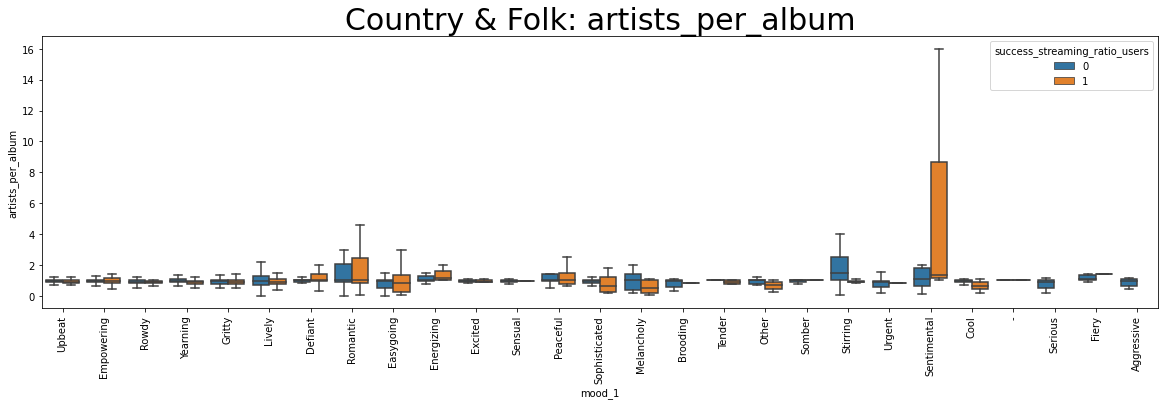

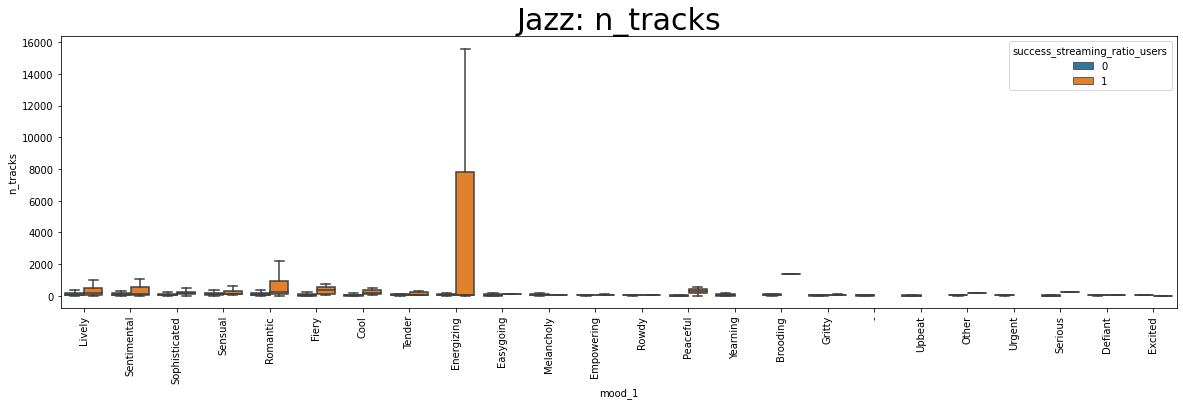

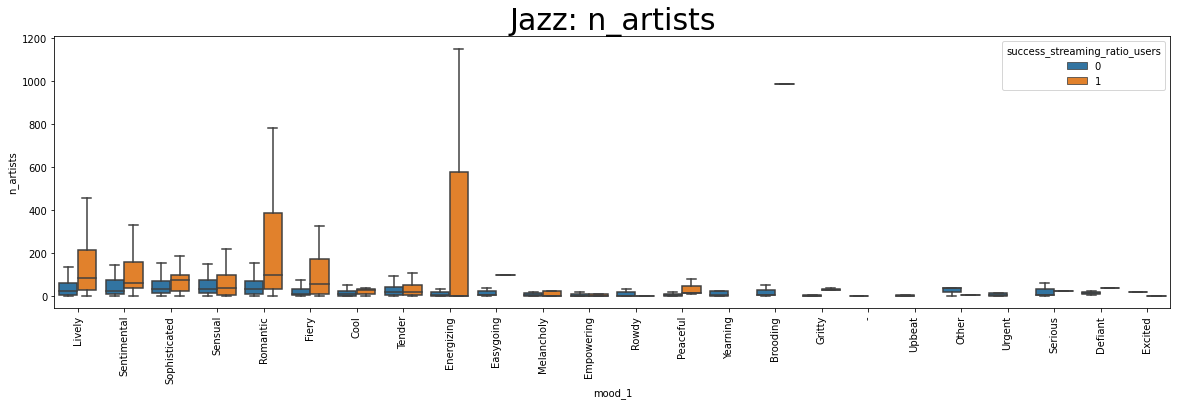

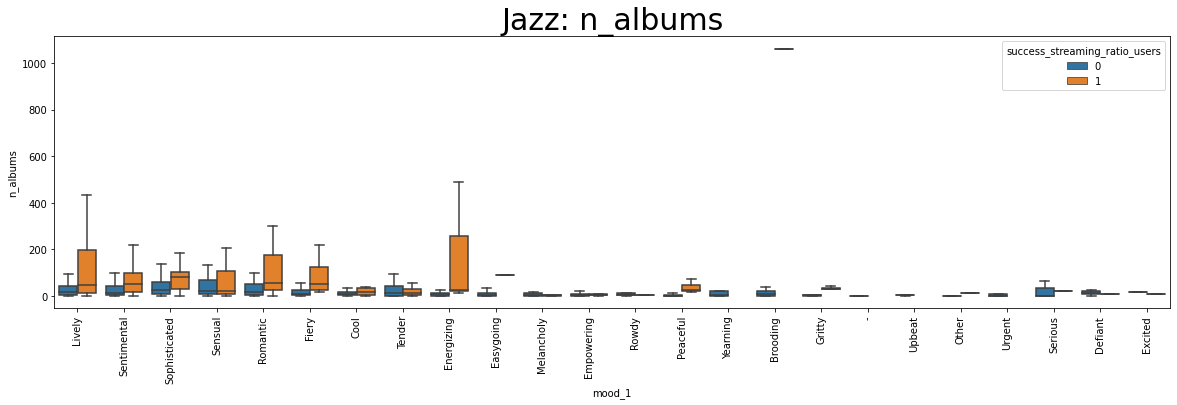

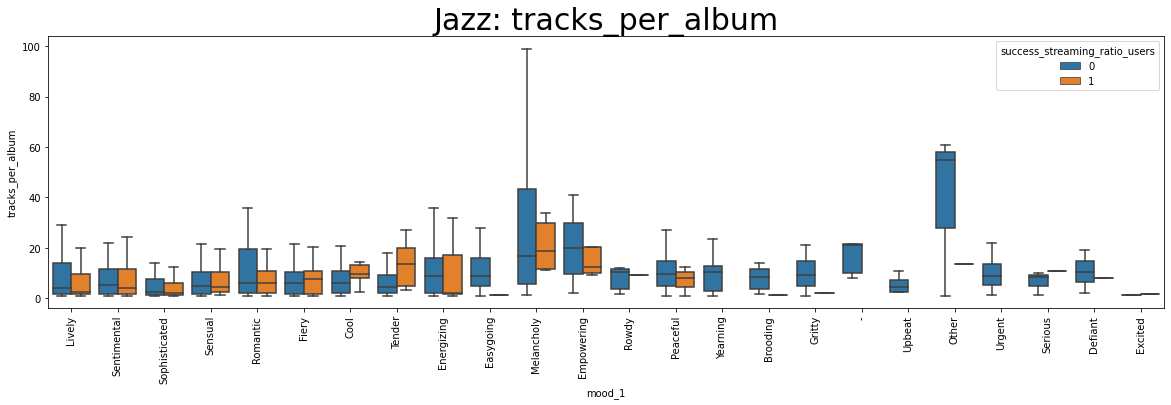

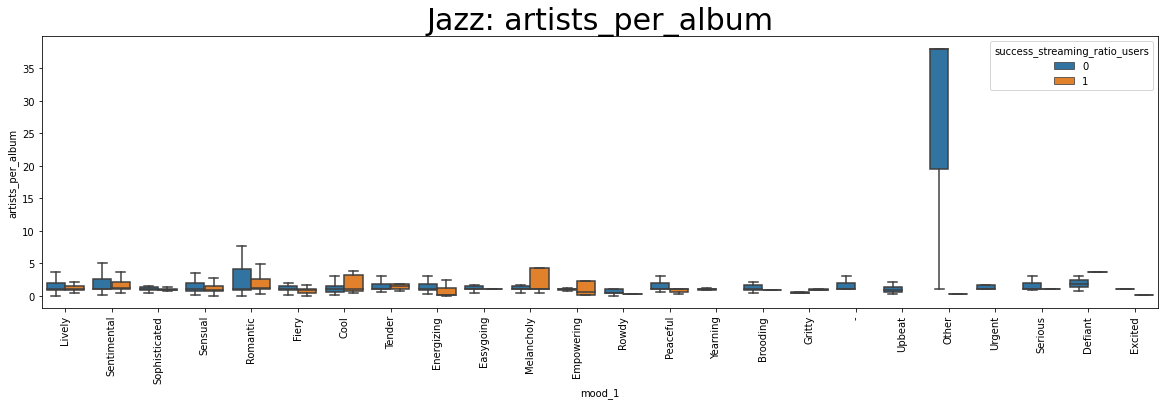

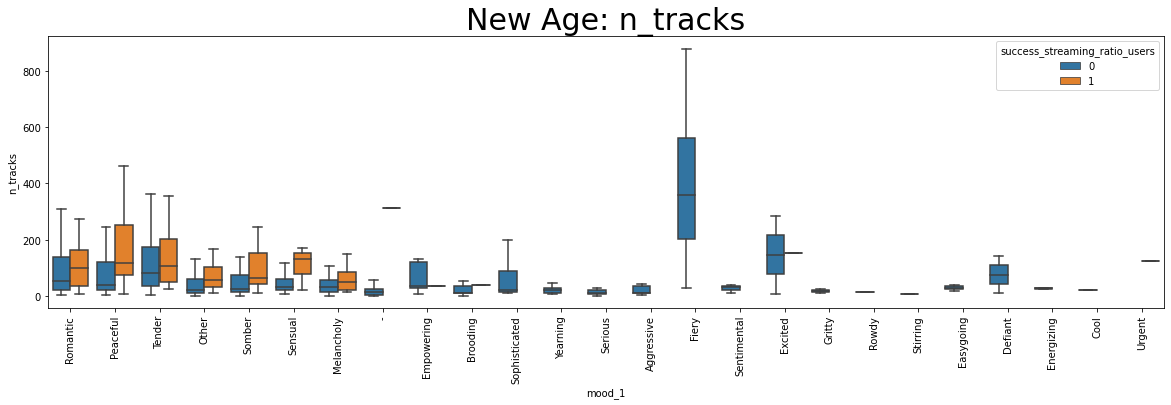

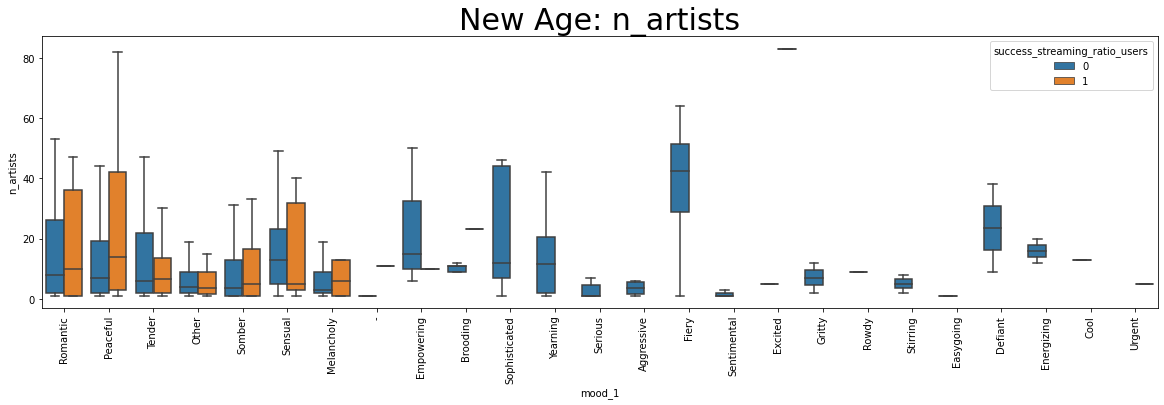

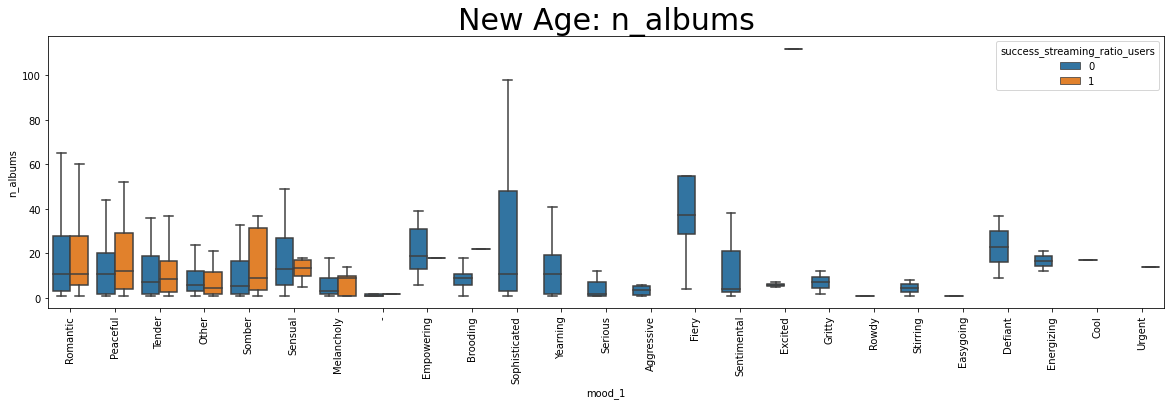

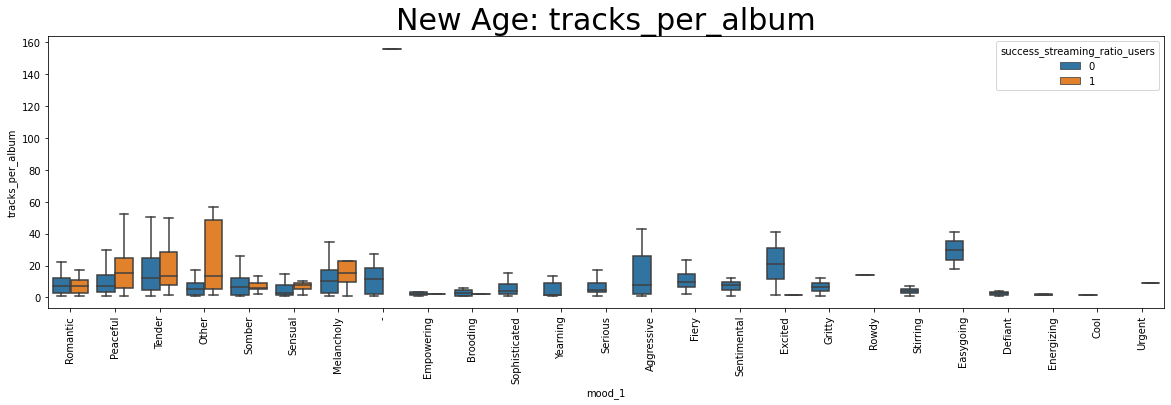

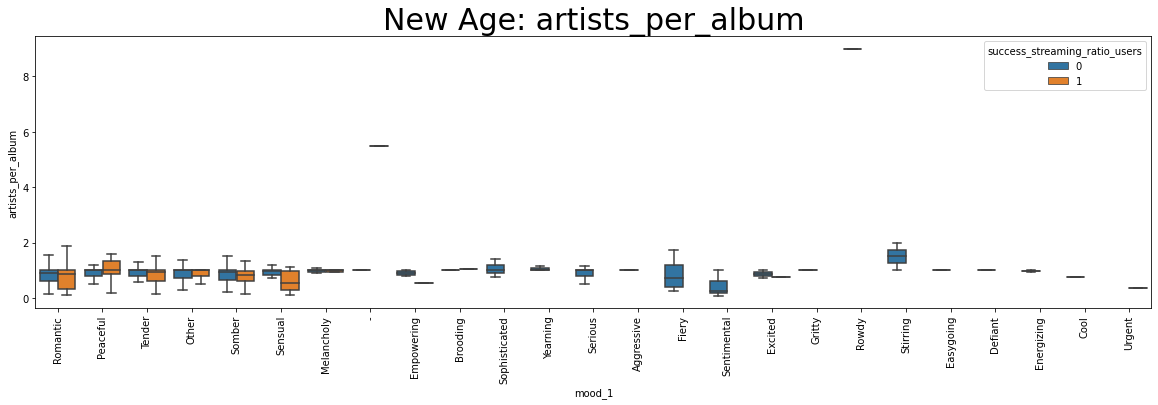

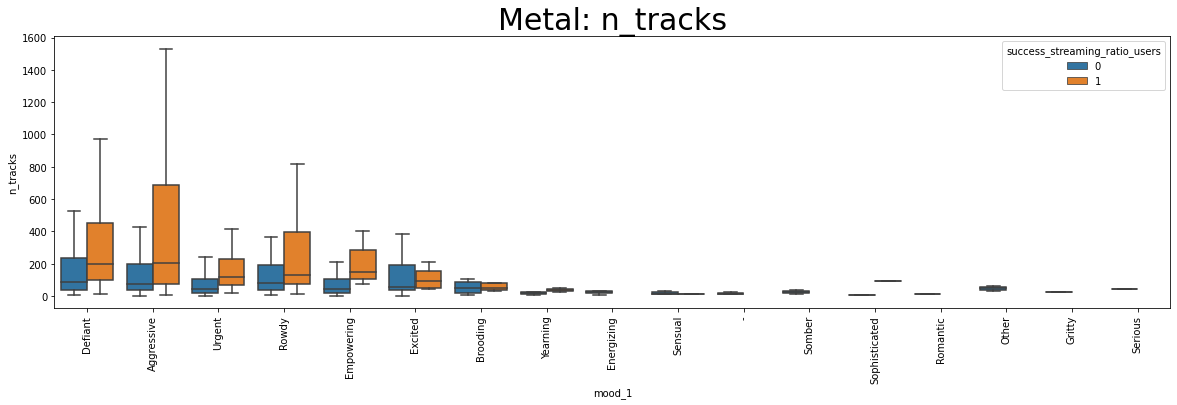

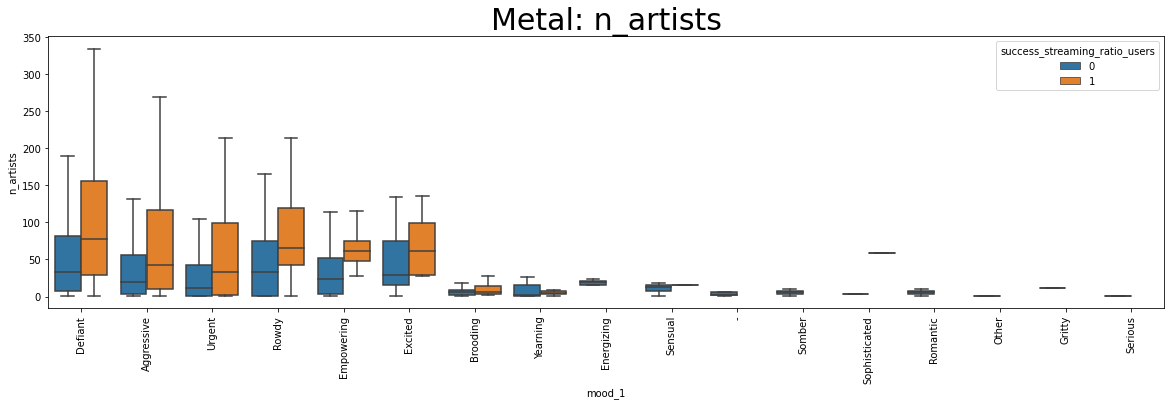

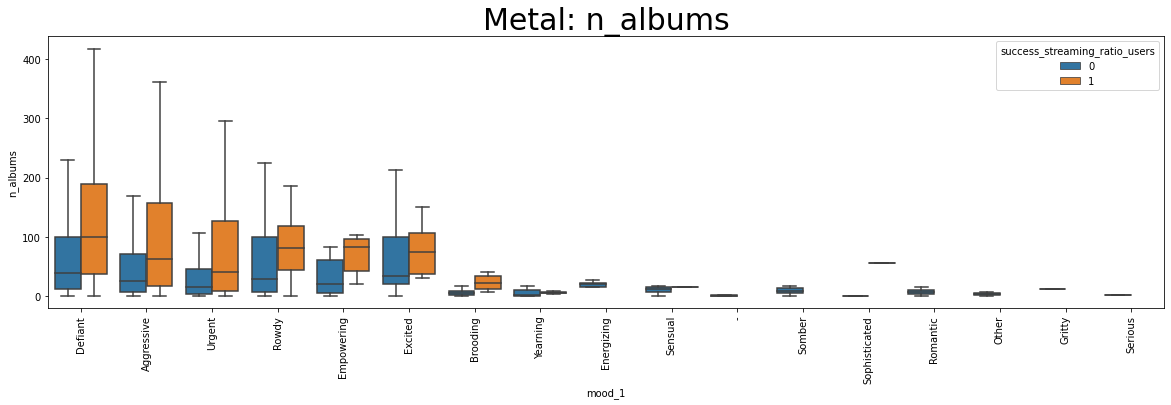

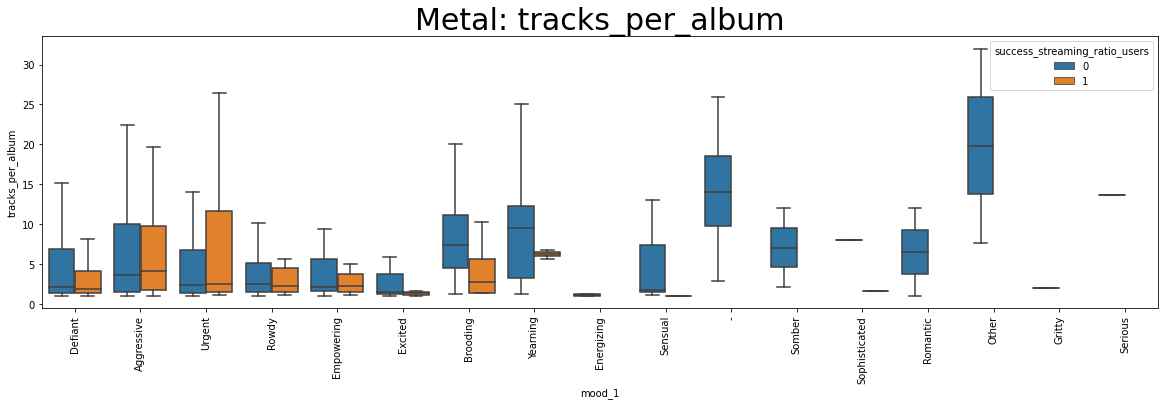

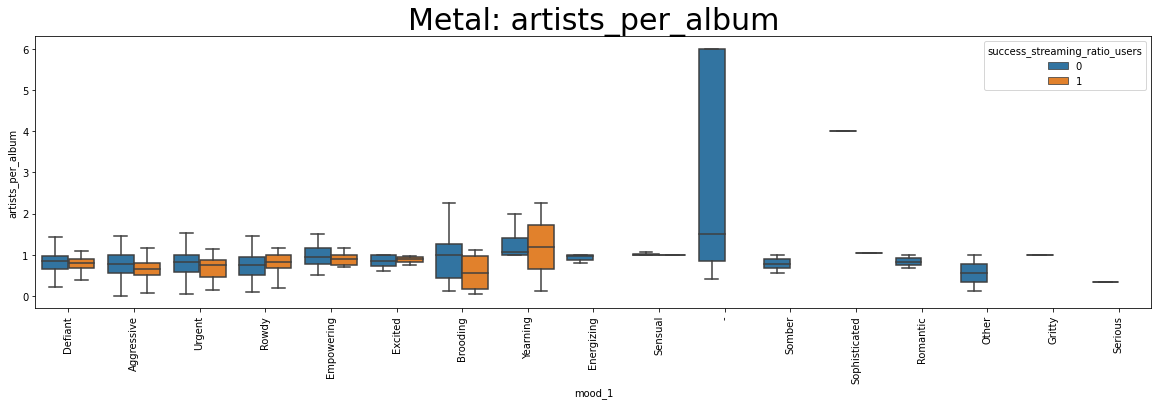

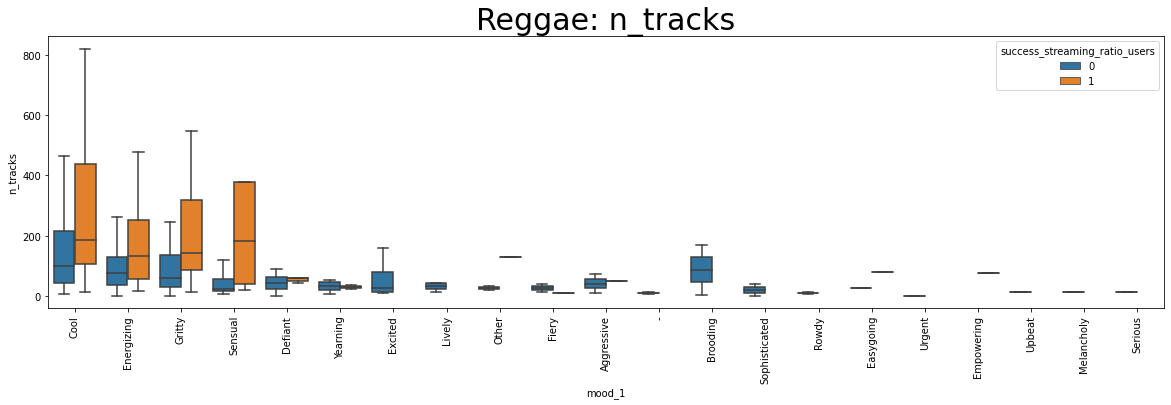

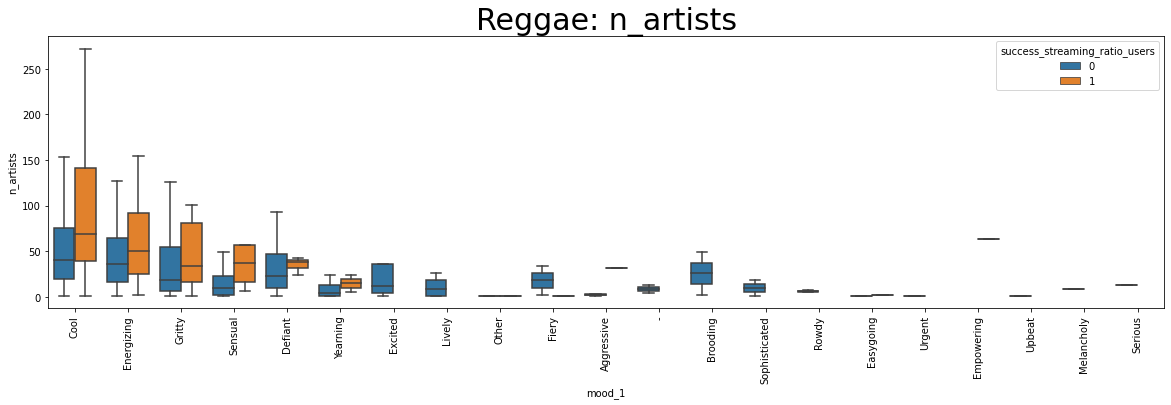

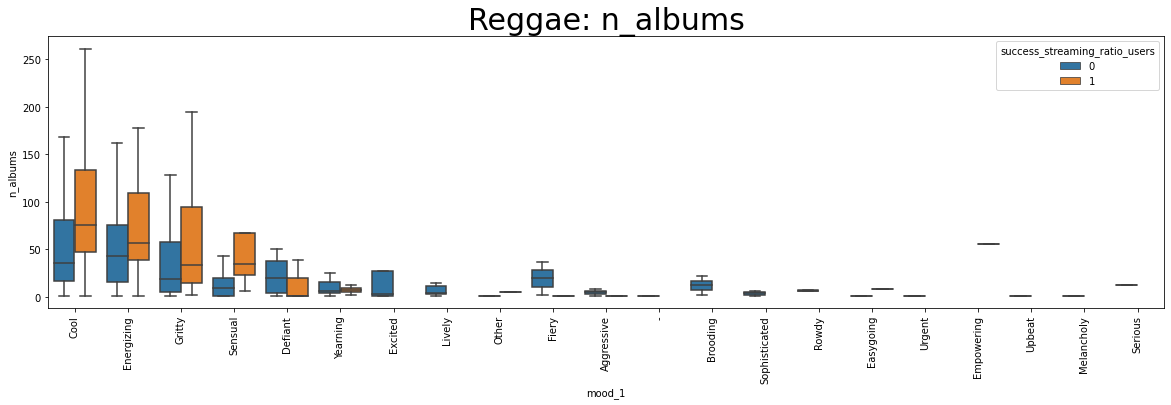

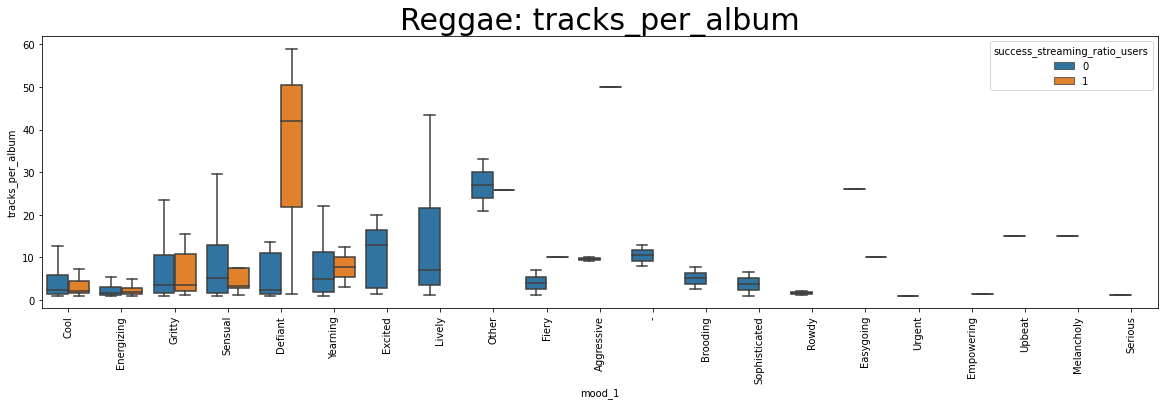

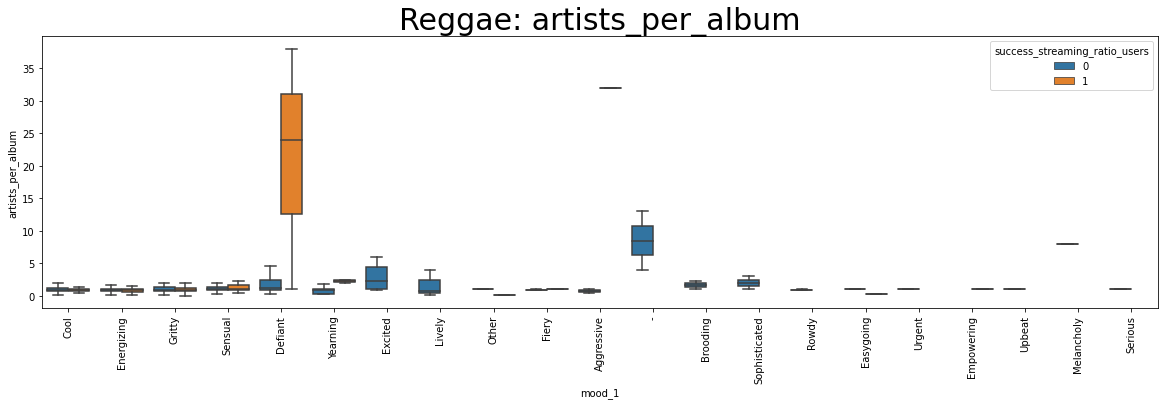

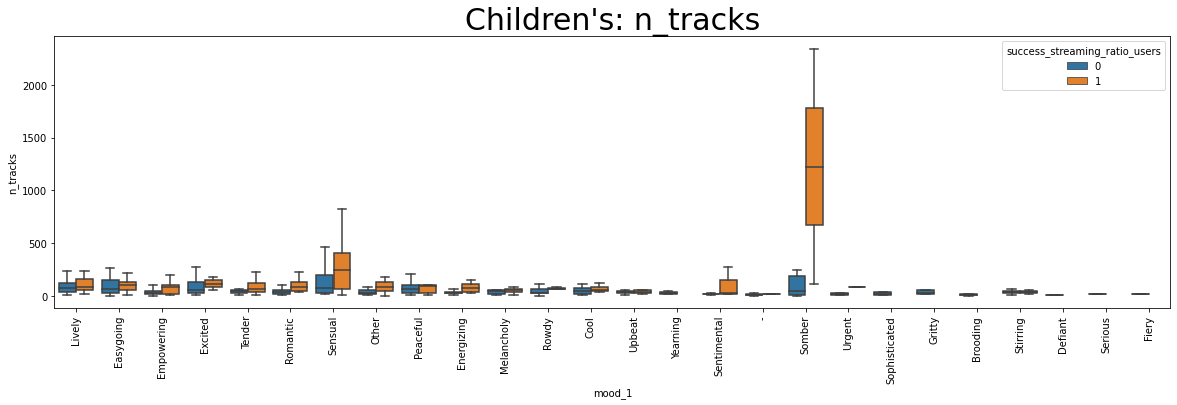

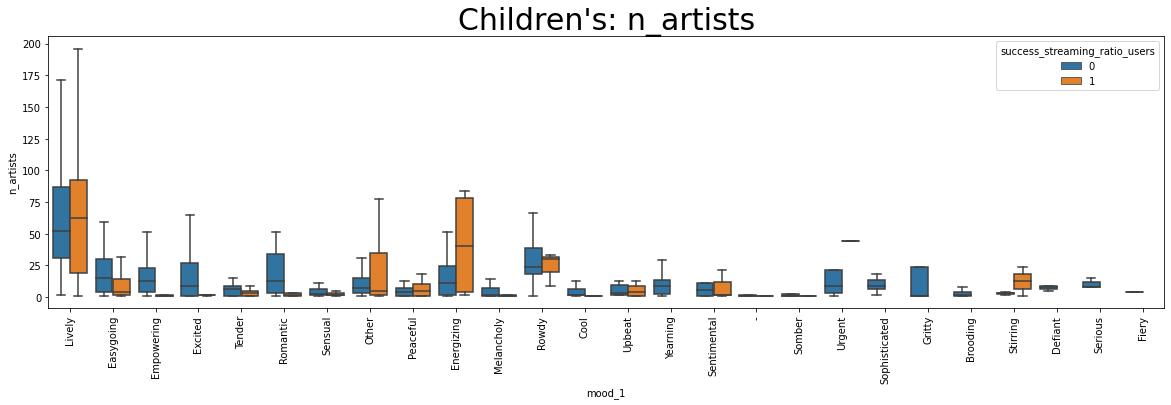

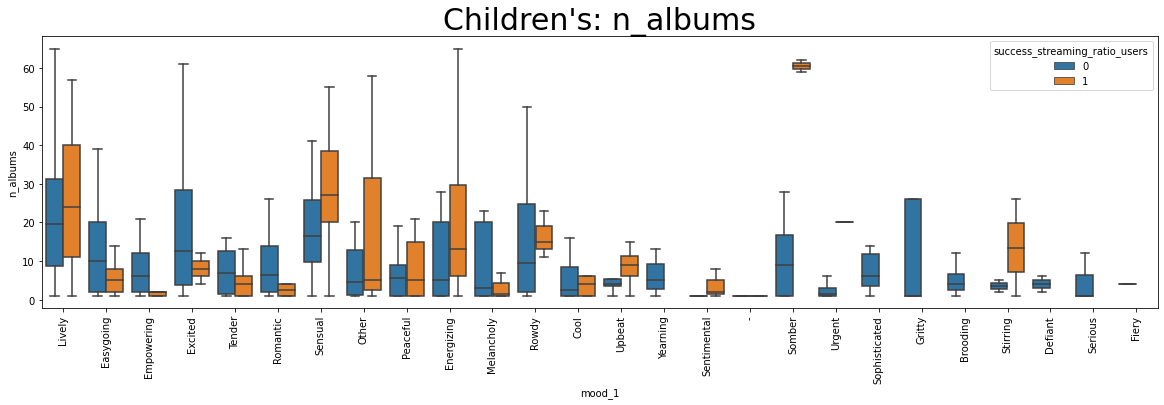

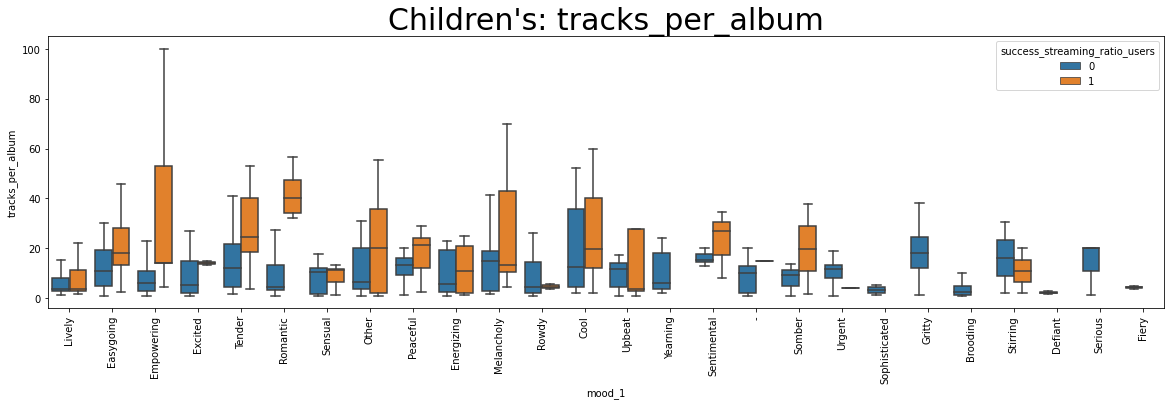

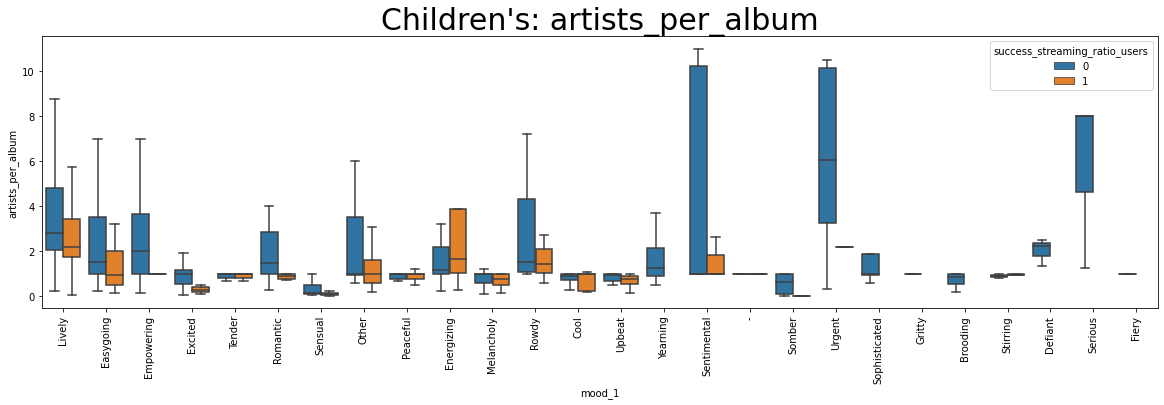

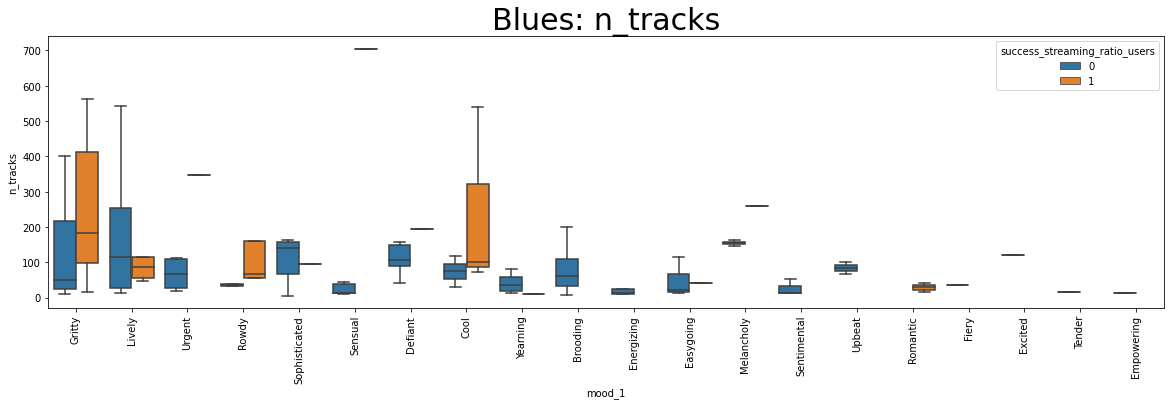

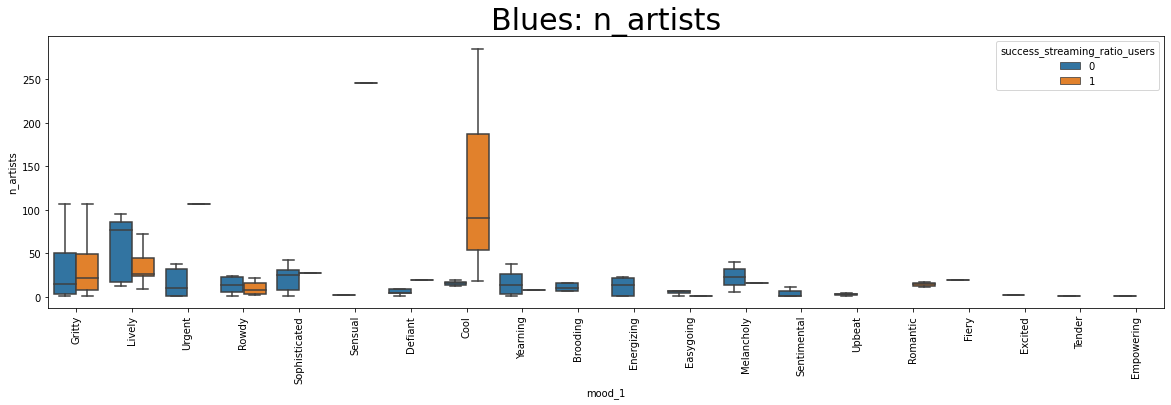

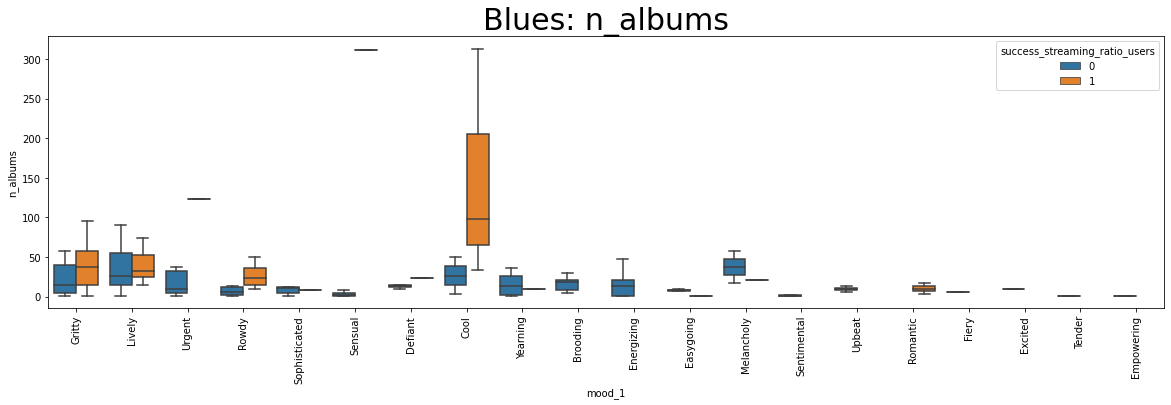

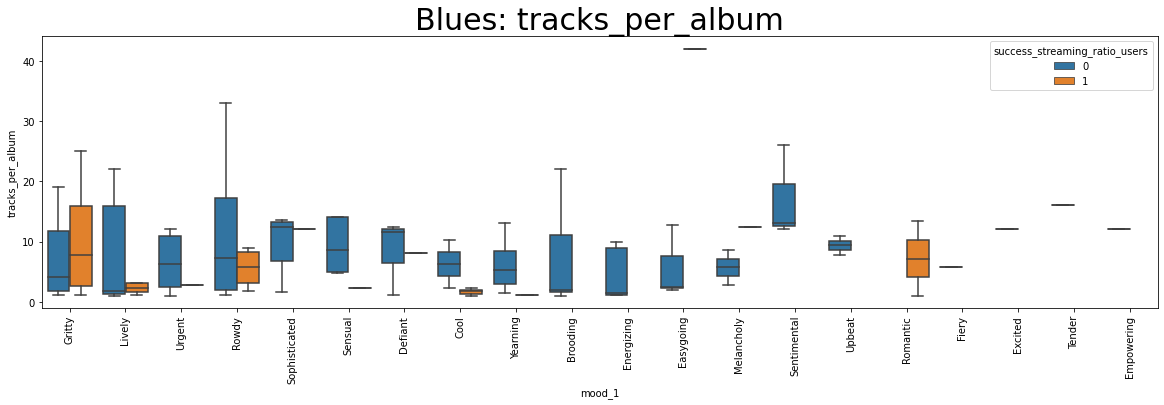

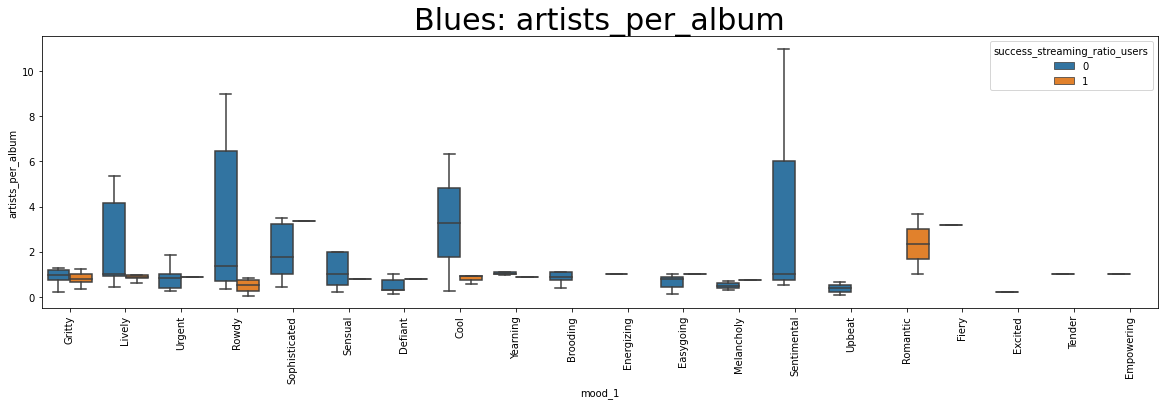

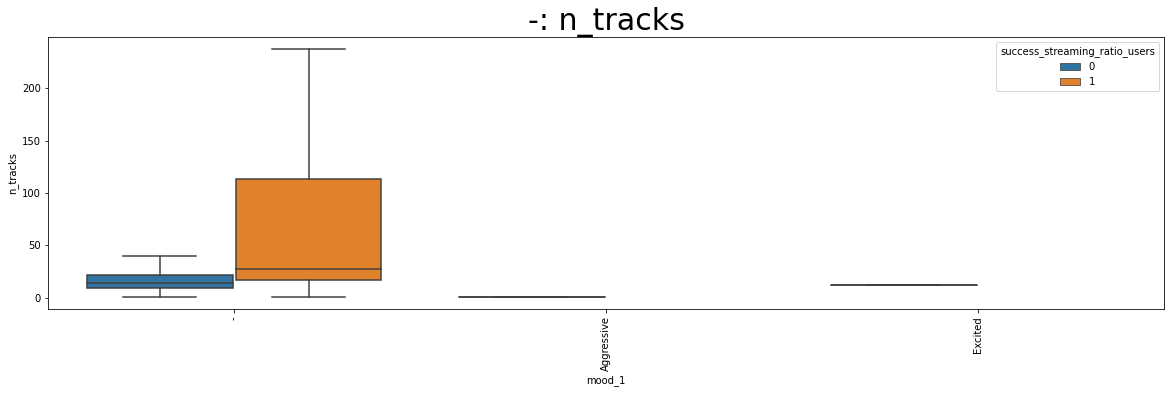

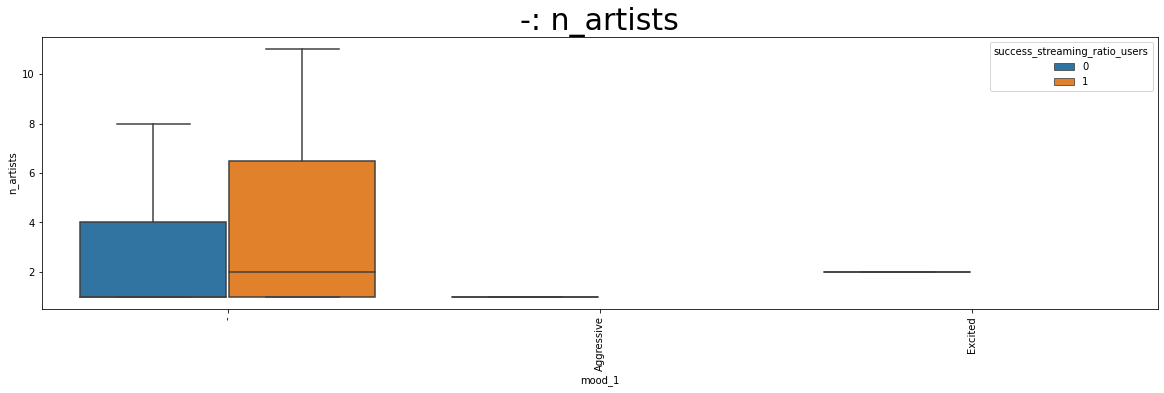

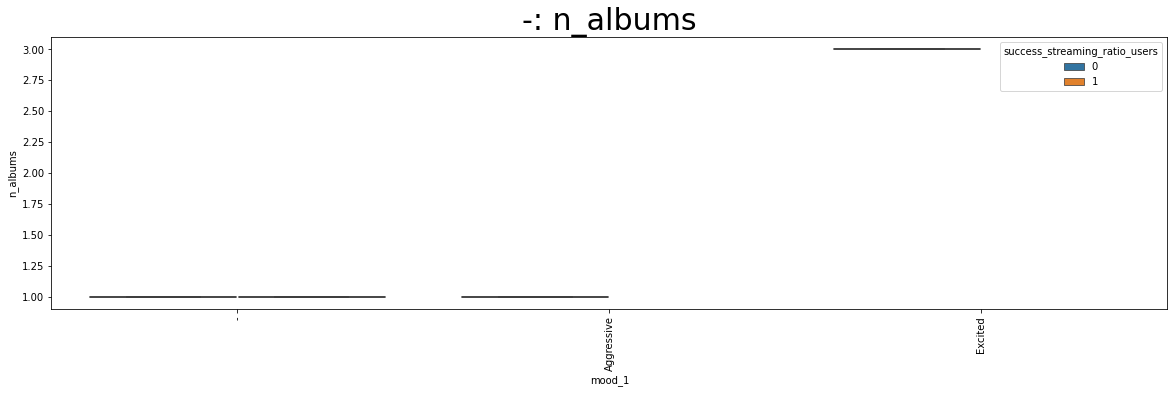

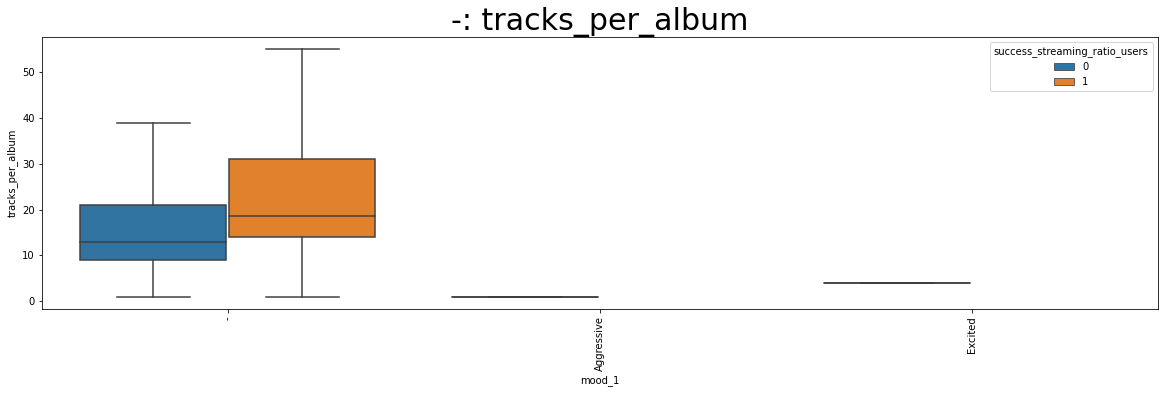

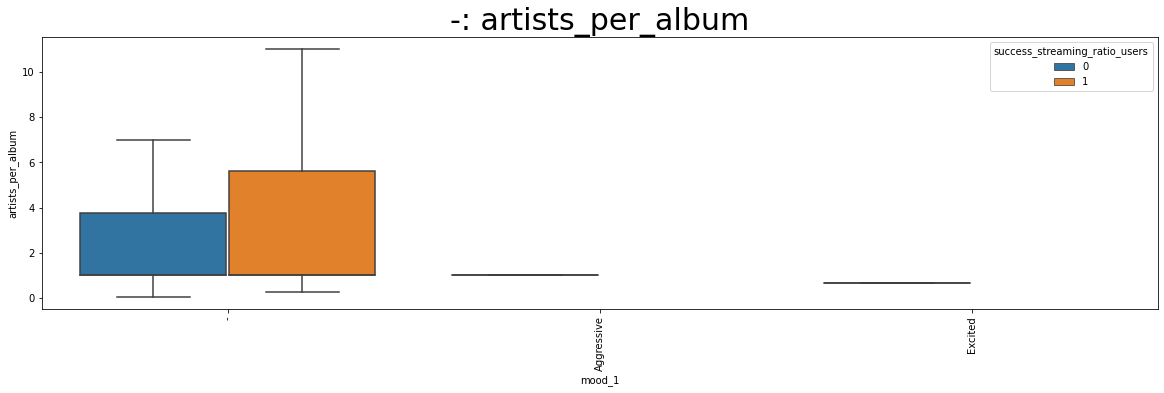

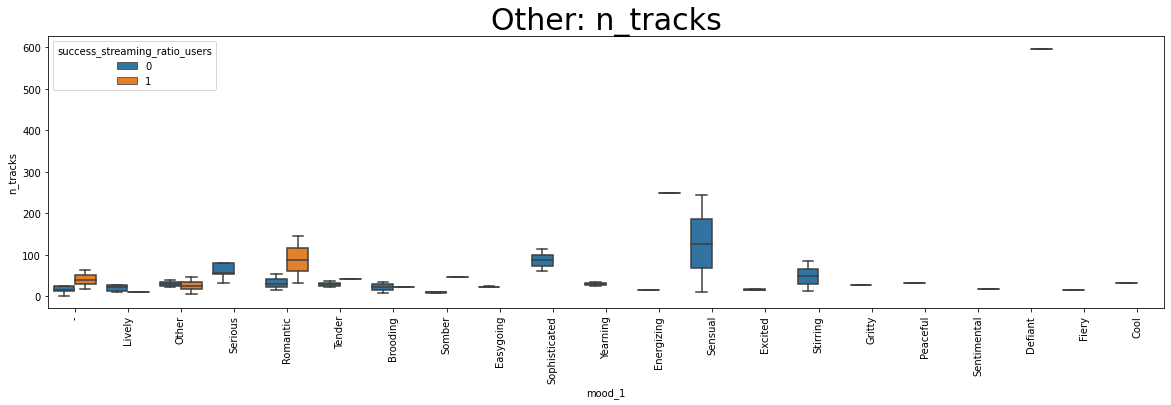

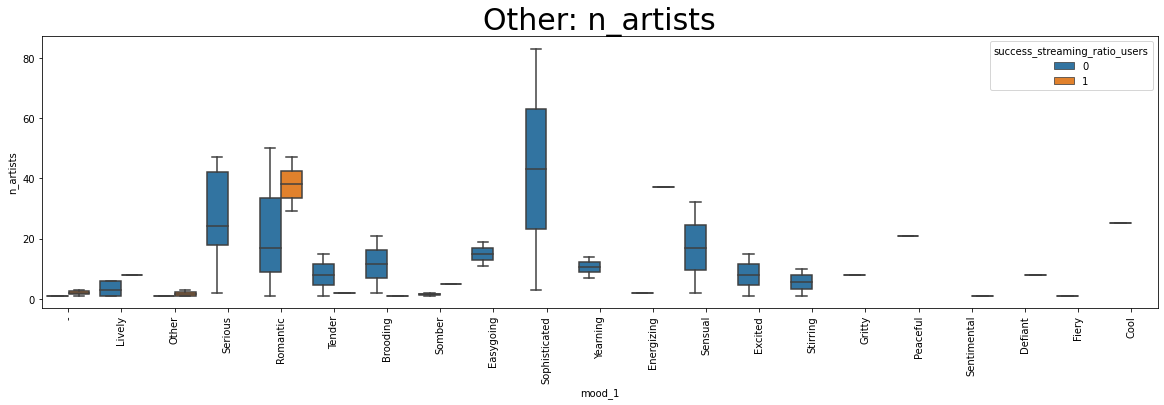

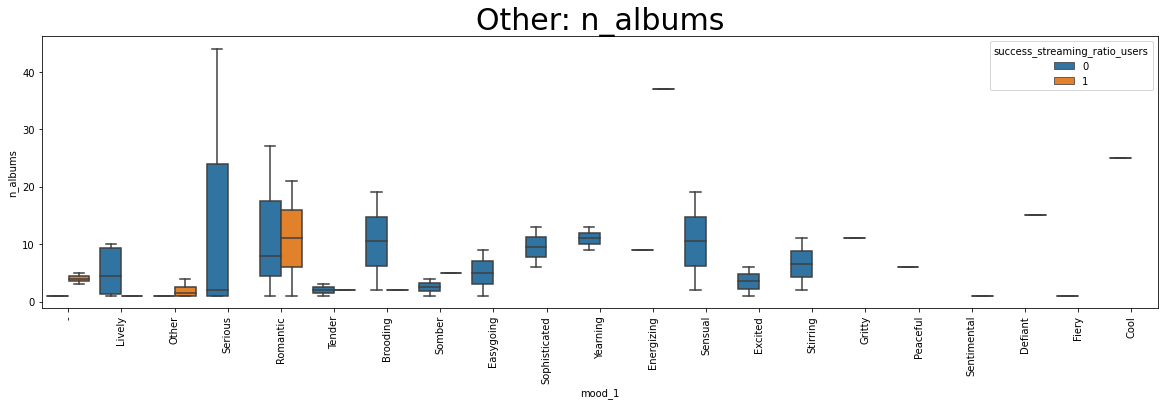

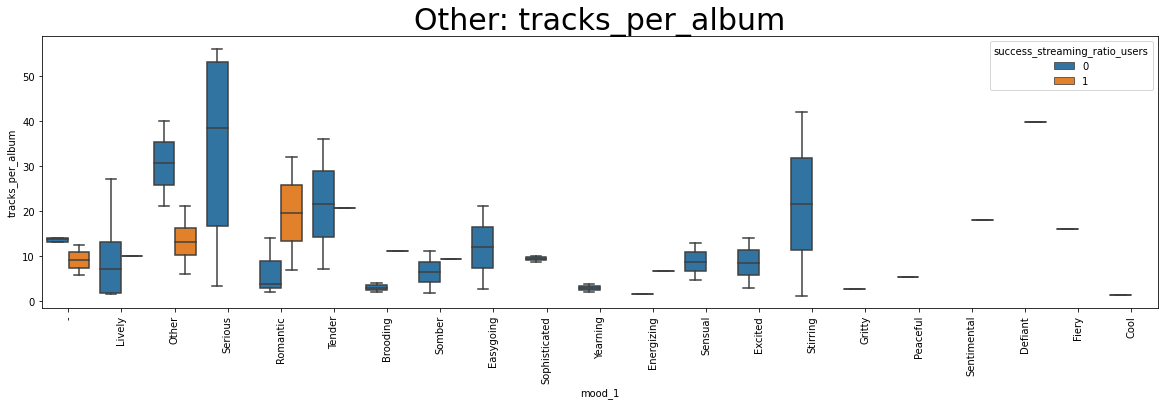

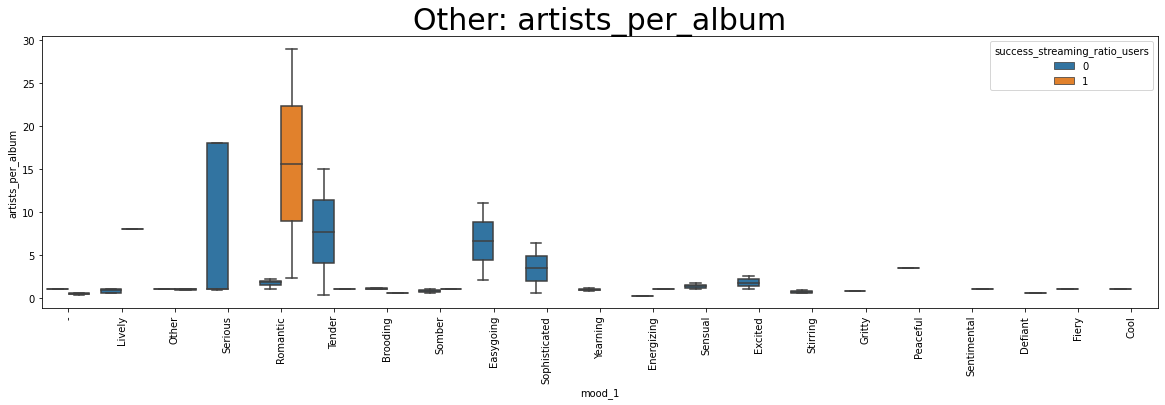

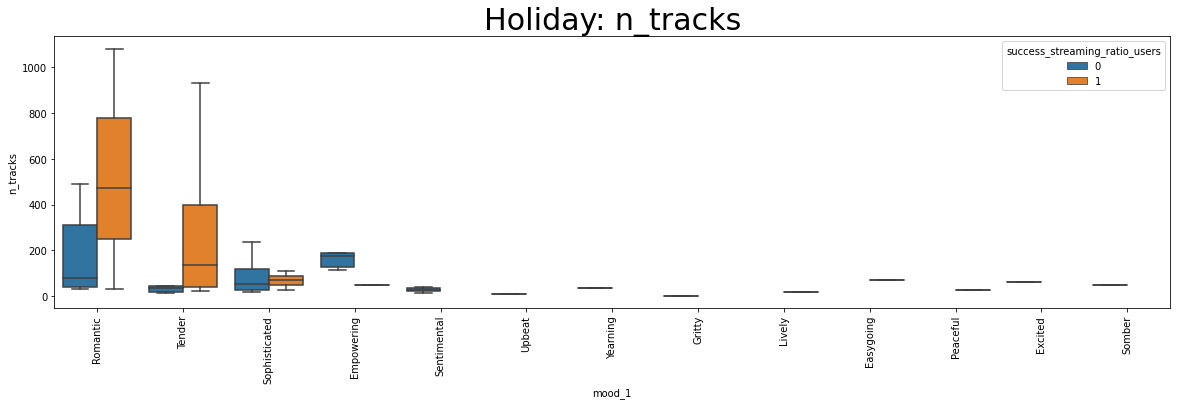

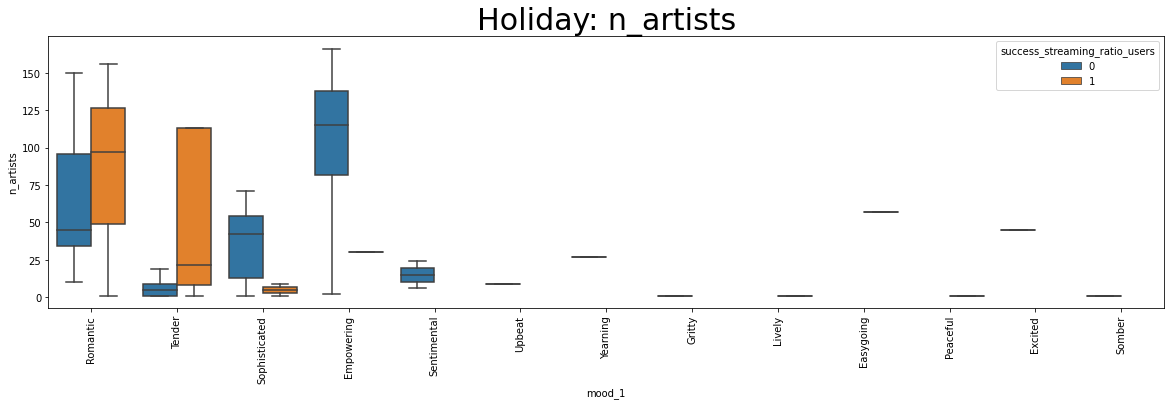

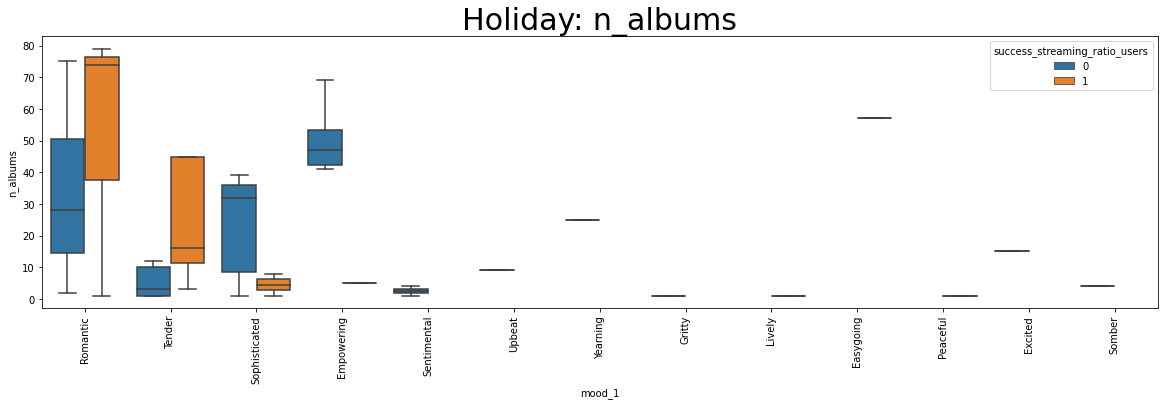

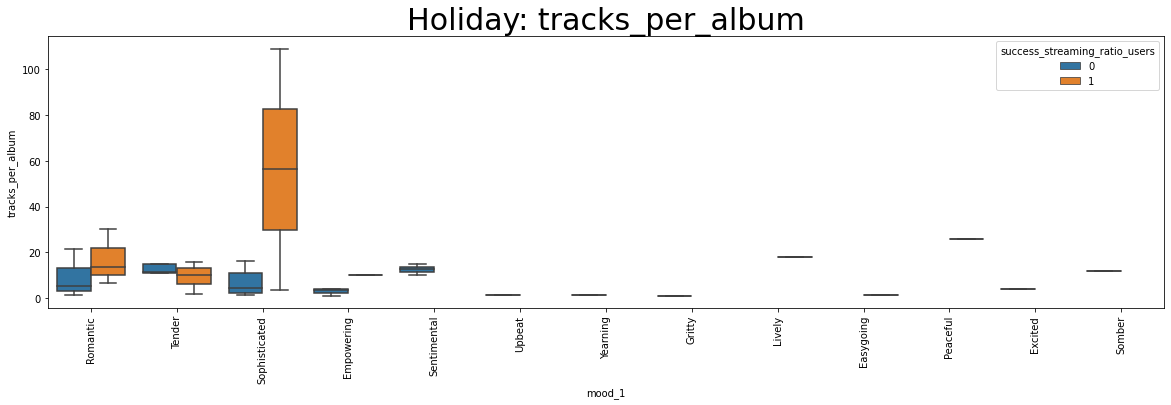

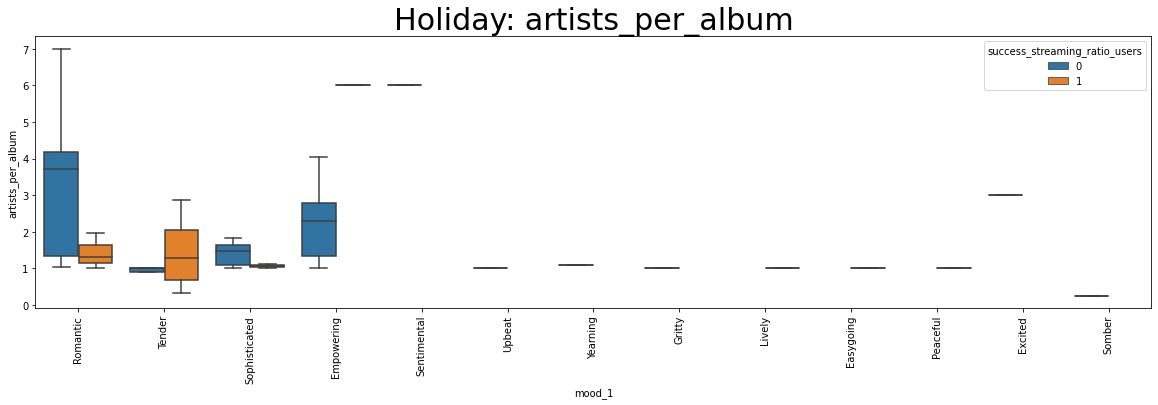

In [38]:
genres = list(success_frame["genre_1"].unique())

for genre in genres:
    genre_frame = success_frame.loc[lambda f: f['genre_1']==genre]
    
    for col in analyze_num_cols:
        fig, ax = plt.subplots(figsize=(20, 5))
        sns.boxplot(x="mood_1", y=col, data=genre_frame, order=genre_frame["mood_1"].value_counts().index, hue="success_streaming_ratio_users", showfliers=False)
        plt.title(f'{genre}: {col}', size=30)
        plt.xticks(rotation=90)
        plt.show()

In [90]:
success_frame

NameError: name 'success_frame' is not defined

## Percent Success by Mood

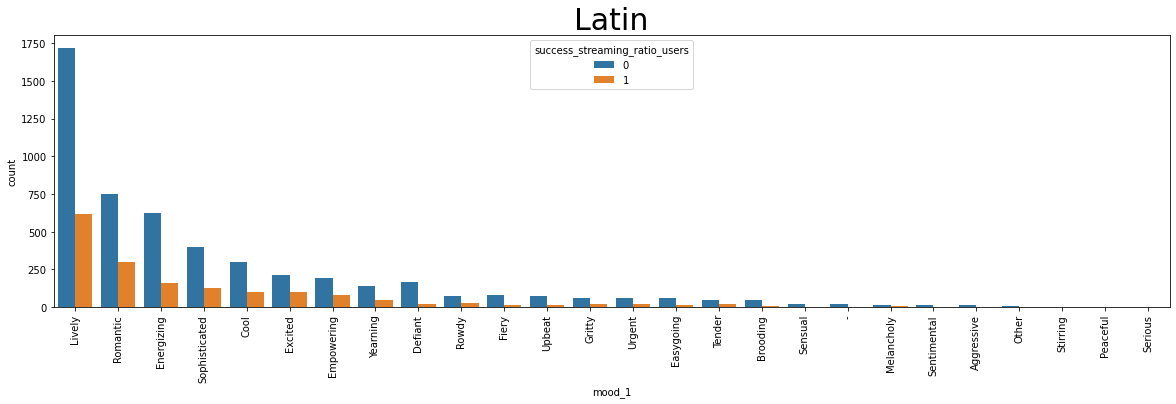

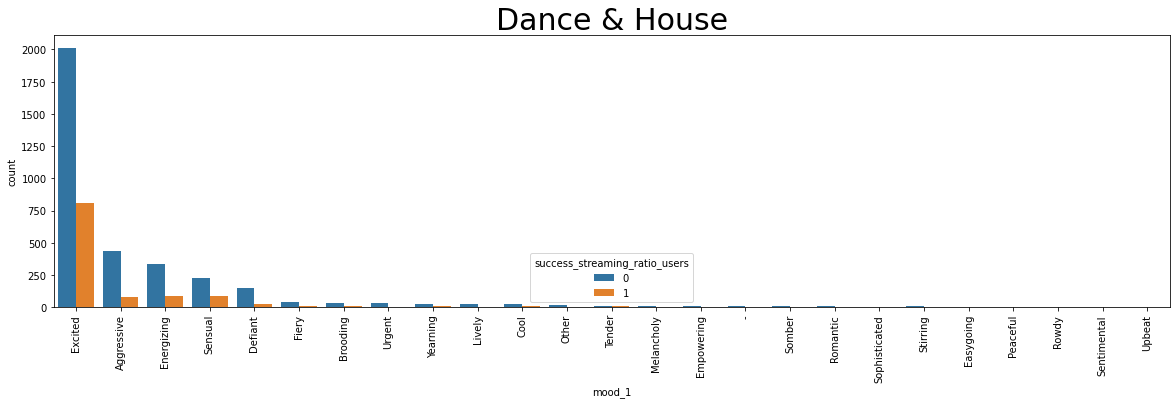

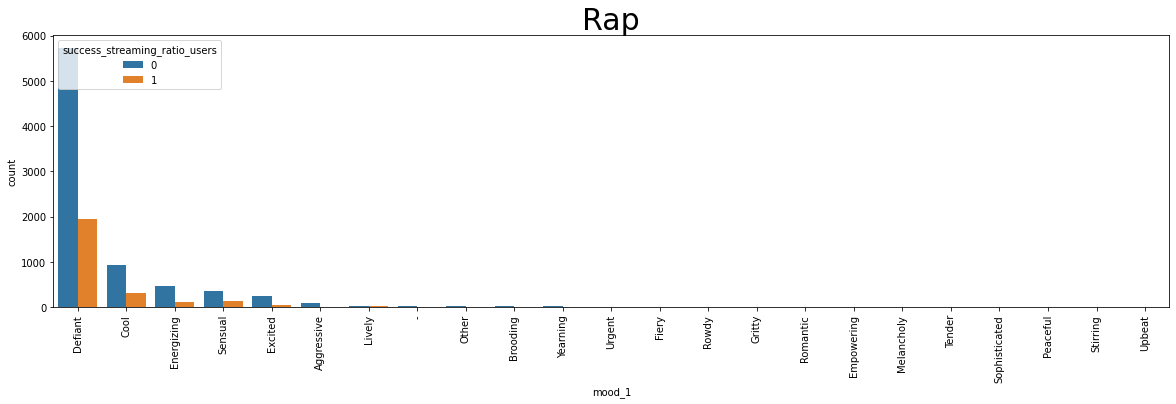

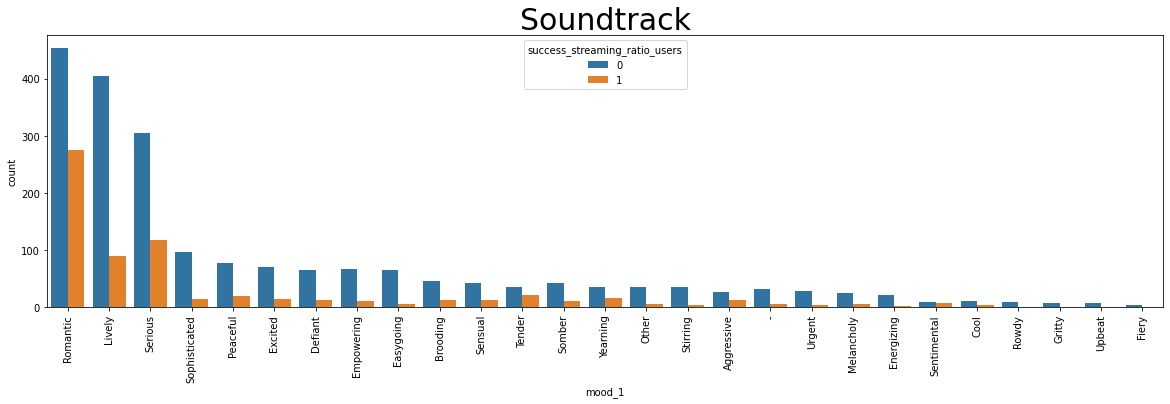

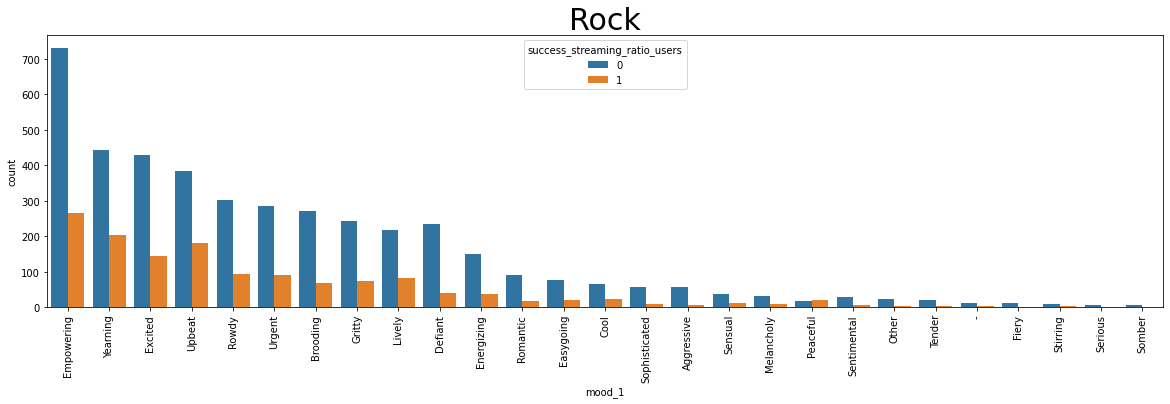

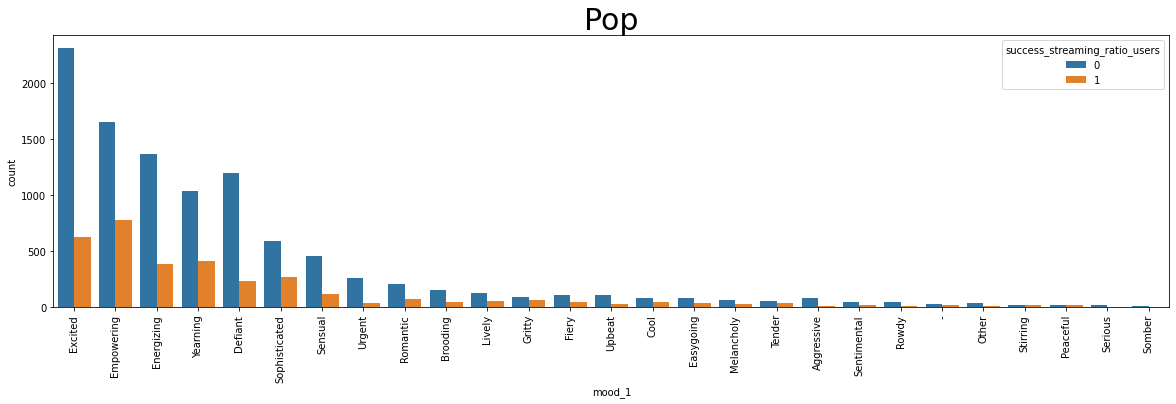

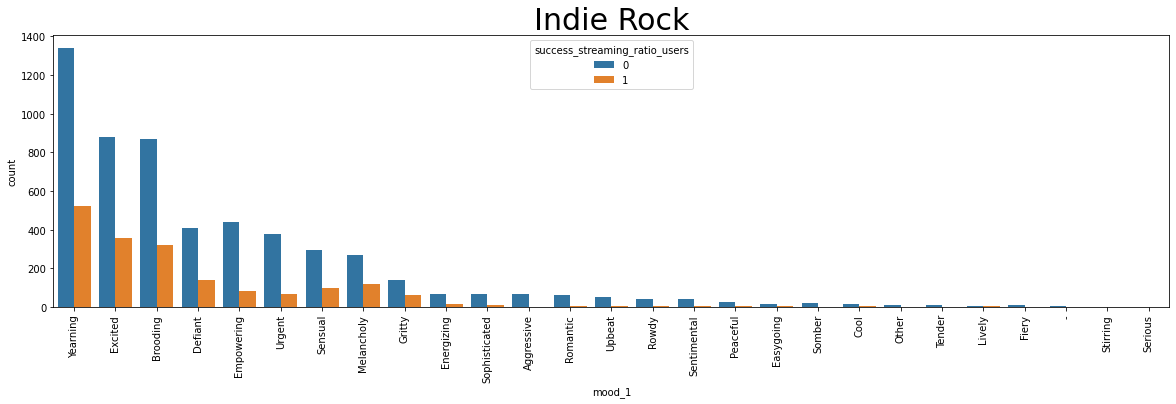

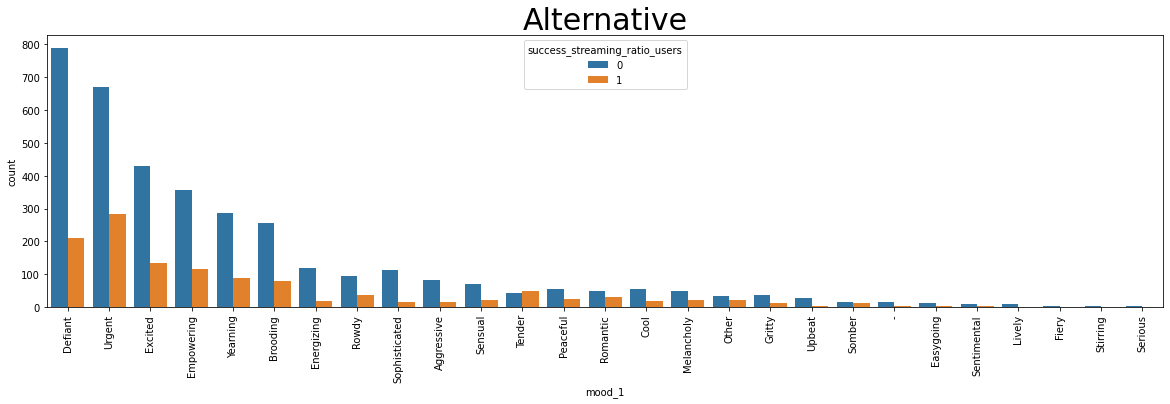

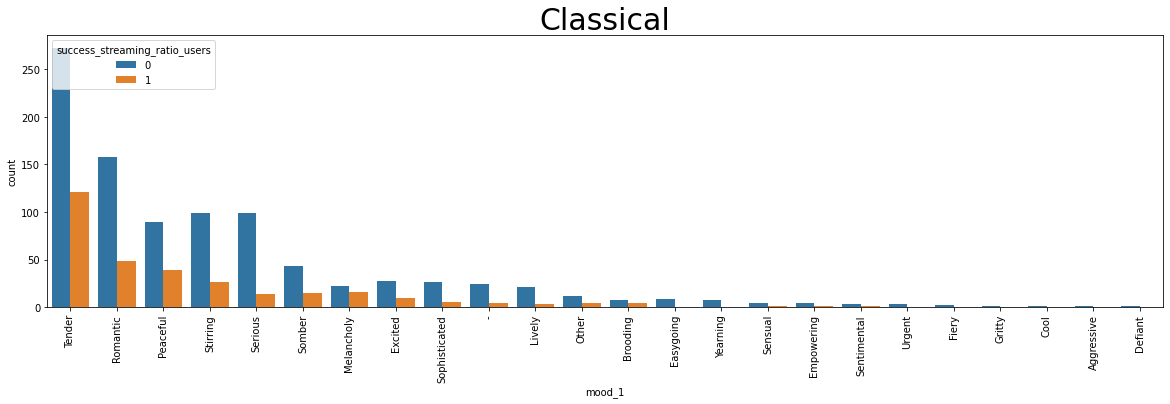

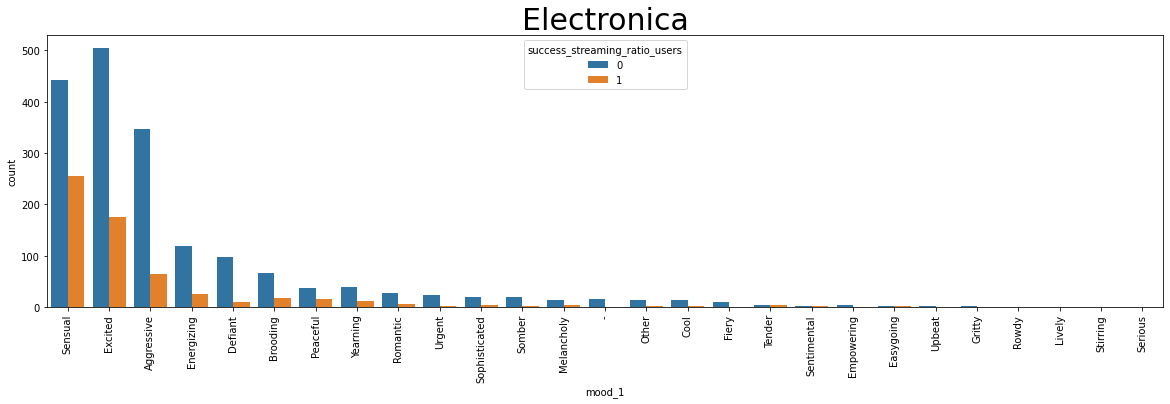

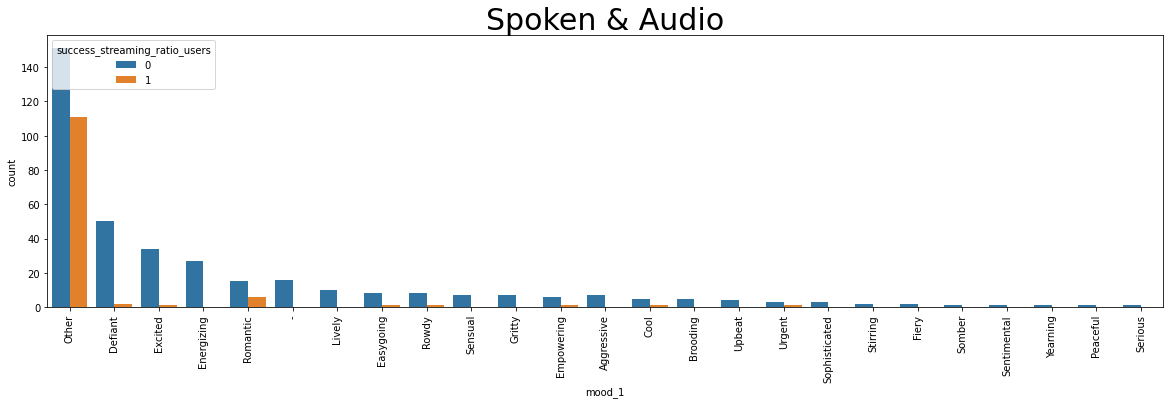

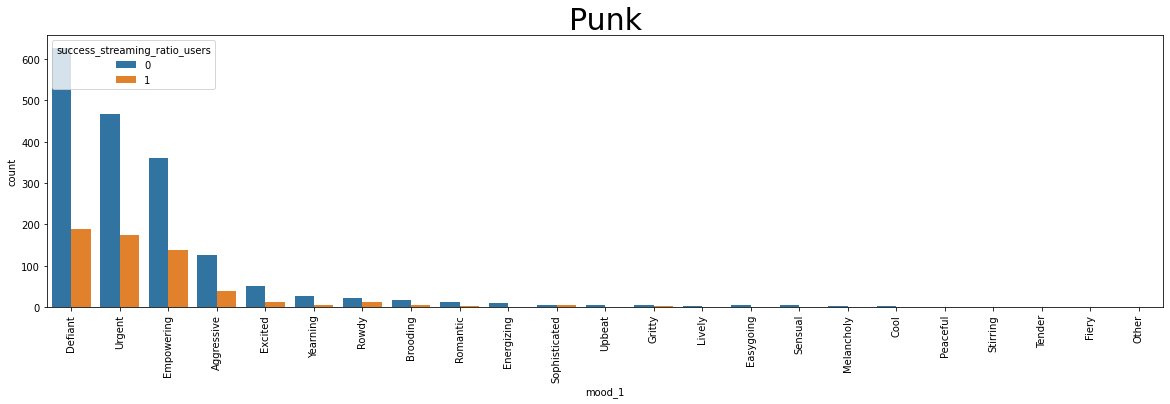

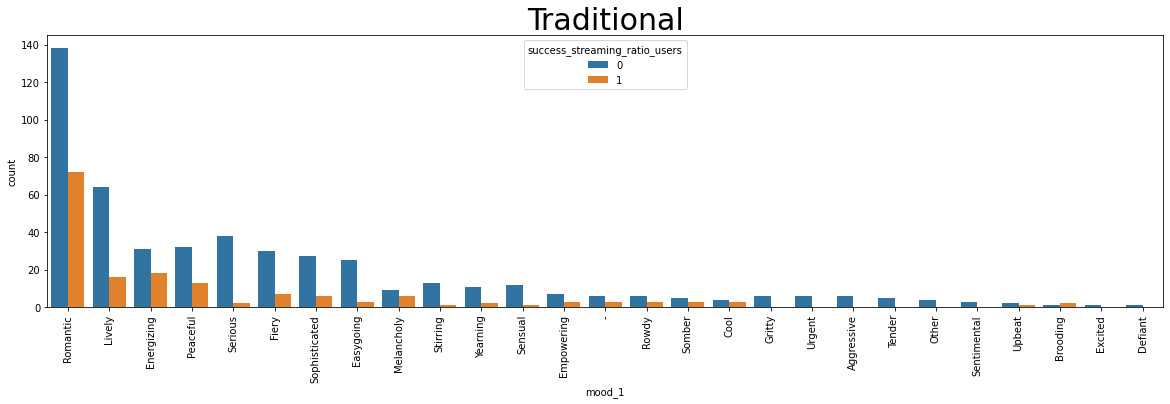

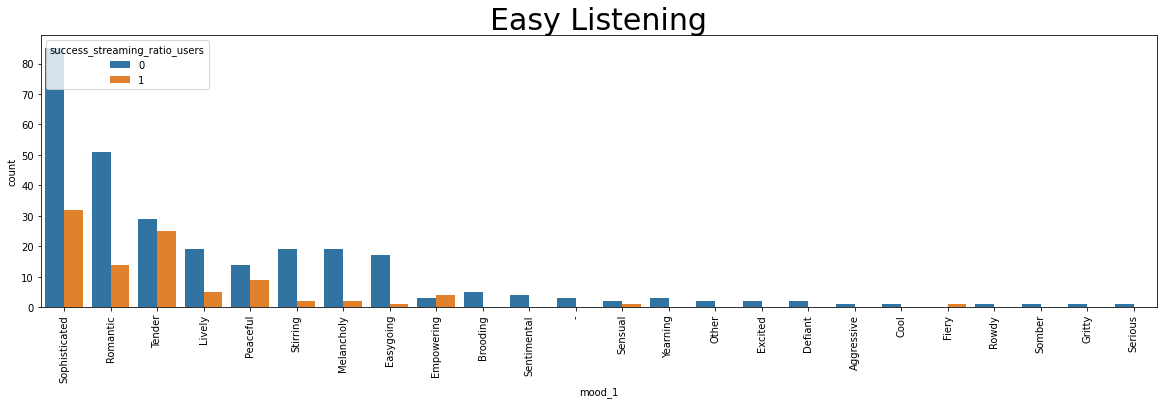

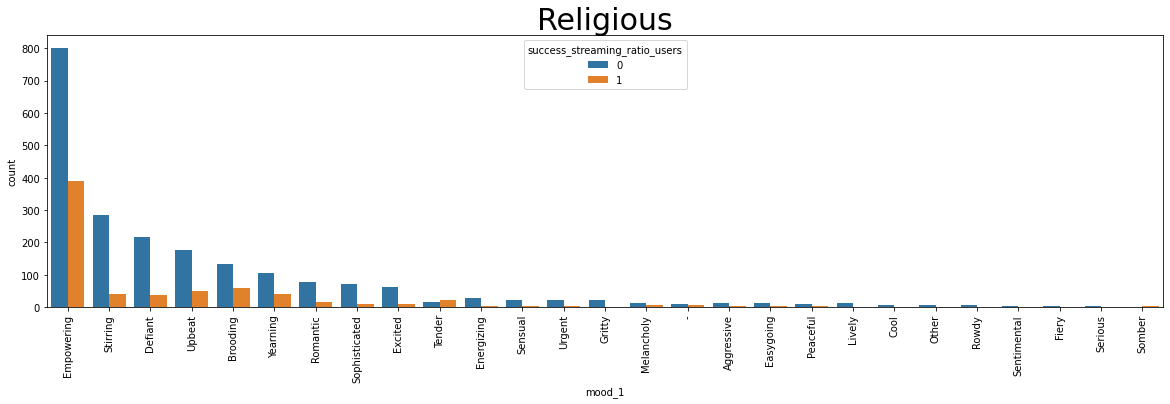

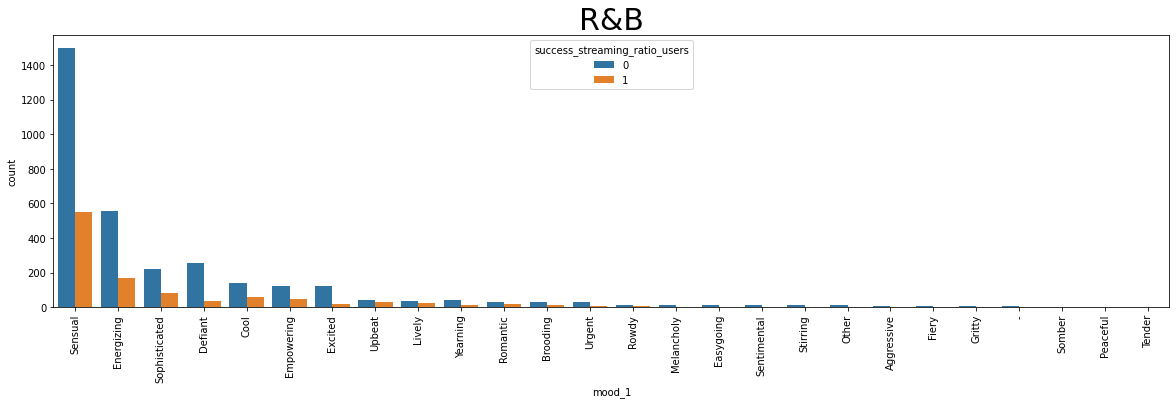

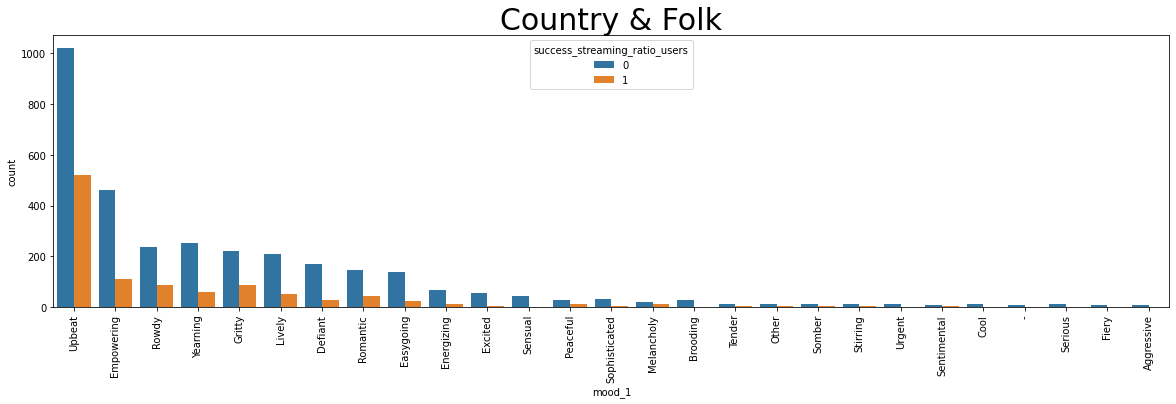

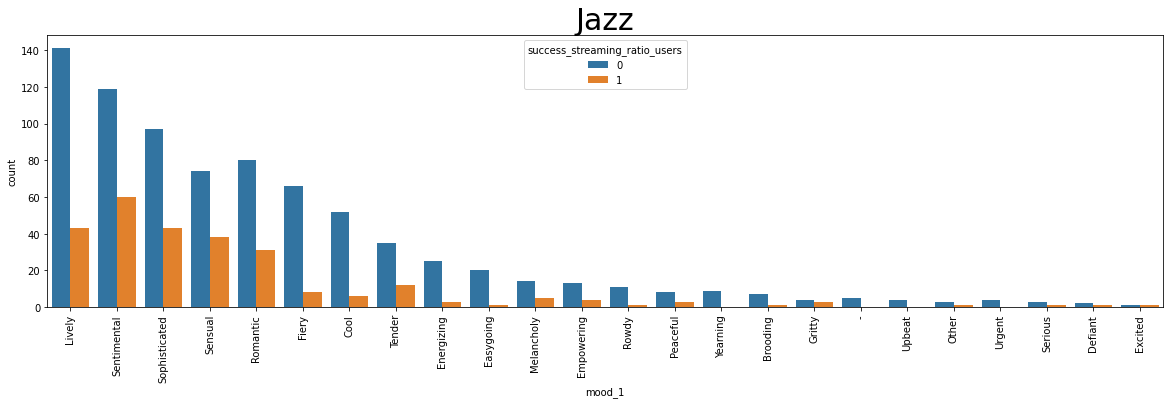

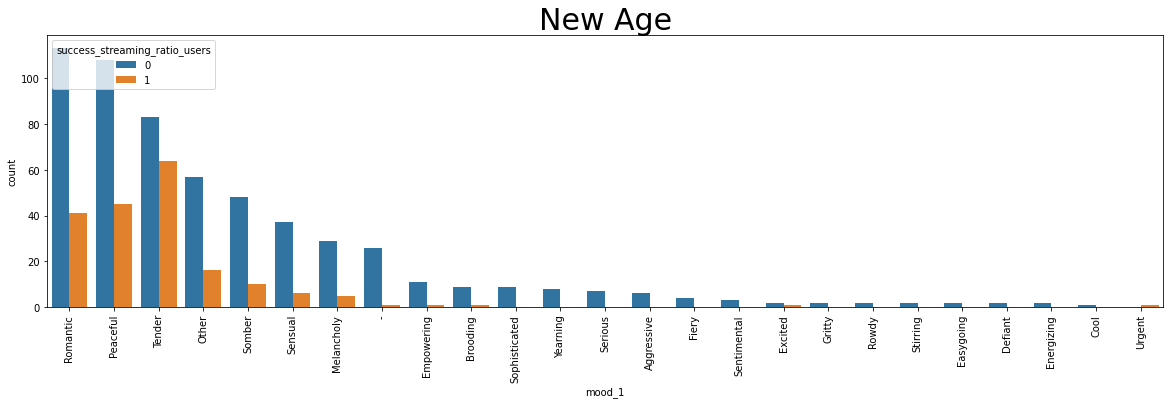

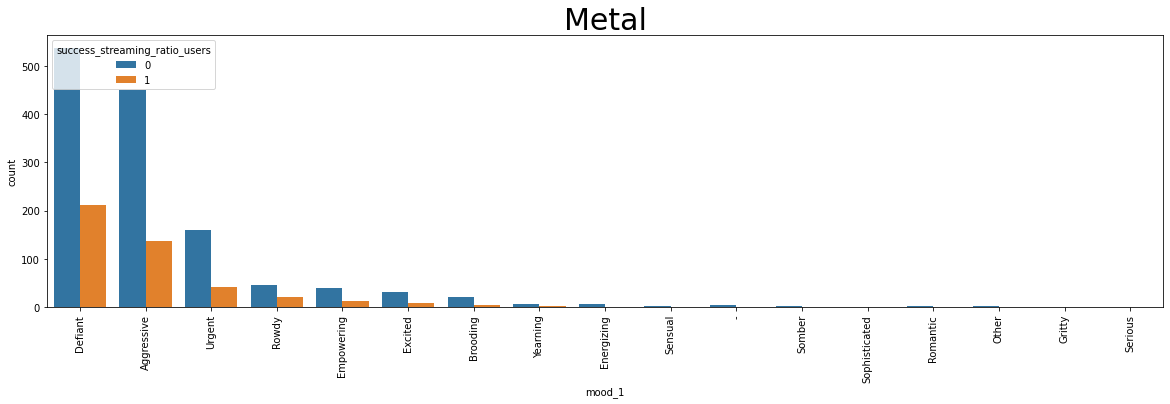

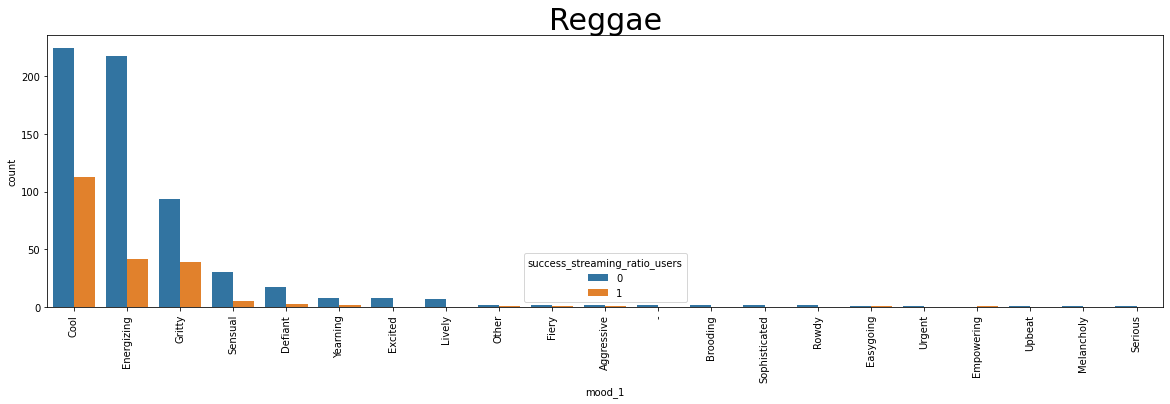

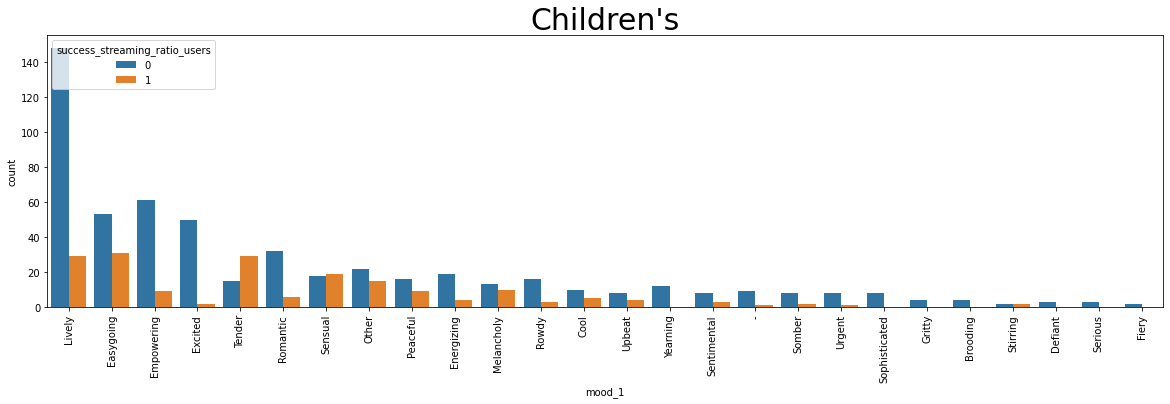

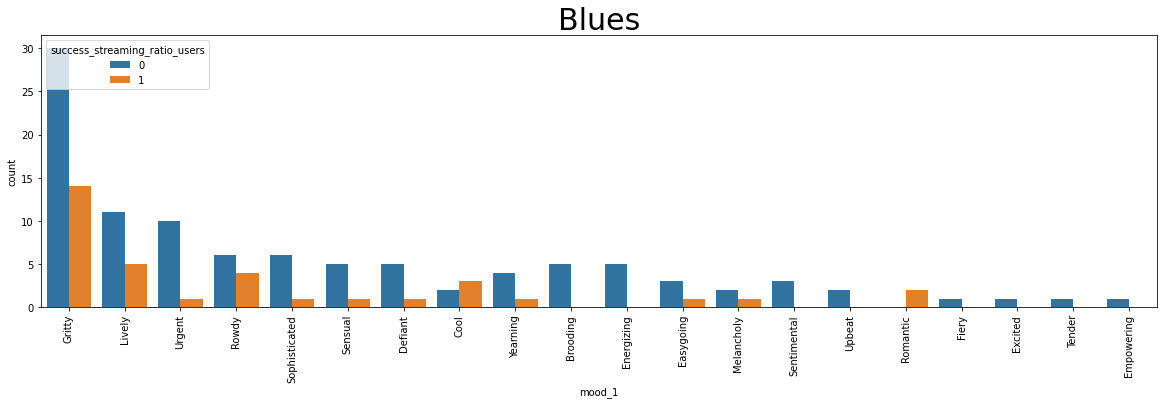

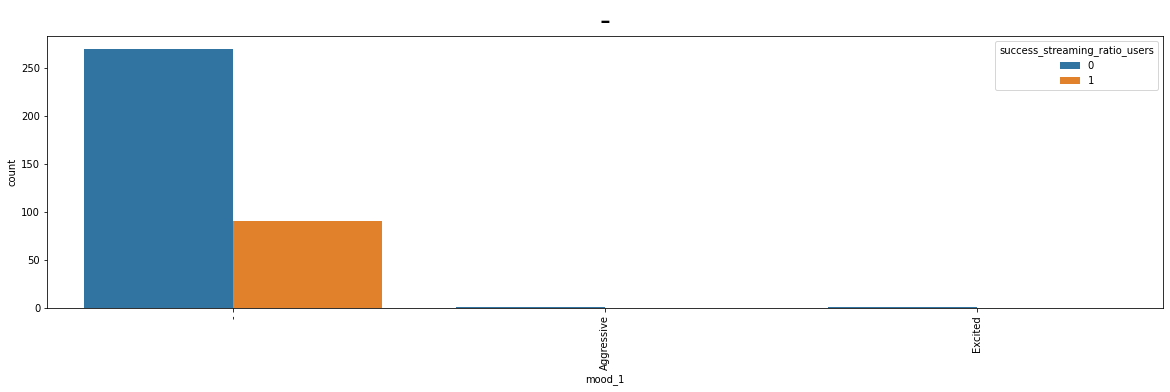

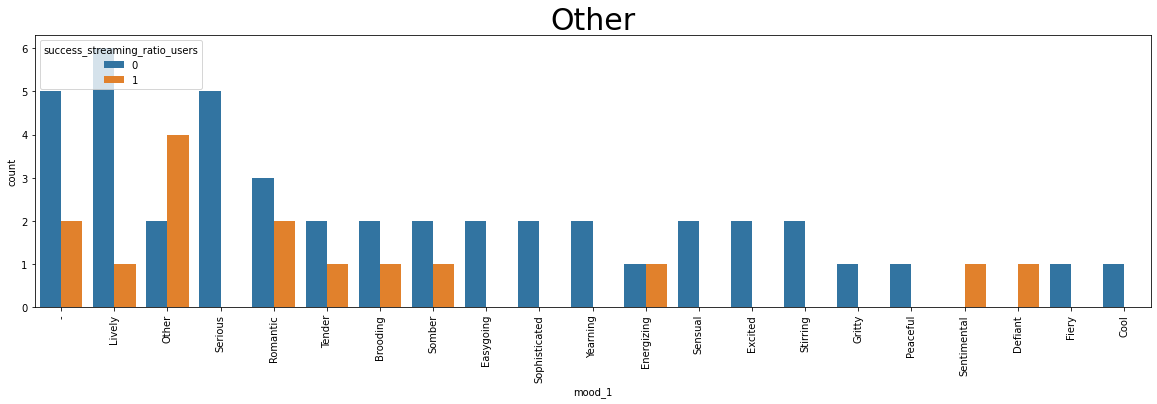

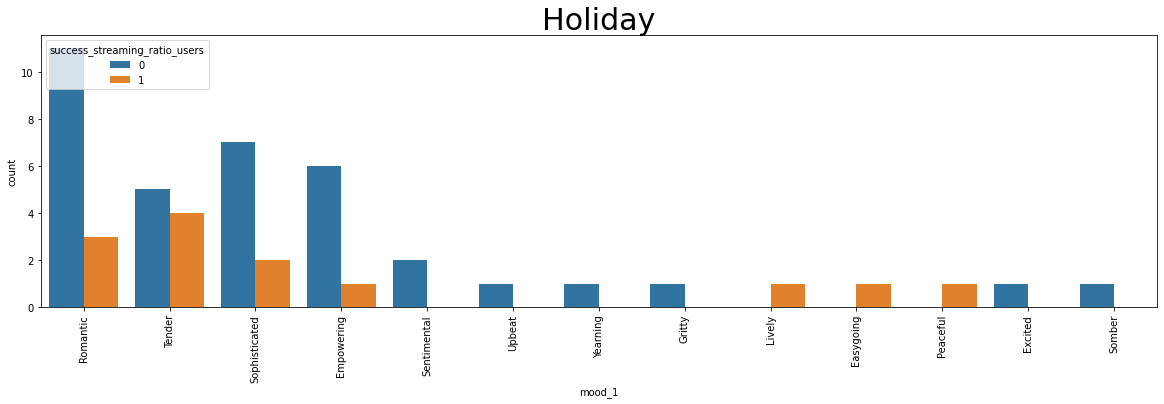

In [39]:
genres = list(success_frame["genre_1"].unique())

for genre in genres:
    genre_frame = success_frame.loc[lambda f: f['genre_1']==genre]
    
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.countplot(x="mood_1", data=genre_frame, order=genre_frame["mood_1"].value_counts().index, hue="success_streaming_ratio_users")
    plt.title(f'{genre}', size=30)
    plt.xticks(rotation=90)
    plt.show()
    

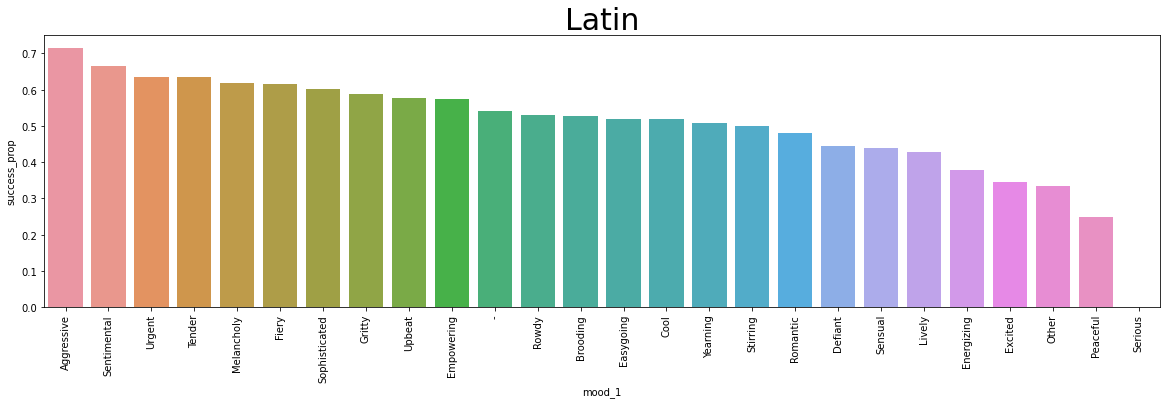

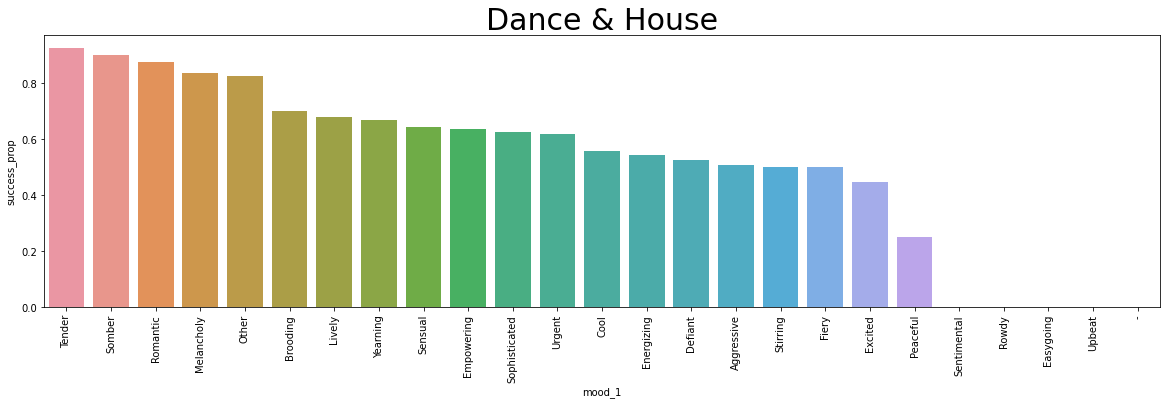

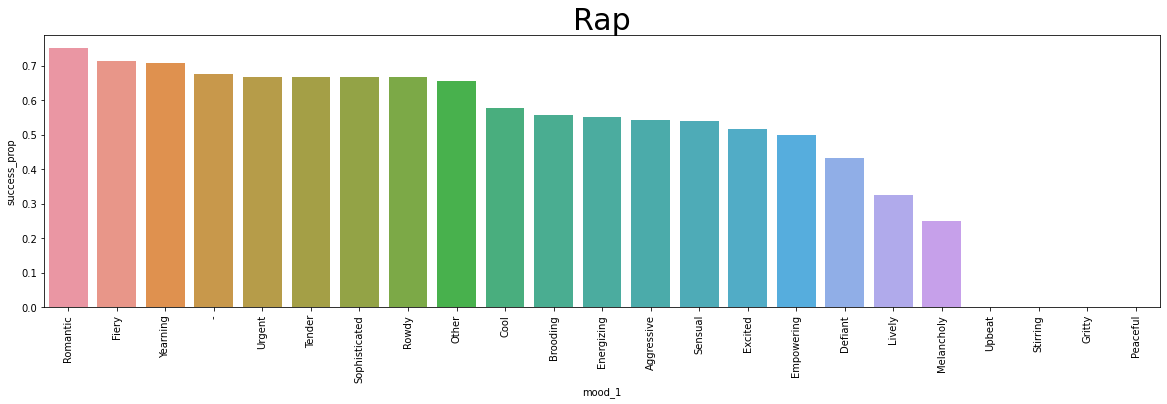

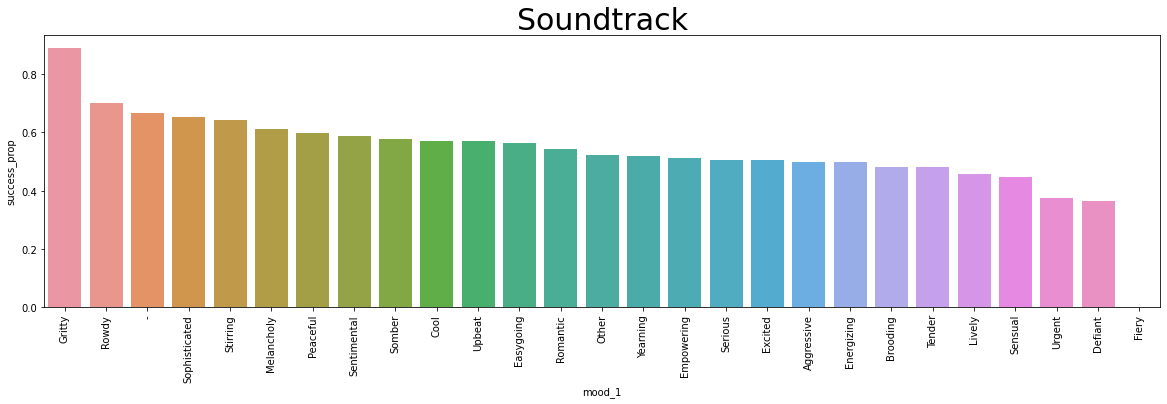

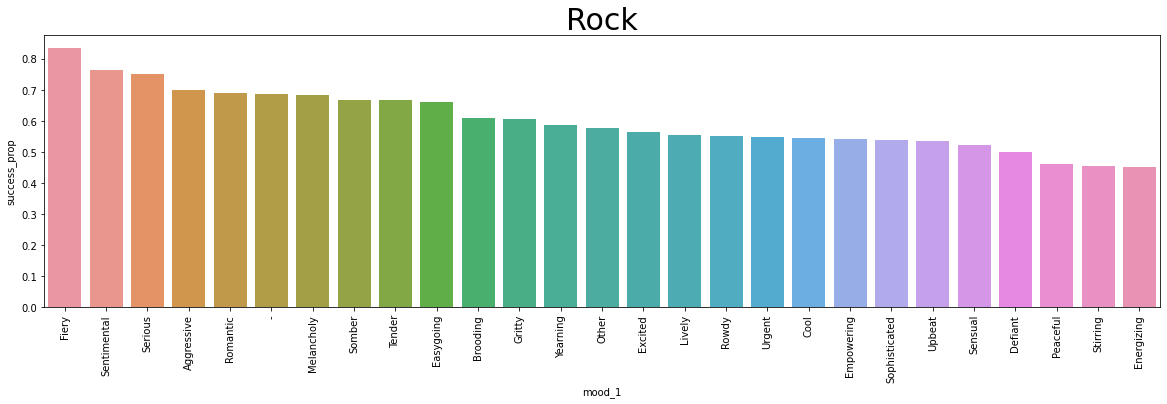

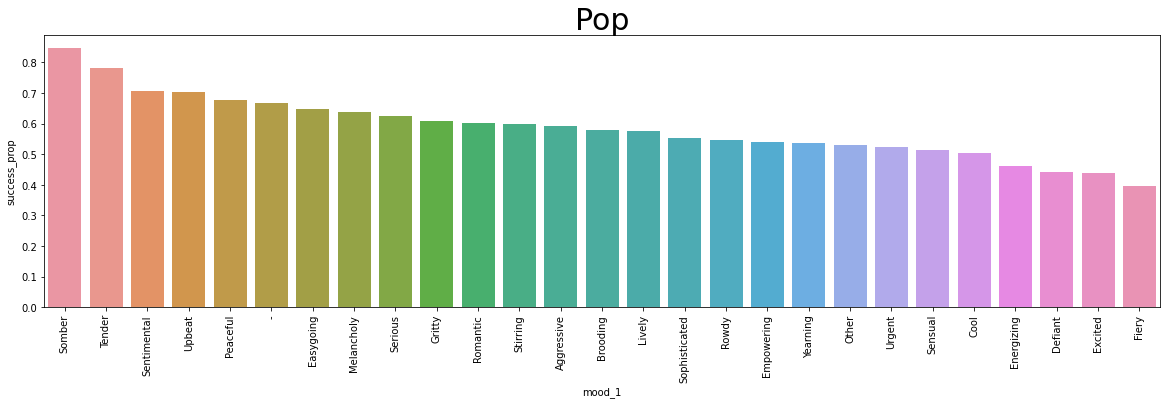

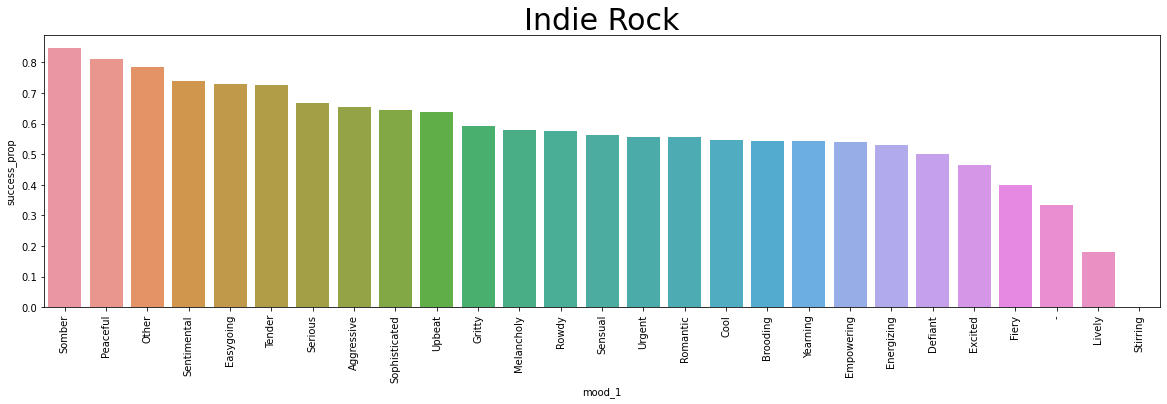

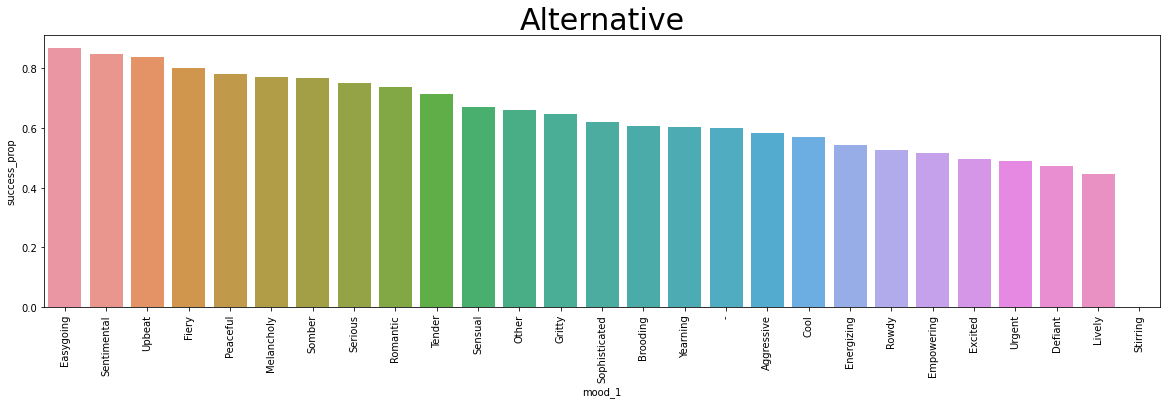

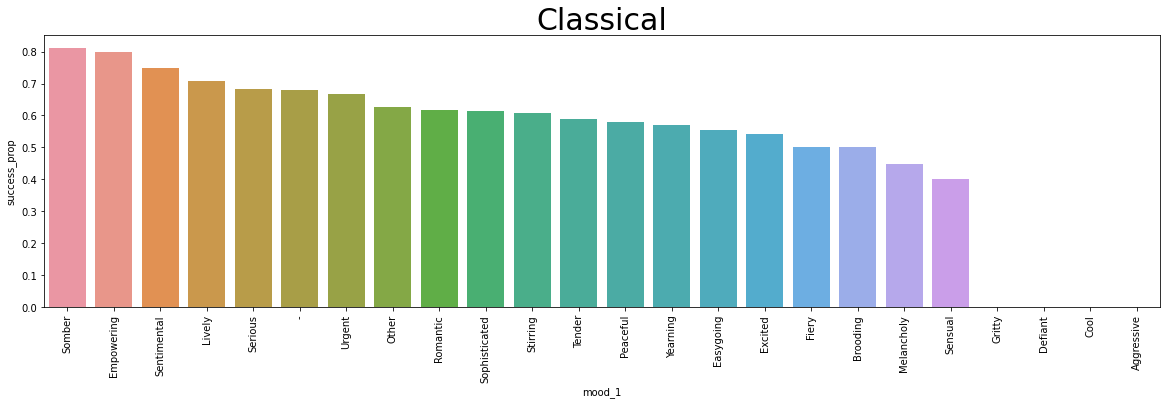

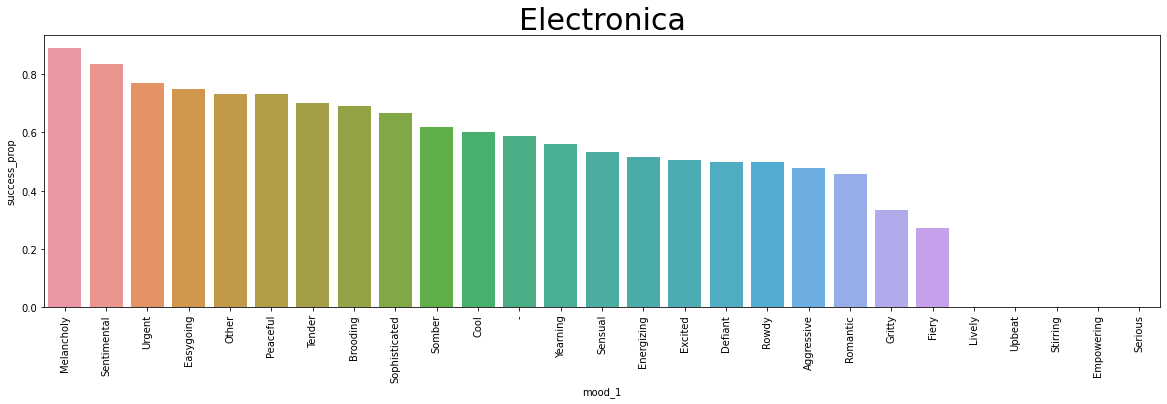

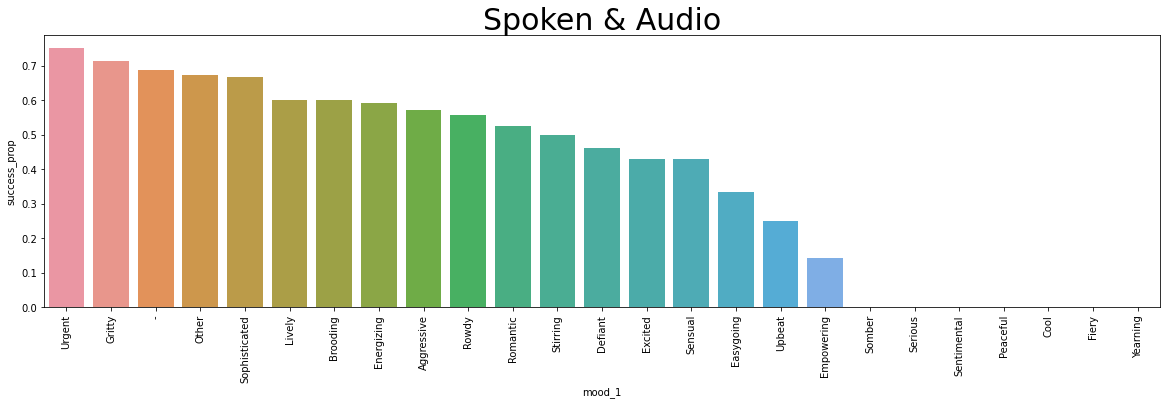

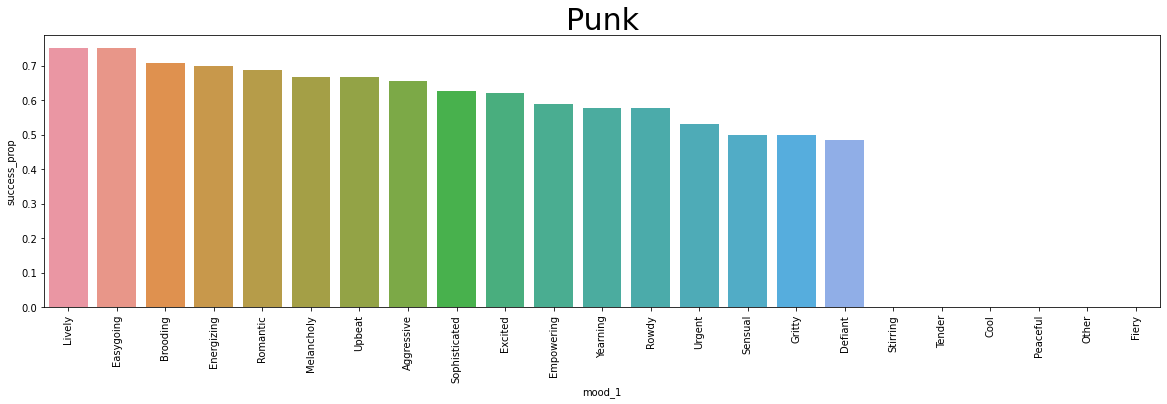

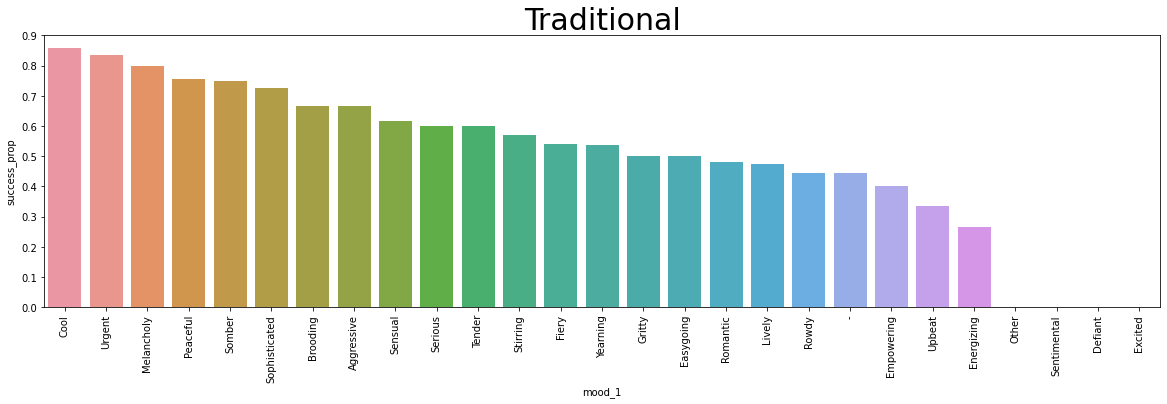

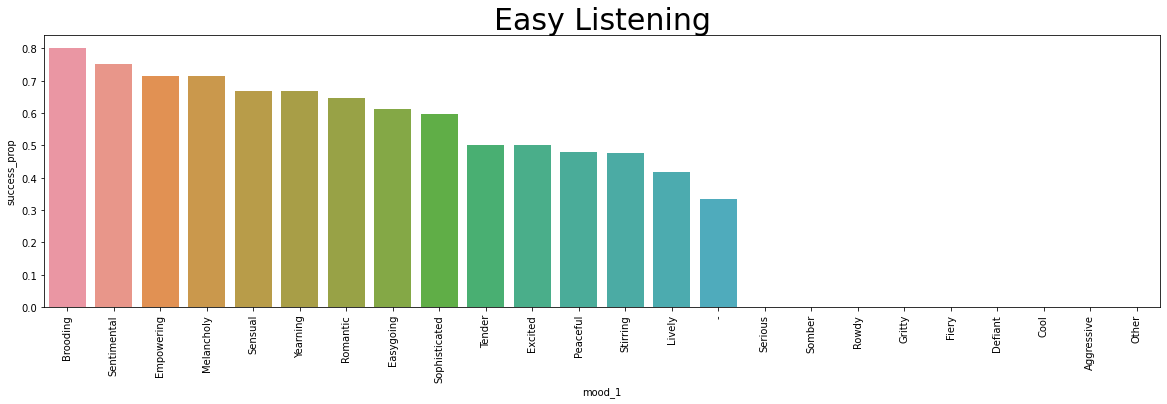

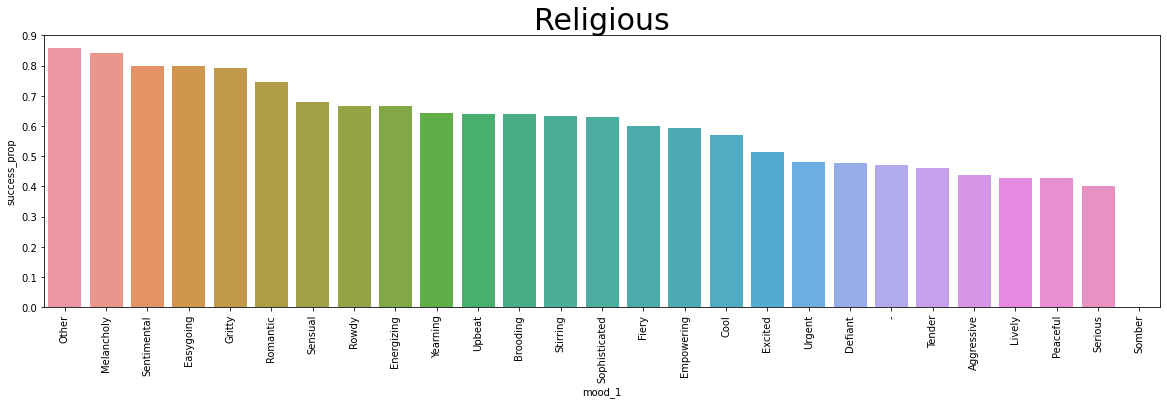

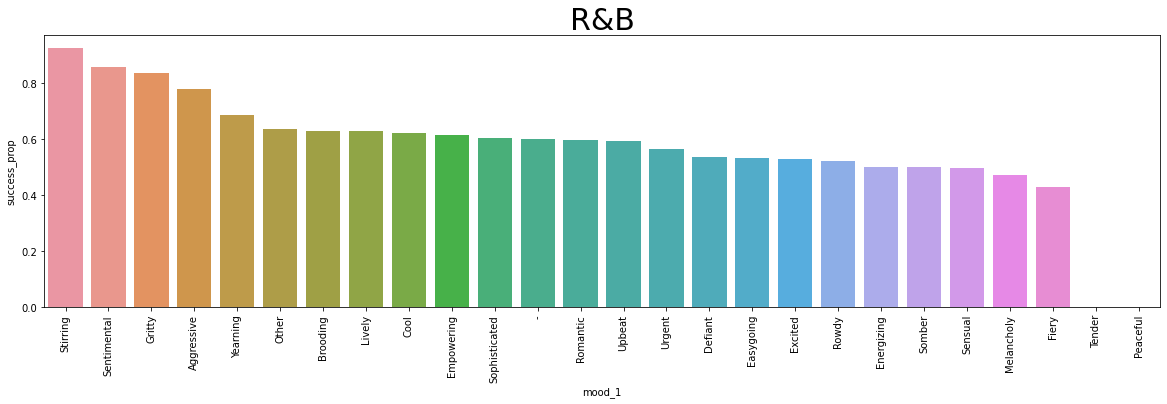

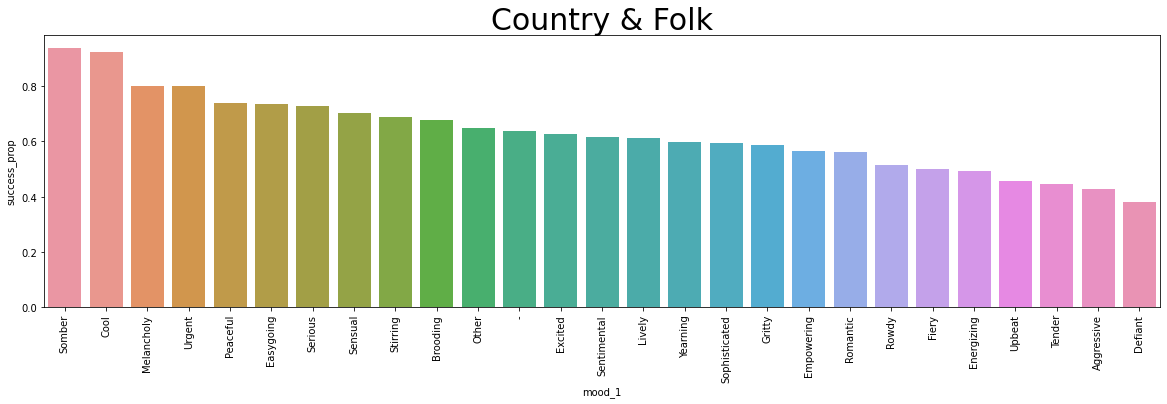

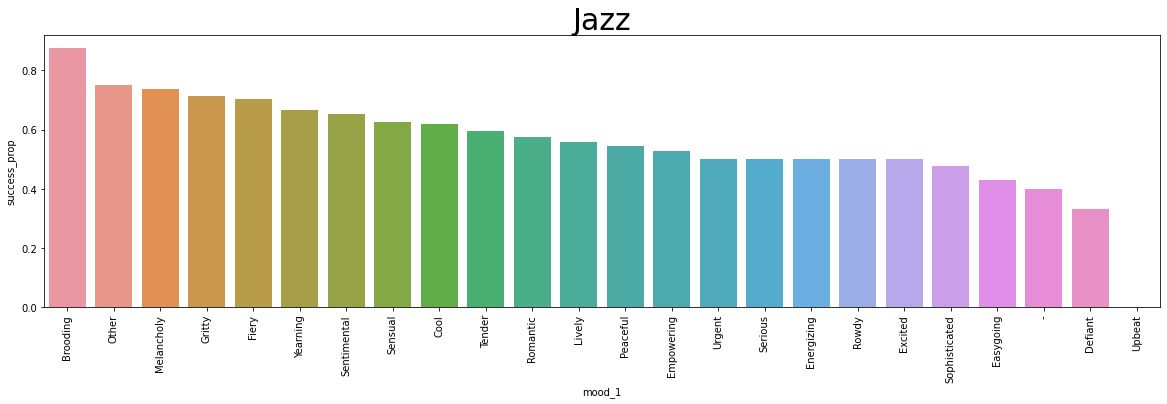

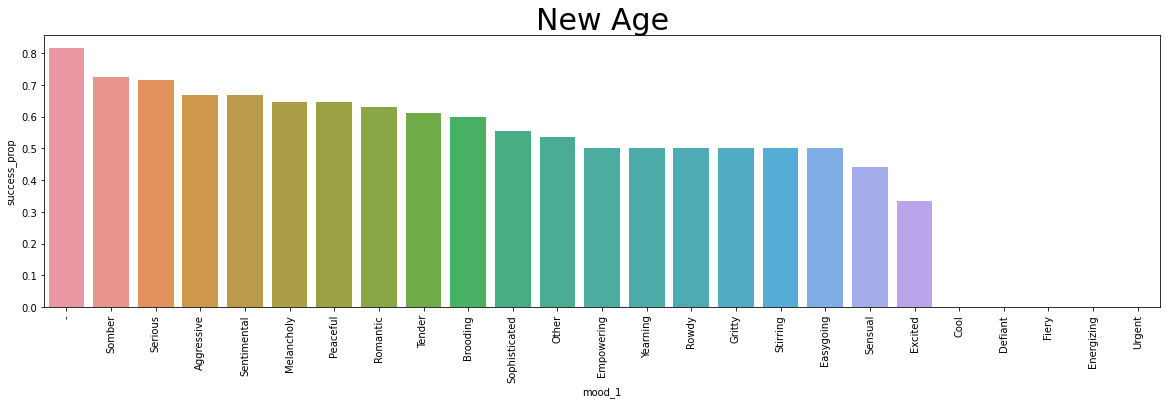

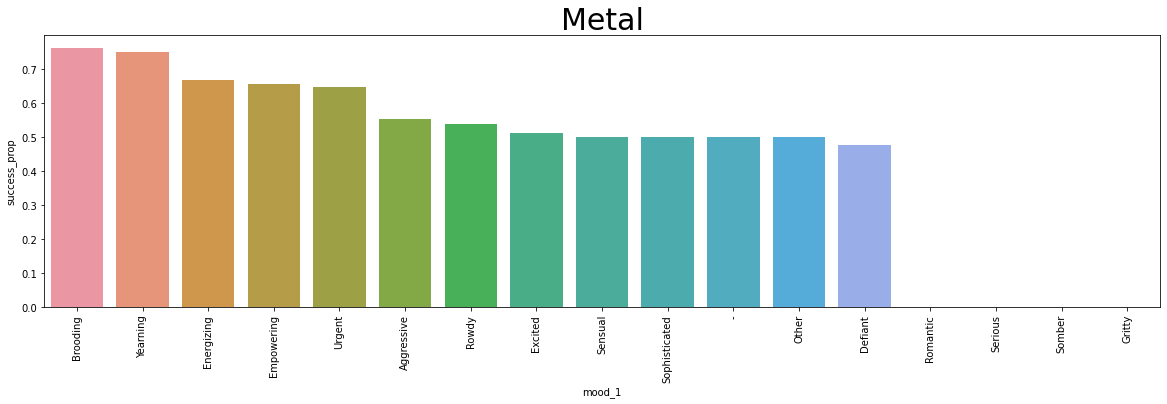

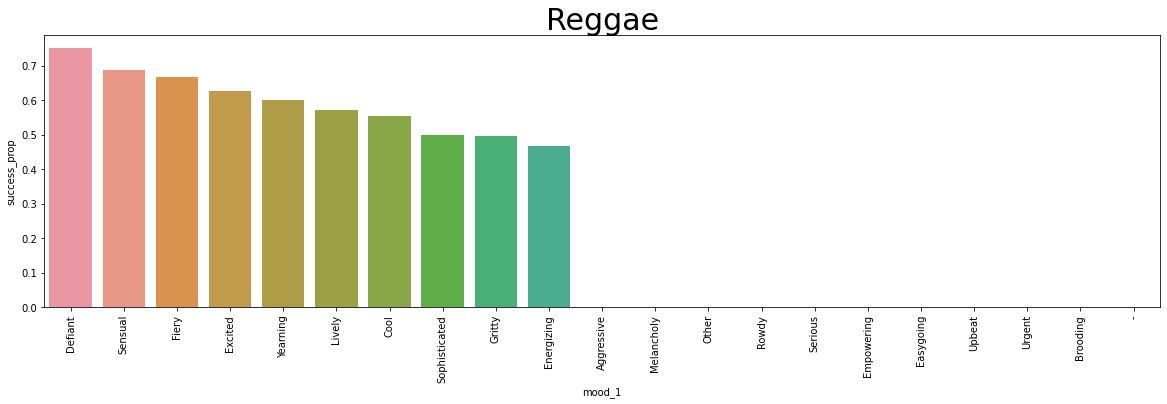

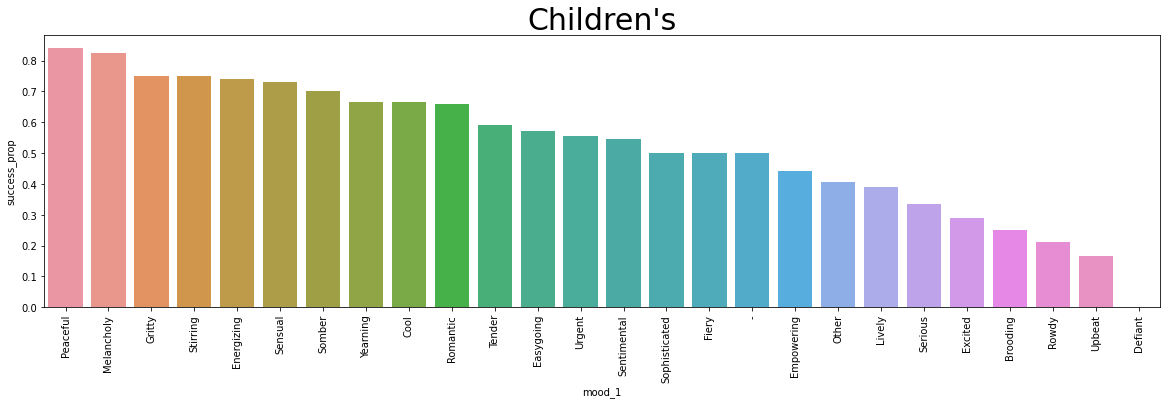

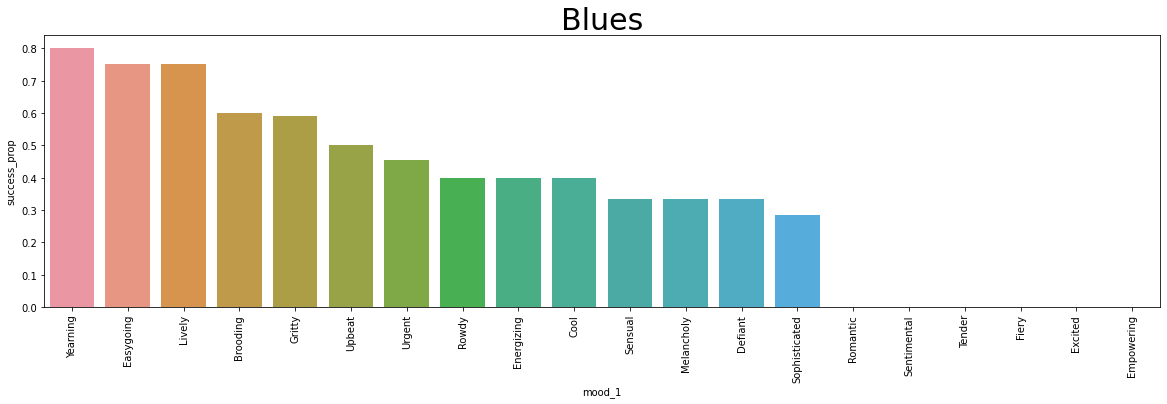

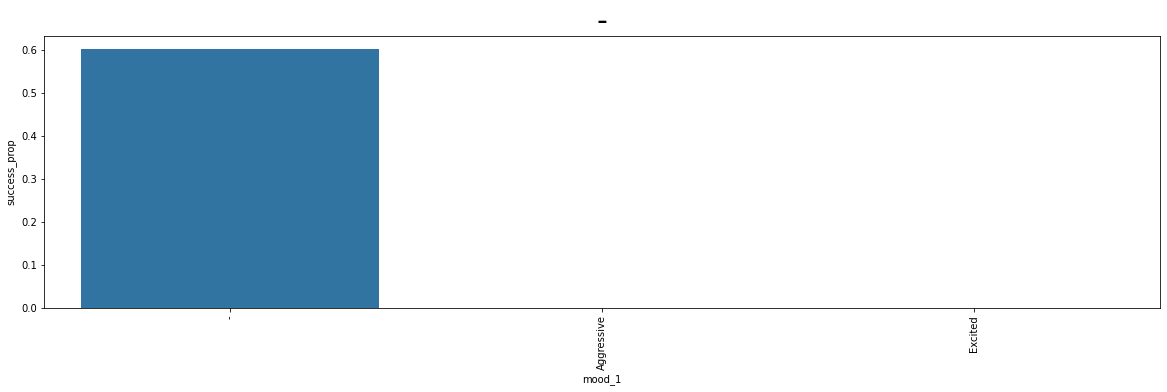

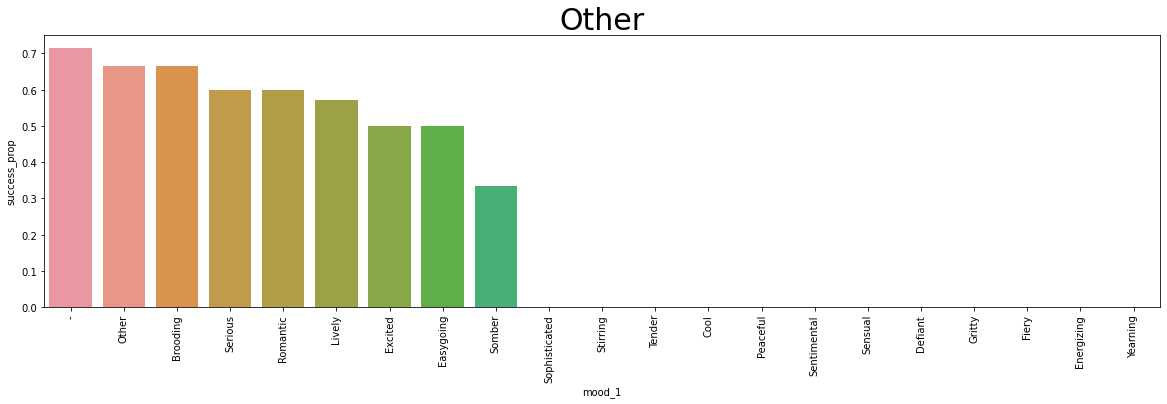

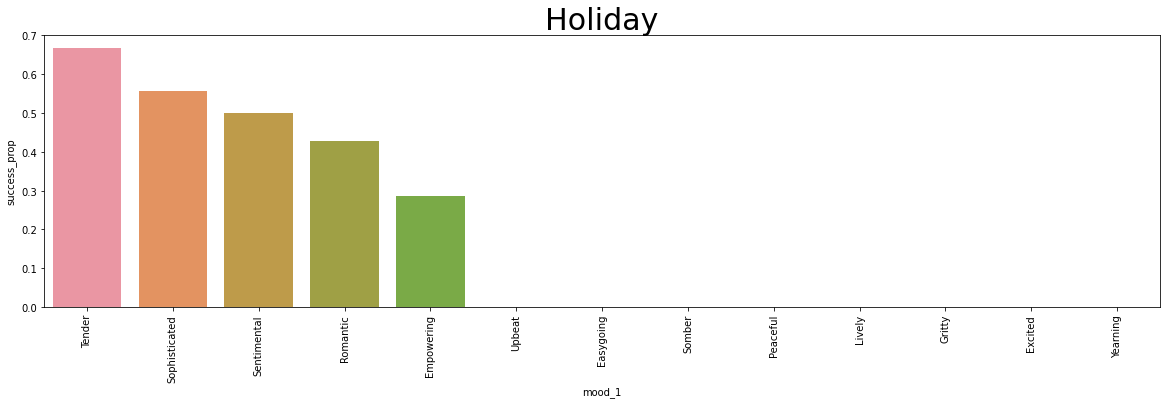

In [32]:
genres = list(success_frame["genre_1"].unique())
# target_col = "success_streaming_ratio_users"
target_col = "success_skip_ratio"
for genre in genres:
    genre_frame = success_frame.loc[lambda f: f['genre_1']==genre]
    genre_group = genre_frame.groupby(["mood_1", target_col]).count().reset_index()[["mood_1", target_col, "playlist_uri"]]
    genre_success = genre_group.loc[lambda f: f[target_col]==1].rename(columns={"playlist_uri":"num_success"})[["mood_1", "num_success"]]
    genre_not_success = genre_group.loc[lambda f: f[target_col]==0].rename(columns={"playlist_uri":"num_not_success"})[["mood_1", "num_not_success"]]
    
    genre_success_prop = (genre_group[["mood_1"]]
                      .merge(genre_success, how='left', on='mood_1')
                      .merge(genre_not_success, how='left', on='mood_1')
                      .fillna(0)
                      .assign(success_prop = lambda f: np.where(f["num_not_success"]==0, 0, f["num_success"]/ (f["num_success"]+f["num_not_success"])))
                      .sort_values(by='success_prop', ascending=False)
                     )
        
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(x="mood_1", y='success_prop', data=genre_success_prop)
    plt.title(f'{genre}', size=30)
    plt.xticks(rotation=90)
    plt.show()

# Downloading Song Info

In [112]:
target_frame = target_frame.reset_index(drop=True)
list_user = []
list_playlist = []

for playlist_uri in target_frame["playlist_uri"]:
    tokens = playlist_uri.split(':')
    list_user.append(tokens[2])
    list_playlist.append(tokens[4])
    
target_frame["user_id"] = list_user
target_frame["playlist_id"] = list_playlist

In [113]:
target_frame

playlist_uri  \
0      spotify:user:6b7fbed9edd6418ddd3b555bba441536:...   
1      spotify:user:f7eae3b747d71612726316e5fbae7bab:...   
2      spotify:user:d2663dd02ba0b23da58f0e3c20a9e29f:...   
3      spotify:user:e94f26e753c60c77af42865c3abb795e:...   
4      spotify:user:53799bac8ce5ddede33028f7841b6e02:...   
...                                                  ...   
70394  spotify:user:20137d62d79c8899d689530a5ea7eee2:...   
70395  spotify:user:6c37a662e07e9d48c612ddb36fa5a6a7:...   
70396  spotify:user:0174304c8028f06c87c2ca0a4ada3bb1:...   
70397  spotify:user:055d33003af0de47c79559c56ba6ee5b:...   
70398  spotify:user:4672952d42bdd93b9215ce9a40394ea6:...   

                                  owner  streams  stream30s  dau  wau  mau  \
0      6b7fbed9edd6418ddd3b555bba441536        4          2    1    1    7   
1      f7eae3b747d71612726316e5fbae7bab       25         12    2    9   32   
2      d2663dd02ba0b23da58f0e3c20a9e29f       59         51    2   10   17   
3      e94f26e753c60c77af42865c3abb795e        5          2    1    3    5   
4      53799bac8ce5ddede33028f7841b6e02        0          0    0    2    6   
...                                 ...      ...        ...  ...  ...  ...   
70394  20137d62d79c8899d689530a5ea7eee2       32         26    2   12   38   
70395  6c37a662e07e9d48c612ddb36fa5a6a7       27         25    1    6   17   
70396  0174304c8028f06c87c2ca0a4ada3bb1        0          0    0    1    6   
70397  055d33003af0de47c79559c56ba6ee5b        0          0    0    2    4   
70398  4672952d42bdd93b9215ce9a40394ea6       18          6    2    6   13   

       mau_previous_month  mau_both_months  users  ...  \
0                       5                0     15  ...   
1                      26                1     71  ...   
2                      12                5     29  ...   
3                       9                1     18  ...   
4                      10                3     14  ...   
...                   ...              ...    ...  ...   
70394                  53               10    113  ...   
70395                  14                5     30  ...   
70396                   4                0     13  ...   
70397                   4                1     15  ...   
70398                  12                8     20  ...   

       monhtly_non_owner_stream30s streaming_ratio_mau  streaming_ratio_users  \
0                               63            9.000000               4.200000   
1                              203            6.548387               2.900000   
2                             1327           82.937500              47.392857   
3                               40           10.000000               2.352941   
4                              159           31.800000              12.230769   
...                            ...                 ...                    ...   
70394                          522           14.108108               4.660714   
70395                          880           55.000000              30.344828   
70396                           11            1.833333               0.846154   
70397                            6            2.000000               0.428571   
70398                          421           35.083333              22.157895   

       skip_ratio_users  mau_perc  mau_new  mau_new_perc  title_length  \
0              4.000000  0.466667        2     40.000000     40.000000   
1              5.492958  0.450704        6     23.076923     23.076923   
2              8.275862  0.586207        5     41.666667     41.666667   
3              5.000000  0.277778       -4    -44.444444    -44.444444   
4              0.000000  0.428571       -4    -40.000000    -40.000000   
...                 ...       ...      ...           ...           ...   
70394          1.592920  0.336283      -15    -28.301887    -28.301887   
70395          2.000000  0.566667        3     21.428571     21.428571   
70396          0.000000  0.461538        2     50.

In [51]:
all_tracks_frame = pd.read_parquet(
        "/Users/alexander_wong/Documents/playlist-success/data/playlist_track_ids/playlist_track_ids_all.parquet"
    )
all_tracks = list(all_tracks_frame["track_id"].unique())

In [66]:
all_tracks_frame

track_id  popularity                           user_id  \
0   5MiZ199HjYwrZfuNWVSxC9        30.0  6b7fbed9edd6418ddd3b555bba441536   
1   3mqGTIR5BxJ678KkHFT4tg         2.0  6b7fbed9edd6418ddd3b555bba441536   
2   2pOya9IyPgv2XLR7FfnySh         7.0  6b7fbed9edd6418ddd3b555bba441536   
3   6SbP5526KNn4z2Dex2uf2B         0.0  6b7fbed9edd6418ddd3b555bba441536   
4   6GjLKnNDVFsg6oLuplDwKF         0.0  6b7fbed9edd6418ddd3b555bba441536   
..                     ...         ...                               ...   
32  1qavn2qJRP3IoWnLkFzwI8         4.0  055d33003af0de47c79559c56ba6ee5b   
0   6cLgBwRc1LfV0cSoboEfJD         0.0  4672952d42bdd93b9215ce9a40394ea6   
1   4f0ldNhe5ZsIhzene1nup1        32.0  4672952d42bdd93b9215ce9a40394ea6   
2   0DNk7lEqDGCN6nDD0H8emF         0.0  4672952d42bdd93b9215ce9a40394ea6   
3   3Qi2o8uPKDByu6vFF1iq9d         0.0  4672952d42bdd93b9215ce9a40394ea6   

               playlist_id  
0   6zpLN2wRu8z7fo4q6ouaAh  
1   6zpLN2wRu8z7fo4q6ouaAh  
2   6zpLN2wRu8z7fo4q6ouaAh  
3   6zpLN2wRu8z7fo4q6ouaAh  
4   6zpLN2wRu8z7fo4q6ouaAh  
..                     ...  
32  6orq0HsuzPGA1yOCNvCLMw  
0   6W45lqDBZ1TKma71Uu2F5x  
1   6W45lqDBZ1TKma71Uu2F5x  
2   6W45lqDBZ1TKma71Uu2F5x  
3   6W45lqDBZ1TKma71Uu2F5x  

[16456661 rows x 4 columns]

In [52]:
features_part_1 = pd.read_parquet('../data/track_features/track_features_all_half_1.parquet')
features_part_2 = pd.read_parquet('../data/track_features/track_features_all_half_2.parquet')
features_frame = pd.concat([features_part_1, features_part_2])

In [65]:
features_frame

track_id  acousticness  danceability  duration  energy  \
0   5MiZ199HjYwrZfuNWVSxC9      0.488000         0.812  191867.0   0.700   
1   3mqGTIR5BxJ678KkHFT4tg      0.345000         0.468  167208.0   0.715   
2   2pOya9IyPgv2XLR7FfnySh      0.540000         0.636  201853.0   0.783   
3   6SbP5526KNn4z2Dex2uf2B      0.272000         0.645  181360.0   0.465   
4   6GjLKnNDVFsg6oLuplDwKF      0.821000         0.562  175013.0   0.432   
..                     ...           ...           ...       ...     ...   
98  5SDx2ULq2bua9PpzKpFST5      0.465000         0.599  259566.0   0.644   
99  7tHxHR2feUlZiszREfc0Me      0.000033         0.645  225253.0   0.883   
0   3gc8l6ofVOij1MTFGtjRVu      0.600000         0.340  218227.0   0.509   
1   0PRhaTr3tUrqGOhCPyuByc      0.217000         0.857  282647.0   0.816   
2   276ZMvJOrqMgkilcEnlBz4      0.191000         0.675  363933.0   0.769   

    instrumentalness   key  liveness  loudness  mode  speechiness    tempo  \
0           0.000001   7.0    0.3630    -3.579   1.0       0.0497  105.023   
1           0.000000   7.0    0.1370    -5.671   1.0       0.1510  162.317   
2           0.000000  11.0    0.3010    -3.918   1.0       0.0461  159.097   
3           0.000000  11.0    0.1660    -6.630   1.0       0.0396  184.906   
4           0.000006  10.0    0.0935    -4.441   1.0       0.0545  170.406   
..               ...   ...       ...       ...   ...          ...      ...   
98          0.007490   1.0    0.1190    -7.794   0.0       0.0692   92.070   
99          0.005120   2.0    0.0830    -5.840   1.0       0.0381  130.317   
0           0.001220   0.0    0.1120    -7.154   1.0       0.0286  143.759   
1           0.000082   7.0    0.1350    -6.947   1.0       0.0598  131.990   
2           0.000036   5.0    0.0926    -8.205   1.0       0.0447  140.067   

    time  valence  
0    4.0    0.925  
1    4.0    0.803  
2    3.0    0.892  
3    3.0    0.952  
4    3.0    0.950  
..   ...      ...  
98   4.0    0.436  
99   4.0    0.670  
0    4.0    0.255  
1    4.0    0.965  
2    4.0    0.771  

[3871842 rows x 14 columns]

In [84]:
missing = ['1LzN6aBRGMyVUYywm96MRs', '3Gocy79dx8PvdprsNBJSOJ',
       '68aTRHENFdlH1Yx2mnNCXT', '1cgZT4xrBb9U5dZXSSekw6',
       '3LTFRZRkFDjZG8oOyCD9pz', '5QjAfzo0zg2rU40ki3jz6m',
       '0Rr9IKGqBks28bwbgeZuWi', '6wTooFfqYpzkSCJYqceWES',
       '6b2TrKVlo3qKMPMwagkjdC', '3KUeiticavFiZJHxno24xJ',
       '0J6OC9oDEKK6JMe2hcUQxW', '32ZnsgTDokCOUwokXpDO99',
       '2RraYtO8z9ei6OHo9vnltT', '7hp6paHG0x2uYaz5tRumjR',
       '5RDSL2tjrvG9KlAgsyDvP5', '38vCtB9rYsuwfAoSIN5Uhy',
       '4NQsDGqGh9zVTv0DOqVlOM', '3D9NX1YAuGTZVR6Zm0Agsk',
       '1kCQ1ALHJLvFlrUv8i5b5K', '0eW6LK9xeddRp1u5BnfrjW',
       '4RBq1IXHtgB8cTxLQuup1r', '57F66WQ9yLWYkrlFvPDU3R',
       '4whpMZbl1Z34Rco78nBiBw', '0Usfe8igLp1DB44xGoO62C',
       '1PcuWcvrlek4oCyARrsl7b', '62raDuHWVG79nE2Rm1Av1J',
       '77Zov1ItRjFuCN8aHCpbGl', '1bzSVNyKjESSzje469MNLd',
       '10qzlPnpJ9XI2iJA5wYuUQ', '657yqqxpIBrfD40wb1f7UG',
       '5FJt5szpVN755NNjYrl4dJ', '3wtBY3ccG0BgDJkAPIuEKL',
       '6Ckoc4QQWiXvd3W5UkkS4c', '2UDVCGI4mxmlNTEh83ka2P',
       '20sOmKuqrqCzZ8eVOL5U0N', '0MvxItKOv3QmSK3znX8Dqh',
       '2DJcld4r3MkL3rxgqW5rX4', '3Tjtf9ZOwWEIx1SC1B7k6X',
       '44FnGaDbA8L1FJ8MNM4vRi']

In [89]:
features = list(features_frame["track_id"].unique())

for x in tqdm(missing):
    if x not in features:
        print(x)

100%|██████████| 39/39 [00:03<00:00, 11.90it/s]


In [88]:
from tqdm import tqdm